# Import Data:

In [1]:
#list the data - 
!mkdir Data
!ls Data

mkdir: cannot create directory ‘Data’: File exists
102slersuoacontest20181024-1.tab
102slersuoacontest20181024codebook-1.txt
1976-2018-house.csv
averages.csv
Cache
county_assignments.csv
countypres_2000-2016.csv
fivethirtyeight_partisan_lean_DISTRICTS.csv
fivethirtyeight_partisan_lean_STATES.csv
Output
vote_predictions.csv


In [2]:
!ls

'Capstone Project Proposal - 2.pdf'
 Data
'Data Wrangling - EDA - Machine Learning.ipynb'
 historical_partisan_lean..ipynb
 images
"Machine Learning Report_don't track.odt"
'Presentation - Capstone 2.pdf'
 PROPUBLICA_API_KEY.TXT
 README.md


### Get Pro Publica API working

In [3]:
import requests

#Load ProPublica API key without exposing it to github. Request one yourself. They're free.
#https://projects.propublica.org/api-docs/congress-api/
APIfile = open('./PROPUBLICA_API_KEY.TXT',)
APIkey = APIfile.read().replace('\n', '')

#simple unit tests - will throw an error if API key is malformed
assert type(APIkey) == str
assert len(APIkey) == 40

#create API key header
headers = {'X-API-Key': APIkey}

#API request function
def API_Request(end_point, verbose=True):
    '''for a given endpoint, return API response from Propublica api as a dictionary'''
    
    #send request using combined url, endpoint, and headers
    response = requests.get(url+end_point, headers=headers)
    
    #raise error if status code isn't 200. 
    response.raise_for_status()
    
    #return json response interpreted as a dictionary. 
    return response.json()

#load base url and test endpoint
url = 'https://api.propublica.org/congress/v1'
test_endpoint = '/members/new.json'

#test that the API is working. Prints 'OK' on succes
new_members = API_Request(test_endpoint)
assert new_members['status'] == 'OK'
assert new_members['results'][0]['num_results'] == '20'
print(new_members['status'])

OK


### OK, The API is working.  Let's import voting data

In [4]:
import pandas as pd
import numpy as np
from retrying import retry
from datetime import datetime
import sys


@retry(stop_max_attempt_number=5) #we're going to try this function 5 times until it returns a value
def API_attempts(endpoint):
    '''takes and endpoint and requests the API with it for a given number of times'''  
    #if we can't extract the status we'll keep trying, and if it's OK return the repsonse
    
    #initialize status as an error, this will change if we can extract it.
    status = 'Error fetching API response'
    
    #try to get the API response and extract status without throwing an error on failure
    try:
        #send endpoint to API function for request
        response = API_Request(endpoint)
        
        #extract the status of the API request
        status = response['status']   
    except:
        pass
    
    #if the status is not OK:
    if status != 'OK':
        #Say what the status is
        print(status, end=' ')
        
        #state that we're retrying
        print('retrying')
        
        raise
    else: 
        #return the response if status is ok
        return response
    
        
#let's create a function that will import vote positions for a given rollcall vote.
def import_vote(congress, chamber, session, roll_call):
    '''imports vote details and member positions of a given roll_call vote
        takes congress number 102-116 for House, 80-116 for Senate
        chamber(house|senate) session 1 for odd 2 for even-numbered years
        returns a dictionary of vote positions and API status'''
    #construct endpoint for API request
    for x in [congress, chamber, session, roll_call]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/sessions/{}/votes/{}.json'.format(congress, chamber.lower(), session, roll_call)
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return the vote positions
    try:
        vote = call_response['results']['votes']['vote']
        return vote
    except:
        return {}
    
def import_members(congress, chamber):
    '''imports memberdetails for a given congress and chamber
    https://projects.propublica.org/api-docs/congress-api/members/#lists-of-members'''
    
    #construct endpoint for API request
    for x in [congress, chamber]:
        x = str(x)#                 
    call_endpoint = '/{}/{}/members.json'.format(congress, chamber.lower())
    
    #let's attempt a few times to account for internet burps
    call_response = API_attempts(call_endpoint)
        
    #try to extract and return robustly
    try:
        members = call_response['results'][0]['members']
        return members
    except:
        return {}

def get_member(member_id):
    '''gets info on a specific member by member id 
    https://projects.propublica.org/api-docs/congress-api/members/#get-a-specific-member'''
    #construct API endpoint
    call_endpoint = '/members/{}.json'.format(member_id)
    
    #request API endpoint - retry a few times if needed
    call_response = API_attempts(call_endpoint)
    
       #try to extract results and return robustly
    try:
        member = call_response['results'][0]
        return member
    except:
        return {}
    
    
def positions_df(metalist):
    '''return a dataframe of postions for a given list of vote metadata'''
    
    #initialize dataframe
    dfp = pd.DataFrame()
    
    #for every position in the list
    for congress, chamber, session, roll_call in metalist:
        
        #request the roll_call vote from the API
        vote = import_vote(congress, chamber, session, roll_call)
        
        #extract the positions from the rollcall vote data
        positions = vote.pop('positions')
        
        #turn the postions into a dataframe
        call_positions = pd.DataFrame(positions)
        
        #if both dataframes we are going to merge are not empty
        if not dfp.empty and not call_positions.empty:
            
            #handle duplicated positions for malformed returns
            dups = call_positions.duplicated()
            if dups.sum() > 0:
                call_postions = call_positions.drop_duplicates()
                print('{} dups'.format(dups.sum()), end='')
        
            #MERGE THE POSITIONS FOR A GIVEN ROLL CALL VOTE INTO DATAFRAME <- core of function 
            dfp = pd.merge(dfp, call_positions, on=mergelst, how='outer')
            
            #let us know it's working
            print('.', end='')
            
        #If dfp is empty this is the first run and we need to initialize it
        elif dfp.empty: 
            #make it equal to call_positions
            dfp = call_positions
            
            #make a list of the columns that will be used to merge the call positions
            mergelst = dfp.columns.tolist()[:-1]
            
            #move party and state to front of merglist
            for x in ['state','party']:
                mergelst.insert(0, mergelst.pop(mergelst.index(x)))
            
            #alert that we've started
            print('\ndf created on', congress, chamber, session, roll_call, end=' ')
        
        #handle empty postitions dataframe:
        elif call_positions.empty:
            
            #let us know there was a problem
            print('\nno vote postions available for', congress, chamber, session, roll_call, end=' ')
            
            #append a series of Nan values
            ht = dfp.shape[0]
            nans = pd.Series([np.nan for _ in range(ht)])
            print ('dfp.shape:', dfp.shape)
            print ('Appending {} NaNs'.format(len(nans)))
            dfp = pd.concat([dfp, nans], axis = 1)
            print(dfp.iloc[:3,-4:])
        
        #handle unknown issue
        else:
            print('\nunknown error for', congress, chamber, session, roll_call, end=' ')
    
    #create a multindex of partymembers
    dfp = dfp.set_index(mergelst).transpose()
    
    #after transposing use the metalist as the index
    dfp.index = metalist
    
    #final check to make sure members aren't duplicated
    dfp = dfp.loc[:,~dfp.columns.get_level_values('member_id').duplicated()]
    
    #return the complete data frame
    return dfp 

def import_month(year, chamber, month):
    '''import vote metadata for a given year or month and return a dataframe '''
    
    #Stop everthing if we are using a year before 1989 or after now
    assert 1989 <= year <= int(datetime.now().year), "year out of range"
    
    #construct endpoint
    call_endpoint = '/{}/votes/{}/{}.json'.format(chamber.lower(), str(year), str(month))
    
    #use endpoint to request the API robustly with attempts function
    response = API_attempts(call_endpoint)
    
    #Extract the votes from the response
    votes = response['results']['votes']

    #create a dataframe out of the votes
    votesdf = pd.DataFrame(votes)
    
    if not votesdf.empty:
        votesdf = votesdf.set_index(['congress','chamber','session','roll_call']).sort_index()
    
    #return the months dataframe
    return votesdf

def import_year(year, chamber):
    '''import votes based on dates, return a dataframe of appended votes'''
    
    
    #So we know we started:
    print('importing', chamber, year, end=' ')
    #loop through the months 
    for month in range(1,13):
        
        #import the first month
        if month == 1:
            yeardf = import_month(year, chamber, month)
       
        #import the month of votes as a df and append it to the list 
        else:
            df = import_month(year, chamber, month)
            if not df.empty:
                yeardf = yeardf.append(df)
            else:
                print('skip', end=' ')
        #print something so we know it's working
        print(month, end=' ')
        
    #return the dataframe
    return yeardf

def save_years(start_y, end_y):
    '''take a range of years and save a series of dataframes for those years in both the hosue and senate'''
    #iterate through the range of years
    for year in range(start_y, end_y+1):
        #alternate between senate and house
        for chamber in ['senate','house']:
            
            #construct paths
            metapath, pospath = construct_paths(year, chamber)
            
            #import vote metadata dataframe
            votemetadf = import_year(year, chamber)
            
            #import vote positions for given dataframe
            voteposdf = positions_df(votemetadf.index)
            
            #save them
            save_csv(year, chamber, votemetadf, metapath)
            save_csv(year, chamber, voteposdf, pospath)
            
def save_csv(year, chamber, df, path):
    '''takes dataframes from a given year and chamber and saves them to given paths'''
    #announce what we're doing
    print('\nsaving {} {} as {}'.format(str(year), chamber, path))
        
    #save data frames as csv in data/csv directory
    df.to_csv(path)
    
def construct_paths(year, chamber):
    '''construct paths to save or load csv files, 
    takes year and chamber and returns meta path and position path'''
    pathhead = 'Data/Cache/{}_{}vote_'.format(str(year), chamber)
    metapath = pathhead + 'meta.csv'
    pospath = pathhead + 'pos.csv'
    return metapath, pospath

def get_delta(votemetadf, voteposdf):
    '''check for differences in index, import missing and save new file if found'''
    
        
    return voteposdf
                    
def load_cache(year, chamber, force=False):
    '''try to load data for a given year and chamber from csv, and use the API to cache it if it's missing'''
    
    #construct paths
    metapath, pospath = construct_paths(year, chamber.lower())
    
    #setup header / index col
    header = list(range(5))
    if chamber.lower() == 'house':
        header.append(5)
    index_col = list(range(4))
    
    #try to import to load the dfs via csv, and if they don't exist import via the API and cache them.
    try:
        assert force == False,'Force'
        votemetadf = pd.read_csv(metapath, index_col=index_col)
        #check if too many days have passed 
        if year == int(datetime.now().year):
            assert (datetime.now() - pd.to_datetime(votemetadf.date)[-1]).days < 7, 'Cache out of date'            
        
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        votemetadf = import_year(year, chamber)
        save_csv(year, chamber, votemetadf, metapath)
        
    try:
        #Skip strait to manual import if force is on 
        assert force == False,'Force' 
        
        #import df from csv
        voteposdf = pd.read_csv(pospath, header=header, index_col=index_col, engine='python')
        
        #covert columns to floats - work around for pd.read_csv issue #9435:
        
        floatcol = voteposdf.columns.levels[-3].astype(float) #
        #print(floatcol)#.loc[:,'dw_nominate'].astype(float)
        newcolumns = voteposdf.columns.set_levels(floatcol, level='dw_nominate')
        voteposdf.columns = newcolumns
        
        #remove duplicated members
        voteposdf = voteposdf.loc[:,~voteposdf.columns.get_level_values('member_id').duplicated()]
        
        #check for a difference in indexes, if there is one import the delta.
        deltaidx = set(votemetadf.index.tolist()) - set(voteposdf.index.tolist())
        if deltaidx:        
            print('Missing data, importing delta')
            delta = positions_df(deltaidx)
            orcol = delta.columns
            dflst = [voteposdf, delta]
            if len(orcol) == len(voteposdf.columns):
                for df in dflst:
                    df.columns = df.columns.droplevel('dw_nominate')
            voteposdf = pd.concat(dflst, sort=False)
            #voteposdf = voteposdf.loc[:,~voteposdf.columns.duplicated()]
            voteposdf = voteposdf.loc[:,~voteposdf.columns.get_level_values('member_id').duplicated()]
            if len(orcol) == len(voteposdf.columns):
                voteposdf.columns = orcol
            voteposdf.sort_index('index', inplace=True)
            save_csv(year, chamber, voteposdf, pospath)
            
    except (FileNotFoundError, AssertionError) as e:
        print(e, 'importing from API', end = '')
        #force complete import from API and cache
        voteposdf = positions_df(votemetadf.index)
        voteposdf = voteposdf.loc[:,~voteposdf.columns.get_level_values('member_id').duplicated()]
        save_csv(year, chamber, voteposdf, pospath)
    
    #if call function recursively with force on
    except (AttributeError, ValueError) as e:
        print(e, 'trying again with API force')
        votemetadf, voteposdf = load_cache(year, chamber, force=True)
    
    return votemetadf, voteposdf
   
    
#tests - comment out when working

#senate_month_test = import_month(2019, 'senate', 1)
#senate_month_test

#senate_2019_test = import_year(2019, 'senate')
#senate_2019_test

#positions = positions_df(senate_2019_test.index)
#positions

#save_years(2019, 2019)

testmetahouse, test_dfhouse = load_cache(2019, 'house')
test_dfhouse.head()
#members = import_members(115, 'senate')
#print(len(members))

#member = get_member('W000817')
#print(member['first_name'], member['last_name'])

Cache out of date importing from API
importing house 2019 1 2 3 4 5 6 7 skip 8 9 skip 10 skip 11 skip 12 
saving 2019 house as Data/Cache/2019_housevote_meta.csv


party                                         D                 \
state                                        AL             AZ   
district                                      7              1   
dw_nominate                              -0.390         -0.179   
member_id                               S001185        O000171   
name                               Terri Sewell Tom O'Halleran   
congress chamber session roll_call                               
116      House   1       1              Present        Present   
                         2               Pelosi         Pelosi   
                         3                  Yes            Yes   
                         4                  Yes            Yes   
                         5           Not Voting             No   

party                                                                \
state                                                                 
district                                         2                3   
dw_nominate                                 -0.161           -0.599   
member_id                                  K000368          G000551   
name                               Ann Kirkpatrick Raúl M. Grijalva   
congress chamber session roll_call                                    
116      House   1       1                 Present          Present   
                         2                  Pelosi           Pelosi   
                         3                     Yes              Yes   
                         4                     Yes              Yes   
                         5                      No               No   

party                                                                      \
state                                                                  CA   
district                                       7            9          10   
dw_nominate                               -0.451          NaN         NaN   
member_id                                G000574      S001211     H001090   
name                               Ruben Gallego Greg Stanton Josh Harder   
congress chamber session roll_call                                          
116      House   1       1               Present      Present     Present   
                         2                Pelosi       Pelosi      Pelosi   
                         3                   Yes          Yes         Yes   
                         4                   Yes          Yes         Yes   
                         5                    No           No          No   

party                                                                        \
state                                                                         
district                                        11           12          13   
dw_nominate                                 -0.529       -0.490      -0.683   
member_id                                  D000623      P000197     L000551   
name                               Mark DeSaulnier Nancy Pelosi Barbara Lee   
congress chamber session roll_call                                            
116      House   1       1                 Present      Present     Present   
                         2                  Pelosi       Pelosi      Pelosi   
                         3                     Yes      Speaker         Yes   
                         4                     Yes      Speaker         Yes   
                         5                      No      Speaker          No   

party                               ...                      R              \
state                               ...                     WA          WI   
district                            ...                      5           1   
dw_nominate                         ...                  0.426         NaN   
member_id                           ...                M001159     S001213   
name                                ... Cathy McMorris Rodgers Bryan Steil   
congress cha

# Explore Data:

## Sort by political spectrum
Political scientists have already provided a metric for political ideology using dimension reduction called [dw_nominate](https://voteview.com/about). In the 1st dimension, scores closer to 1 indicate conservative voting behavior while scores closer to -1 indicate liberal voting behavior. Sorting by this indicator easily distinguishes parties from one another in the multi-index of house members.

In [5]:
from tabulate import tabulate
testmetasenate, test_dfsenate = load_cache(2019, 'Senate')
test_dfsenate.sort_index('columns', level='dw_nominate', inplace=True)
test_dfsenate.head()
#print(tabulate(testmetasenate[:1], tablefmt='github', showindex=True, headers='keys')) #for markdown

Cache out of date importing from API
importing Senate 2019 1 2 3 4 5 6 7 8 9 skip 10 skip 11 skip 12 
saving 2019 Senate as Data/Cache/2019_senatevote_meta.csv


party                                             D                            \
state                                            MA            CA          NJ   
dw_nominate                                  -0.769        -0.714      -0.609   
member_id                                   W000817       H001075     B001288   
name                               Elizabeth Warren Kamala Harris Cory Booker   
congress chamber session roll_call                                              
116      Senate  1       1                       No            No          No   
                         2                       No            No          No   
                         3                       No            No          No   
                         4                       No            No          No   
                         5                      Yes           Yes         Yes   

party                                           ID             D  \
state                                           VT            WI   
dw_nominate                                 -0.526        -0.509   
member_id                                  S000033       B001230   
name                               Bernard Sanders Tammy Baldwin   
congress chamber session roll_call                                 
116      Senate  1       1                      No            No   
                         2                      No            No   
                         3                      No            No   
                         4                      No            No   
                         5                     Yes           Yes   

party                                                                \
state                                            MA              HI   
dw_nominate                                  -0.507          -0.500   
member_id                                   M000133         H001042   
name                               Edward J. Markey Mazie K. Hirono   
congress chamber session roll_call                                    
116      Senate  1       1                       No              No   
                         2                       No              No   
                         3                       No              No   
                         4                       No              No   
                         5                      Yes             Yes   

party                                                      \
state                                        OR        NM   
dw_nominate                              -0.458    -0.452   
member_id                               M001176   U000039   
name                               Jeff Merkley Tom Udall   
congress chamber session roll_call                          
116      Senate  1       1                   No        No   
                         2                   No        No   
                         3                   No        No   
                         4                   No        No   
                         5                  Yes       Yes   

party                                                     ...  \
state                                                 NY  ...   
dw_nominate                                       -0.445  ...   
member_id                                        G000555  ...   
name                               Kirsten E. Gillibrand  ...   
congress chamber session roll_call                        ...   
116      Senate  1       1                            No  ...   
                         2                            No  ...   
                         3                            No  ...   
                         4                    Not Voting  ...   
                         5                    Not Voting  ...   

party                                              R                      \
state                                             PA        SC        NE   
dw_nominate                          

In [6]:
#Print a table into github flavored markdown
#print(tabulate(test_dfsenate.head(), tablefmt='github', showindex=True, headers='keys')) #for markdown
#test_dfsenate.head()

## What patterns are apparent in the data?

In [7]:
#Visualize a session
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def my_factorize(df):
    '''turn Yes and No into 1 and -1 with 0 in between, my way'''
    #set up a default dict that will return 1 if 'Yes,' -1 if 'No,' and 0 if anything else, while adding keys.
    factordict = defaultdict(int)
    factordict['Yes'], factordict['No'] = 1,-1

    #prep data (sort by party / dw_nominate score, then code yes / no into votes into negative positive values)
    data = df.applymap(lambda x: factordict[x])
    
    return data
    

def visualize_session(year, chamber):
    
    #Past versions of pandas have an error that prevents multiindex sorting with floats.
    assert int(''.join(pd.__version__.split('.'))) >= 242, 'Pandas should be version 0.24.2 or above'
    
    #load dataframe from csv or API
    _, df = load_cache(year, chamber)
    
    #filter by bills only
    #bill = (_.bill.isna() == False)
    #df = df[bill]
    
    #factorize yes/no values and sort
    data = my_factorize(df).sort_index('columns', 'dw_nominate')
    
    #sort votes by net votes
    sortseries = data.sum(axis=1)
    sortseries.sort_values(inplace=True)
    data = data.reindex(sortseries.index)
    mask = data.applymap(lambda x: x == 0).values

    #create a dataframe to map red and blue colors
    partydict = defaultdict(int)
    partydict['R'], partydict['D'] = 1, -1
    colormask = data.apply(lambda x: x.index.get_level_values(0).astype(str), axis=1, result_type='expand')
    colormask = colormask.applymap(lambda x: partydict[x])
    

    #change index's to something useful
    data.index = sortseries.values
    data.index.name = 'Net Yes Votes (sum(yes) - sum(no))'
    #newcol = data.columns.droplevel([level for level in data.columns.names if not level in ['dw_nominate', 'name']])    
    dw = data.columns.get_level_values('dw_nominate')
    lastnames = data.columns.get_level_values('name').map(lambda x: x.split(" ")[-1]+'  ')
    #print(lastnames)
    data.columns = pd.MultiIndex.from_arrays([lastnames, dw], names=('Last Name ',' Member dw_nominate score:\n <--- More Liberal | More Conservative --->'))
    #data.columns.name = 
    
    #setup scale
    base=10
    scale=1
    wd = 20
    ht = int(len(data.index)/scale+base)
    #print(wd, ht)
    f, ax = plt.subplots(1,1, figsize=(wd,ht))

    #sns.set_palette('muted')

    #plot the party colors
    cmap = sns.color_palette('RdYlBu_r')
    sns.heatmap(data=colormask, ax=ax, cmap=cmap, linewidth=0, alpha=1, mask=mask, cbar=False, square=True)
    #cbar=True, cbar_kws = dict(use_gridspec=False, location='bottom'))

    #plot the yes no vote data
    cmap1 = ['white','grey']
    sns.heatmap(data=data, ax=ax, cmap=cmap1, linewidth=0, cbar=False, alpha=.4, mask=mask)
    
    #set up title (will need to modify to vizualize more than one session)
    titleitems = tuple(df.index.droplevel(3).tolist()[0])
    titlestring = '{}th {}, Session: {} - {}'.format(*titleitems,year)
    ax.set_title(titlestring, fontsize='xx-large')

    #display the "legend"
    display_key(cmap, cmap1)
    
    #display the plot
    plt.show()

def display_key(cmap, cmap1):
    #Create the key
    f, ax1 = plt.subplots(1, figsize=(3, 2))

    labels = np.array([['D\nNo Vote','ID\nNo Vote','R\nNo Vote'],\
                   ['D\nYes Vote','ID\nYes Vote','R\nYes Vote']])

    xticklabels=['Democrat','Independent','Republican']
    yticklabels=['No','Yes']
    
    annot_kws ={"ha": 'center', "va": 'bottom'}
    sns.heatmap(data=[[-1,0,1],[-1,0,1]], ax=ax1, cmap=cmap, linewidth=1, cbar=False, alpha=1, annot=labels, annot_kws=annot_kws, fmt='', square=False)
    sns.heatmap(data=[[-1,-1,-1],[1,1,1]], ax=ax1, cmap=cmap1, linewidth=1, cbar=False, alpha=.4, xticklabels=xticklabels, yticklabels=yticklabels)


visualize_session(2019, 'Senate')


Cache out of date importing from API
importing Senate 2019 1 2 3 4 5 6 7 8 9 skip 10 skip 11 skip 12 
saving 2019 Senate as Data/Cache/2019_senatevote_meta.csv


<Figure size 2000x32300 with 1 Axes>

<Figure size 300x200 with 1 Axes>

The plot above can be used to visualize all the votes in a given session, sorted by how many net votes they received, and the, and how liberal/conservative members are according to their dw_nominate score. 

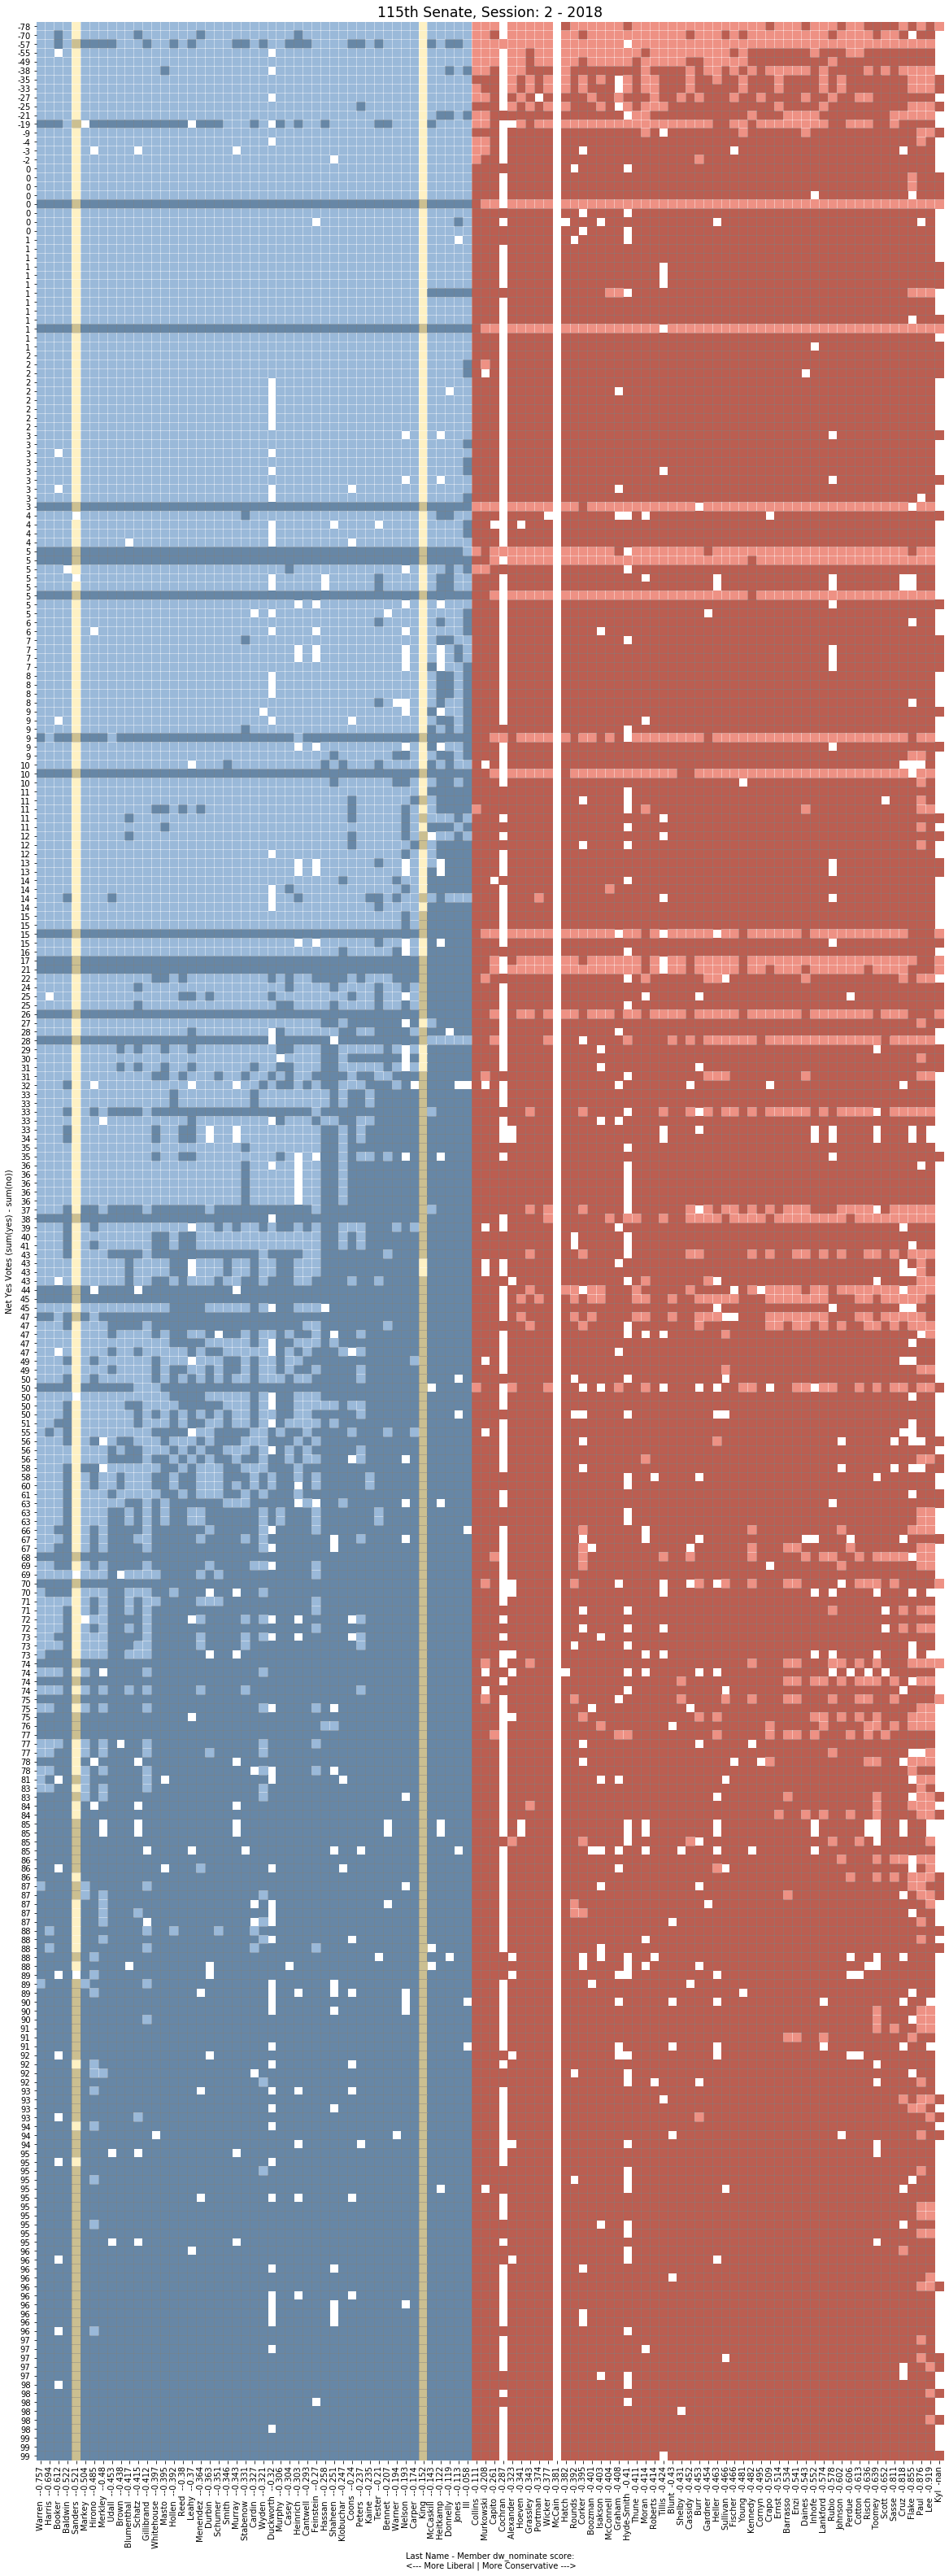

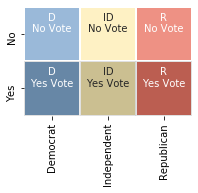

In [8]:
visualize_session(2018, 'Senate')

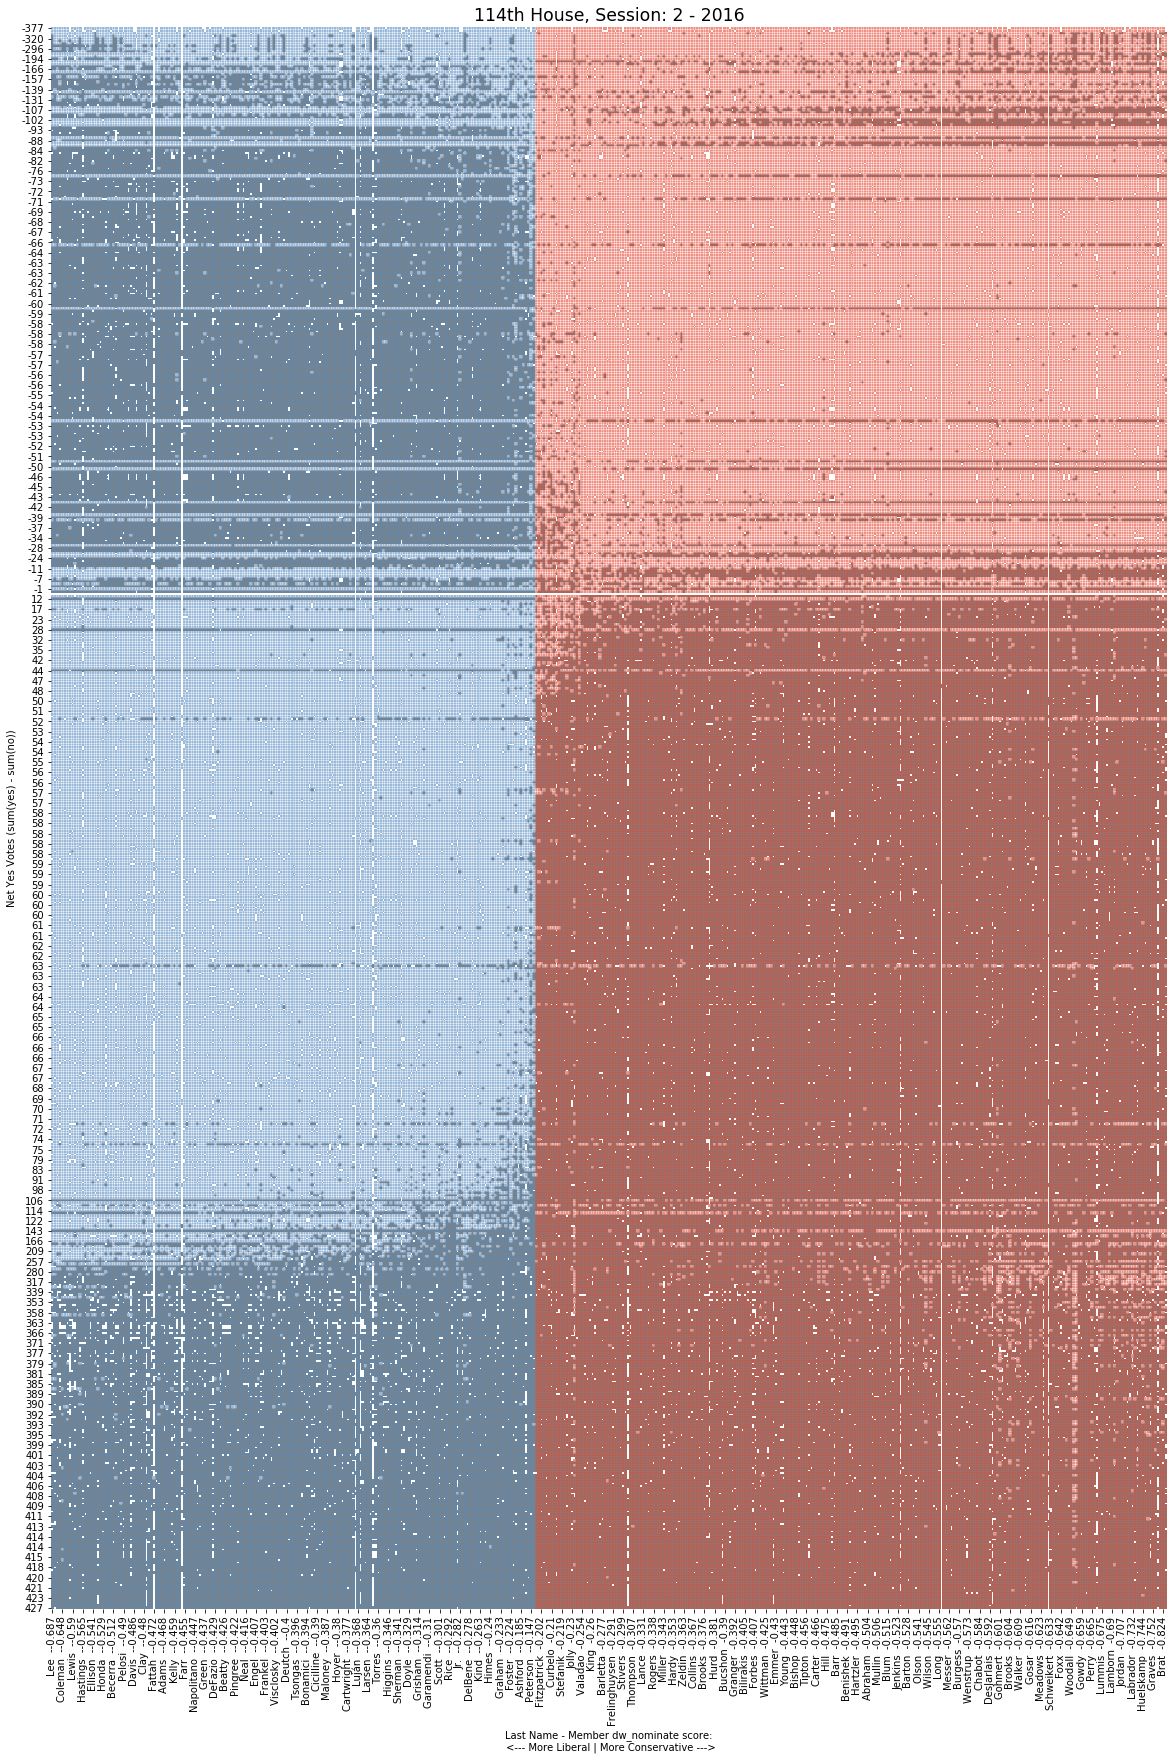

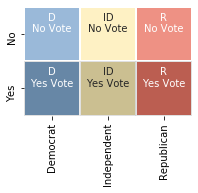

In [9]:
visualize_session(2016, 'house')

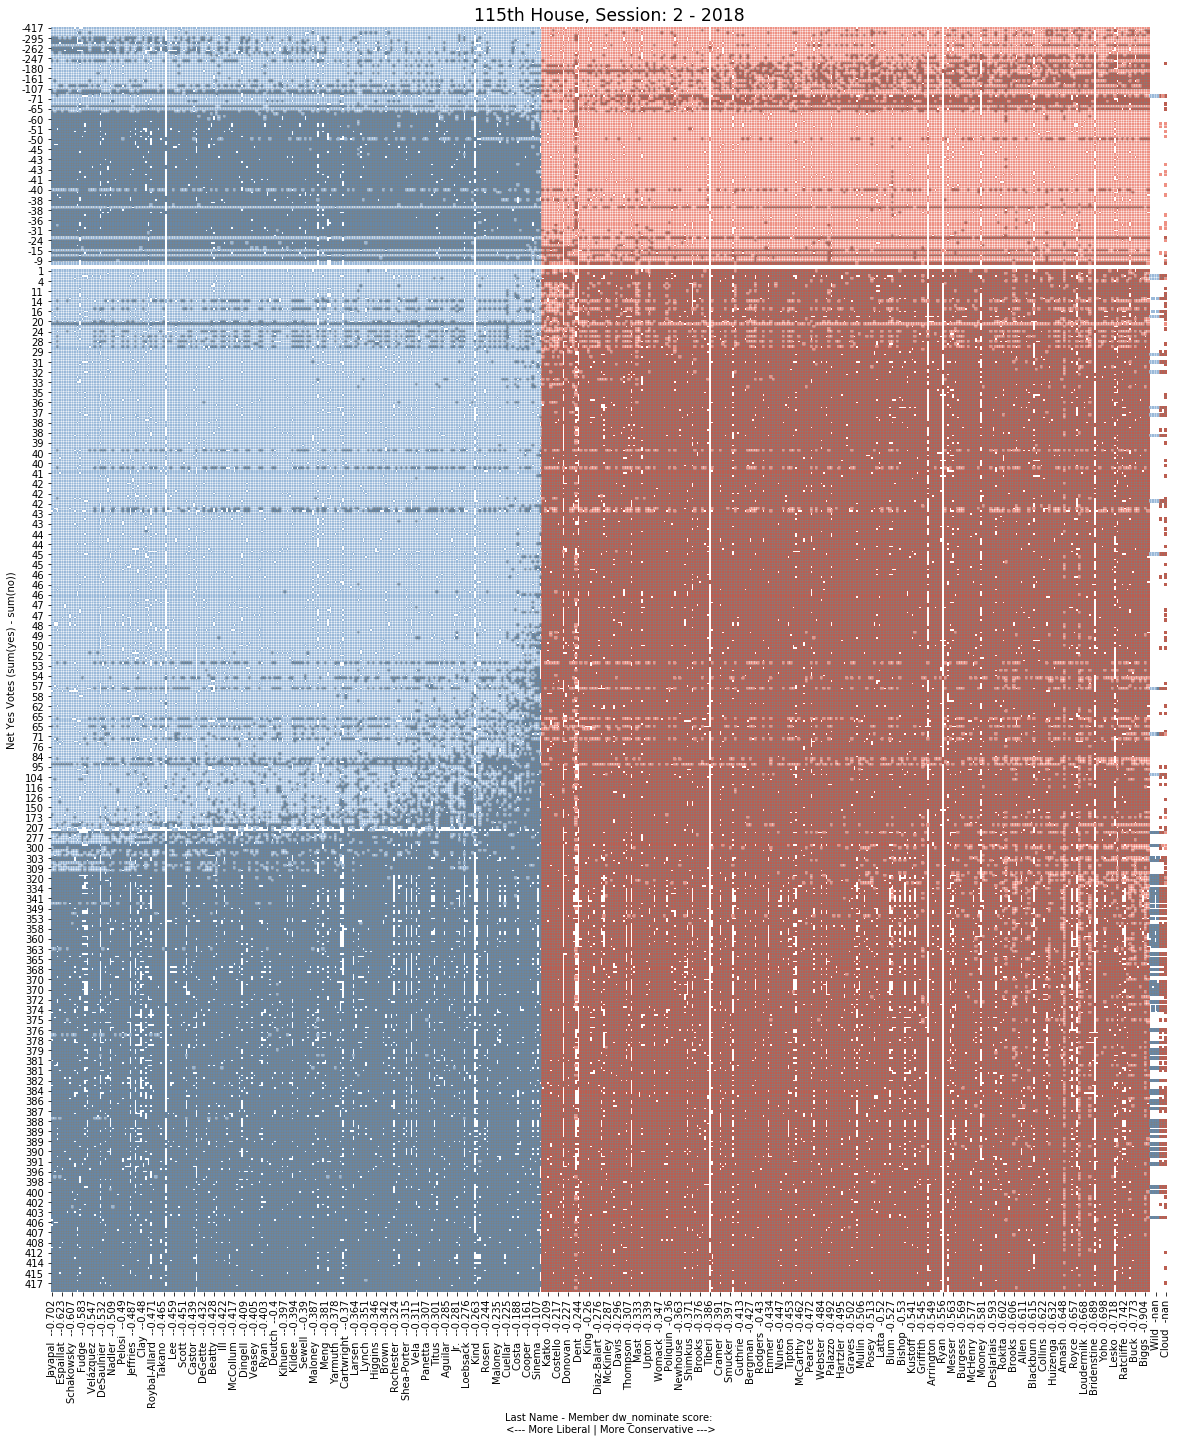

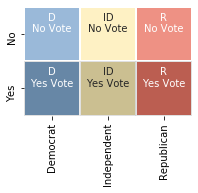

In [10]:
visualize_session(2018, 'House')

Cache out of date importing from API
importing house 2019 1 2 3 4 5 6 7 skip 8 9 skip 10 skip 11 skip 12 
saving 2019 house as Data/Cache/2019_housevote_meta.csv


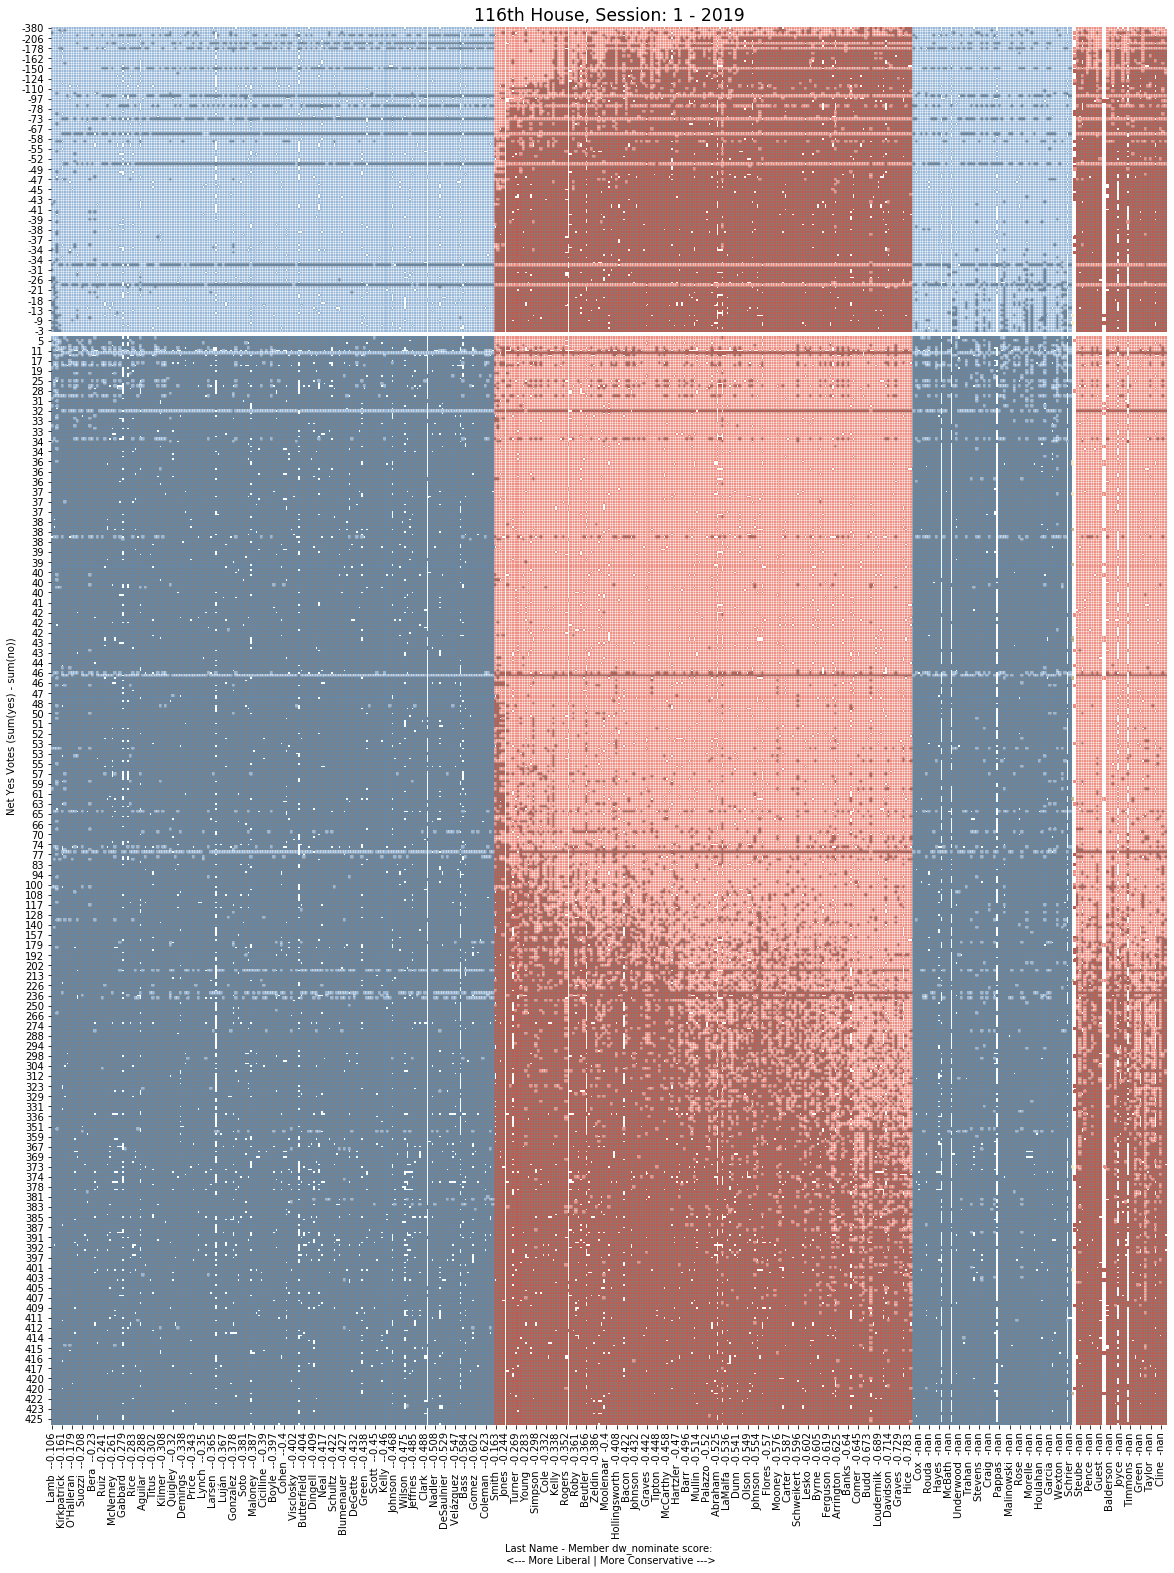

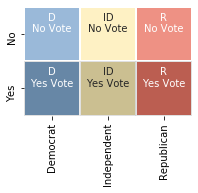

In [11]:
visualize_session(2019, 'house')

## Which members tend to survive?

In [12]:
meta, pos = load_cache(2019, 'Senate')
pos.columns.names

Cache out of date importing from API
importing Senate 2019 1 2 3 4 5 6 7 8 9 skip 10 skip 11 skip 12 
saving 2019 Senate as Data/Cache/2019_senatevote_meta.csv


FrozenList(['party', 'state', 'dw_nominate', 'member_id', 'name'])

In [13]:
#Create list of longest surviving candidates - query api directly

#get a list of memebers for a (doesn't include start end years)
#for date in range(2010,2019,2):
#    meta, pos = load_cache(date, 'Senate')
#    print(meta.index[0])
#    congress, chamber = meta.index[0][:2]
#    print(congress, chamber)
#    members = import_members(congress, chamber)
#    print(members[0])
#    for member in members:
#        print(member['last_name'])

#create a df (set? dictionary?) of senators with their first start and last end date. 
#initialize dictionary
def all_members(chamber):
    'get all members for a range of years'
    
    #initialize a dictionary
    membersdict = {}
    
    #for 20 years of dates
    for date in range(int(datetime.now().year),1998, -1):
        
        print('\nReqesting', date, chamber, end='')
        
        #load the meta and postions dataframes saved for that date
        meta, pos = load_cache(date, chamber)
        
        #extract the index.
        multi_index = pos.columns
    
        #loop through every item in the index
        for item in multi_index:
            
            #make a dictionary out of the index items and names
            indexdict = dict(zip(pos.columns.names, item))
            
            #extract the member_id from the index
            member_id = indexdict['member_id']
            
            #if the member id isn't in the dictionary already:
            if member_id not in membersdict.keys():
                
                #request the member info from the API
                m = get_member(member_id)
                
                #get a list of all the roles that member has had
                r = m['roles']
                
                #initialize a dictionary of that member's info
                mdict = {}
                
                #add info from the following list of keys to the dictionary
                for key in ['first_name', 'middle_name','last_name','current_party','in_office']:
                    mdict[key] = m[key]
                
                #add the start date of their first role and the end date of their last role -
                #NEED TO SEE IF THIS IS ALL IN THE SAME CHAMBER.
                #iterate through if the chamber matches, pick the last end date. 
                for roll in r:
                    if roll['chamber'].lower() == chamber:
                        mdict['end_date'] = roll['end_date']
                        break
                for roll in r:
                    if roll['chamber'].lower() == chamber:
                        mdict['start_date'] = roll['start_date']
                
                dw_nominate = indexdict.pop('dw_nominate')
                
                if dw_nominate != np.NaN: 
                    mdict['dw_nominate'] = dw_nominate
                
                #add info from the index dictionary
                mdict.update(indexdict) # some of these indicators change year to year... need to account
                
                #store that all in the main dictionary under the member_id - consider doing with items
                membersdict[member_id] = mdict
                #indicate we did something
                print('.', end='')
                
    #return the dictionary as a dataframe
    return pd.DataFrame(membersdict).transpose()

def load_members(chamber, force=False):
    chamber = chamber.lower()
    path = 'Data/Cache/memberinfo_{}.csv'.format(chamber)
    try:
        df = pd.read_csv(path)
        
        assert force == False, 'force'
    except (FileNotFoundError, AssertionError, KeyError) as e:
        print(e, 'importing from API')
        df = all_members(chamber)
        
        
        
        #save data frames as csv in data/csv directory
        print('saving as {}'.format(path))
        df.to_csv(path)
    
    #resolve years in office
    df.loc[:,'start_date'] = pd.to_datetime(df.loc[:,'start_date'])
    df.loc[:,'end_date'] = pd.to_datetime(df.loc[:,'end_date'])
    df['years_in_office'] = (df.loc[:,'end_date'] - df.loc[:,'start_date'])
    df.years_in_office = df.years_in_office.apply(lambda x: x.days / 365)
            
    return df

df = load_members('House', force=False)
df

Unnamed: 0 current_party  district  dw_nominate   end_date first_name  \
0       A000374             R         5        0.514 2021-01-03      Ralph   
1       A000370             D        12       -0.469 2021-01-03       Alma   
2       A000055             R         4        0.364 2021-01-03     Robert   
3       A000371             D        31       -0.287 2021-01-03       Pete   
4       A000372             R        12        0.639 2021-01-03       Rick   
5       A000376             D        32          NaN 2021-01-03      Colin   
6       A000367             R         3        0.640 2021-01-03     Justin   
7       A000369             R         2        0.382 2021-01-03       Mark   
8       A000377             R         1          NaN 2021-01-03      Kelly   
9       A000375             R        19        0.522 2021-01-03      Jodey   
10      A000378             D         3          NaN 2021-01-03    Cynthia   
11      B001291             R        36        0.707 2021-01-03      Brian   
12      B001298             R         2        0.411 2021-01-03        Don   
13      B001307             R         4          NaN 2021-01-03      James   
14      B001306             R        12          NaN 2021-01-03       Troy   
15      B001299             R         3        0.665 2021-01-03        Jim   
16      B001282             R         6        0.496 2021-01-03       Andy   
17      B001300             D        44       -0.508 2021-01-03    Nanette   
18      B001270             D        37       -0.587 2021-01-03      Karen   
19      B001281             D         3       -0.428 2021-01-03      Joyce   
20      B001287             D         7       -0.229 2021-01-03        Ami   
21      B001301             R         1        0.455 2021-01-03       Jack   
22      B001292             D         8       -0.387 2021-01-03     Donald   
23      B001302             R         5        0.904 2021-01-03       Andy   
24      B001257             R        12        0.405 2021-01-03        Gus   
25      B000490             D         2       -0.281 2021-01-03    Sanford   
26      B001250             R         1        0.530 2021-01-03        Rob   
27      B000574             D         3       -0.427 2021-01-03       Earl   
28      B001303             D         1       -0.325 2021-01-03       Lisa   
29      B001278             D         1       -0.392 2021-01-03    Suzanne   
...         ...           ...       ...          ...        ...        ...   
1095    D000312           NaN         4          NaN 2001-01-03        Jay   
1096    D000373           NaN        32          NaN 2000-12-08     Julian   
1097    E000282           NaN        15          NaN 2001-01-03     Thomas   
1098    F000257           NaN         1          NaN 2001-01-03    Michael   
1099    F000328           NaN         4          NaN 2001-01-03     Tillie   
1100    F000349           NaN         7          NaN 2001-01-03        Bob   
1101    G000120           NaN         2          NaN 2001-01-03        Sam   
1102    G000291           NaN        19          NaN 2001-01-03    William   
1103    H000605           NaN         1          NaN 2001-01-03       Rick   
1104    K000016           NaN        12          NaN 2001-01-03       John   
1105    K000270           NaN         4          NaN 2001-01-03        Ron   
1106    K000357           NaN        36          NaN 2001-01-03     Steven   
1107    L000155           NaN         2          NaN 2001-01-03       Rick   
1108    M000206           NaN        31          NaN 2001-01-03    Matthew   
1109    M000350           NaN         8          NaN 2001-01-03       Bill   
1110    M000481           NaN         2          NaN 2001-01-03      David   
1111    M000669           NaN         2          NaN 2001-01-03       Jack   
1112    M000795           NaN         2          NaN 2001-01-03      David   
1113    P000005           NaN        48          NaN 2001-01-03        Ron   
1114    P000171           N

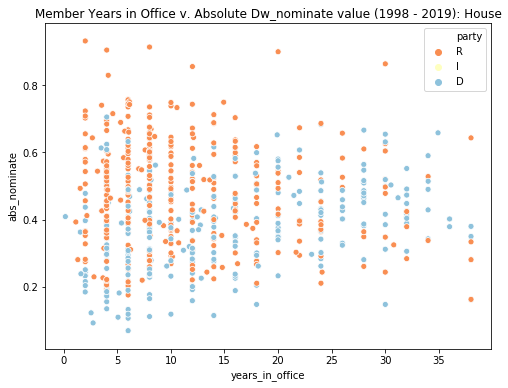

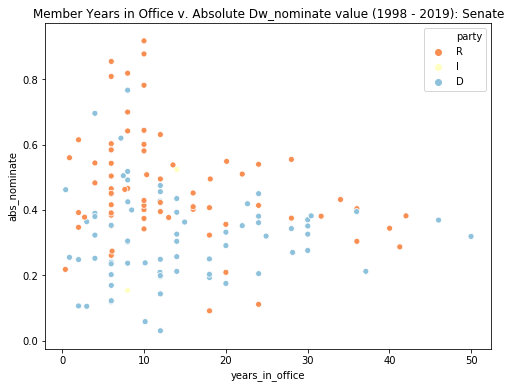

In [14]:
def years_nominate(df):

    #df.loc[:,'start_date'] = pd.to_datetime(df.loc[:,'start_date'])
    #df.loc[:,'end_date'] = pd.to_datetime(df.loc[:,'end_date'])
    #df['years_in_office'] = (df.loc[:,'end_date'] - df.loc[:,'start_date'])
    #df.years_in_office = df.years_in_office.apply(lambda x: x.days / 365)


    df['abs_nominate'] = abs(df['dw_nominate'])
    df.party = df.party.apply(lambda x: 'I' if x == 'ID' else x)
    f, ax, = plt.subplots(1,1, figsize=(8,6))
    palette = sns.color_palette('RdYlBu',3)
    sns.scatterplot('years_in_office','abs_nominate', hue='party', hue_order=['R','I','D'],
            data=df, ax=ax, palette=palette)
    return ax
    
housedf = load_members('House')
senatedf = load_members('Senate')

ax1 = years_nominate(housedf)
ax2 = years_nominate(senatedf)

titlestr = 'Member Years in Office v. Absolute Dw_nominate value (1998 - 2019): '
ax1.set_title(titlestr+'House')
ax2.set_title(titlestr+'Senate')

plt.show()

There are several possible ways to define survival in office depending on the objective. A political party might be interested in whether a seat switched parties, while a given member is most likely interested in their individual chances of continuing on to the next session. In this case, we'll focus on total number of years in office.

There appears to be a definitive trend, of longer lasting members being more toward the center of their respective side of the political spectrum.  In the Senate, dw_nominate scores appear to approach .37 distance from 0 as years in office increase. In the House, scores appear to converge toward .5 distance from 0 as years in office increase. It appears that there are more Republicans with extreme dw_nominate scores that last longer.



### Hypothesis: Members more in line with the party preferences of their district survive longer.

In [15]:
statelean = pd.read_csv('Data/fivethirtyeight_partisan_lean_STATES.csv')
distlean = pd.read_csv('Data/fivethirtyeight_partisan_lean_DISTRICTS.csv')

In [16]:
def process_lean(x):
    '''convert 538 lean into something easier to merge with other data'''
    party, lean = x.split('+')
    lean = float(lean)/100
    if party == 'R':
        return lean
    if party == 'D':
        return -lean


statelean['lean'] = statelean.pvi_538.apply(process_lean)
statelean.head()

state pvi_538  lean
0     Alabama    R+27  0.27
1      Alaska    R+15  0.15
2     Arizona     R+9  0.09
3    Arkansas    R+24  0.24
4  California    D+24 -0.24

In [17]:
distlean['lean'] = distlean.pvi_538.apply(process_lean)
distlean.head()

district  pvi_538    lean
0     AK-1  R+15.21  0.1521
1     AL-1  R+28.61  0.2861
2     AL-2  R+30.97  0.3097
3     AL-3  R+31.37  0.3137
4     AL-4  R+59.81  0.5981

In [18]:
distlean['state'] = distlean['district'].apply(lambda x: x.split('-')[0])
distlean['district'] = distlean['district'].apply(lambda x: int(x.split('-')[1]))
distlean.head()

district  pvi_538    lean state
0         1  R+15.21  0.1521    AK
1         1  R+28.61  0.2861    AL
2         2  R+30.97  0.3097    AL
3         3  R+31.37  0.3137    AL
4         4  R+59.81  0.5981    AL

In [19]:
#query 
CA1 = distlean.loc[:,'state'] == 'CA'
D1 = distlean.loc[:,'district'] == 1
CA1 = CA1 & D1
distlean.loc[CA1]


district  pvi_538    lean state
21         1  R+22.53  0.2253    CA

In [20]:
statelean['statename'] = statelean['state']
statelean['state'] = set(distlean.state)

In [21]:
#match state codes
stateacr = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI',
            'ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI',
            'MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC',
            'ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT',
            'VT','VA','WA','WV','WI','WY']

statelean['state'] = stateacr
#list of states that need to be swapped. 
#AR-AZ, IA-ID-IL-IN, 

statelean.head()

state pvi_538  lean   statename
0    AL    R+27  0.27     Alabama
1    AK    R+15  0.15      Alaska
2    AZ     R+9  0.09     Arizona
3    AR    R+24  0.24    Arkansas
4    CA    D+24 -0.24  California

In [22]:
#import and format historical lean by state
statelean_hist = pd.read_csv('Data/Output/state_pres_leg_lean.csv').loc[:,['year','state_po','compound_lean']]
statelean_hist.columns = ['year','state','lean']

statelean_hist.loc[statelean_hist.year == 2016].head()

year state      lean
153  2016    AK  0.169381
154  2016    AL       NaN
155  2016    AR  0.224409
156  2016    AZ  0.085514
157  2016    CA -0.264436

FiveThirtyEight partisan lean is created by combining the 2016 election and averaging it with the results of the 2012 presidential election and the 2016 state level elections weighted at 50%, 25%, and 25% respectively. This has been duplicated from 2004 to 2016 in the historical_partisan_lean notebook


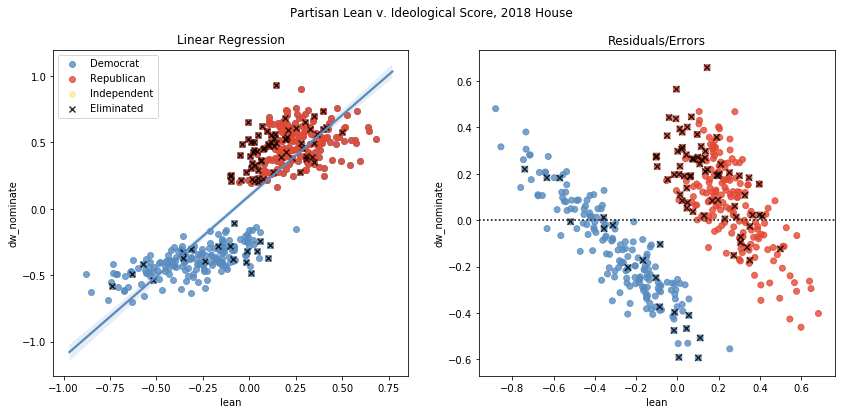

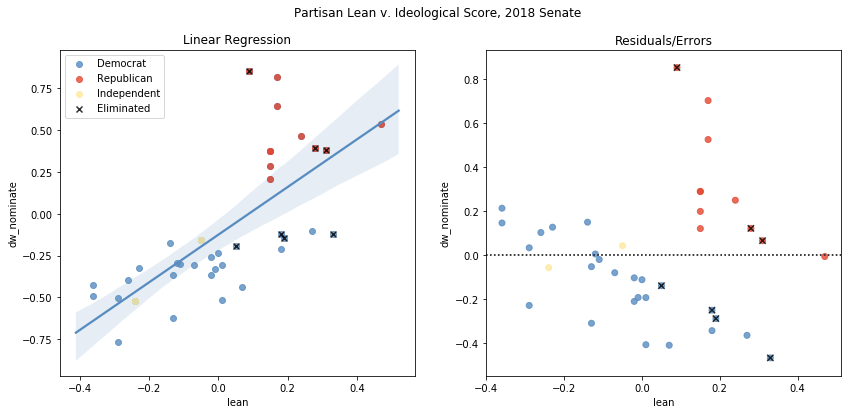

Unnamed: 0 current_party  dw_nominate   end_date   first_name  in_office  \
0    J000300             D       -0.105 2021-01-03         Doug       True   
1    M001169             D       -0.302 2021-01-03  Christopher       True   
2    C000174             D       -0.175 2021-01-03       Thomas       True   
3    H001042             D       -0.492 2021-01-03        Mazie       True   
4    S001194             D       -0.425 2021-01-03        Brian       True   

  last_name member_id middle_name                   name party start_date  \
0     Jones   J000300         NaN             Doug Jones     D 2018-01-03   
1    Murphy   M001169          S.  Christopher S. Murphy     D 2013-01-03   
2    Carper   C000174          R.       Thomas R. Carper     D 2001-01-03   
3    Hirono   H001042          K.        Mazie K. Hirono     D 2013-01-03   
4    Schatz   S001194         NaN           Brian Schatz     D 2012-12-27   

  state  years_in_office  abs_nominate pvi_538  lean    statename  ded  
0    AL         3.002740         0.105    R+27  0.27      Alabama    0  
1    CT         8.005479         0.302    D+11 -0.11  Connecticut    0  
2    DE        20.013699         0.175    D+14 -0.14     Delaware    0  
3    HI         8.005479         0.492    D+36 -0.36       Hawaii    0  
4    HI         8.024658         0.425    D+36 -0.36       Hawaii    0

In [23]:
from matplotlib.colors import ListedColormap

def lean_dw(df, lean, y='dw_nominate', order=1, year=2018, debug=False):
    
    
    
    #find out if were' merging house or sentate data
    if 'district' in df.columns:
        on = ['state', 'district']
        chamber = 'House'
        elec_year = [(year+1 - x.year)%2 == 0 for x in df.start_date]
    else:
        on = 'state'
        chamber = 'Senate'
        #restrict to members who should be facing election based on start year - this might not work
        elec_year = [(year+1 - x.year)%6 < 2 for x in df.start_date]
    
    #cut down df to members by start and end date
    endafter = [x.year >= year for x in df.end_date]
    startbefore = [x.year <= year for x in df.start_date]
    session = [all(x) for x in zip(endafter, startbefore, elec_year)]
    
    #merge lean in with the given session
    data = pd.merge(df.loc[session], lean, on=on, how='left')
    
    #debug
    if debug == True:
        print(data.tail())

    
    #drop nans for dw_nominate and lean
    data.dropna(subset=[y, 'lean'], inplace=True)

    #store the location of the candidates that didn't move on 
    ded = [(x.year == year+1 and x.month == 1) for x in data.end_date]
    #ded = [(x.year <= year+1) for x in data.end_date]
    #create a list of sizes to mark candidates that didn't survive
    data['ded'] = [int(x)*40 for x in ded]

    data = plot_lean_dw(data, y=y, order=order, chamber=chamber, year=year)
    return data
    
def plot_lean_dw(data, y='dw_nominate', order=1, chamber='Senate', year='2006-2018'):
    #create a dataframe of locations for candidates that didn't survive
    deddata = data.loc[data.ded != 0,:]


    
    #define color palette
    palette = sns.color_palette('RdYlBu', 6) 
    cmap = ListedColormap(sns.color_palette('RdYlBu_r'))
    partydict = defaultdict(float)
    partydict['R'], partydict['D'] = 1, -1
    colormap = [partydict[x] for x in data.party]
    colormap = np.array(colormap)
    
    # create boolean list of republican candidates with matching size list to mark party colors
    R = [x == 'R' for x in data.party]
    D = [x == 'D' for x in data.party]
    I = [(x == 'I' or x == 'ID') for x in data.party]
    
    #create a dataframe of republicans and democrats
    Rdata = data[R]
    Ddata = data[D]
    Idata = data[I]

    #Plot regression
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
    sns.regplot('lean',y, data=data, ax=ax1, color=palette[5], label='Democrat', order=order )
    sns.regplot('lean',y, data=Rdata, color=palette[0], fit_reg=False, ax=ax1, label='Republican', order=order)
    sns.regplot('lean',y, data=Idata, color=palette[2], fit_reg=False, ax=ax1, label='Independent', order=order)    
    sns.regplot('lean',y, data=deddata, ax=ax1, fit_reg=False, marker='x', color='black', label='Eliminated')

    #plot residuals - use cmap, but keep using lables above for easy legend.
    sns.residplot('lean', y, data=data, ax=ax2, order=order, scatter_kws=dict(c=colormap, cmap=cmap, color=None))
    sns.residplot('lean', y, data=data, ax=ax2, order=order, scatter_kws=dict(s=data.ded, color='black', marker='x'))

    #set up plot titles 
    ax1.set_title('Linear Regression')
    ax2.set_title('Residuals/Errors')

    #set up figure title
    f.suptitle('Partisan Lean v. Ideological Score, {} {}'.format(year, chamber))
    
    #set up legend and show
    ax1.legend()
    plt.show()
    
    #return the dataframe
    return data

house_data = lean_dw(housedf, distlean)
senate_data = lean_dw(senatedf, statelean)
senate_data.head()



for the 2018 mid terms, FiveThirtyEight compiled partisan lean scores on both state and voting district levels, using totals from the previous two elections.

For the congress in 2018, a significant relationship exists between the partisan lean of a given district or state, and the ideological score of the congressional member there. However, the relationship is not linear. Both parties are less moderate than district lean would predict by linear regression in swing districts/states, and less extreme than district lean would predict in highly partisan areas. In the residual plots on the right, members who are the most out of line with what is predicted by partisan lean are toward the upper and lower ends of the plot.   

Members who did not survive the midterms, defined here as having their last day in congress in January of 2019, are marked with an "x." It appears that those members most out of line with their district lean have been eliminated more frequently, however those more extreme than predicted, seem to be eliminated with more frequency than those more moderate than predicted.

Note that in the Senate, this plot does not take into account which members stood for re-election.



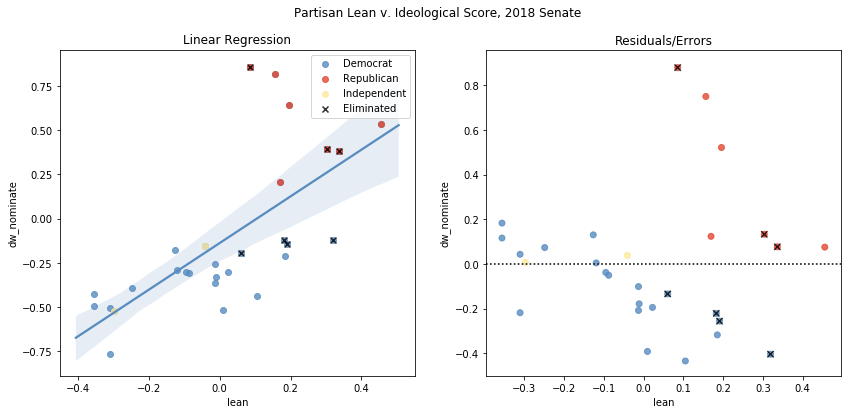

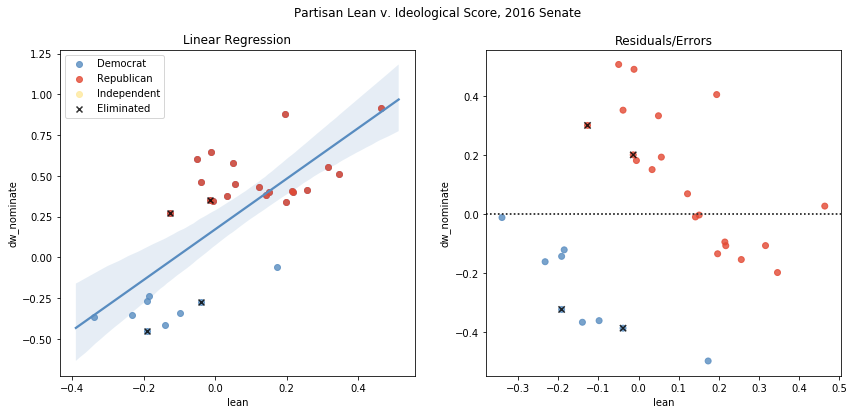

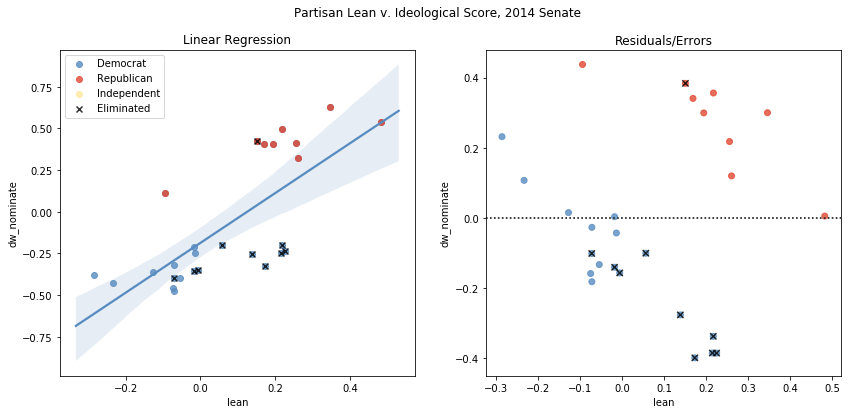

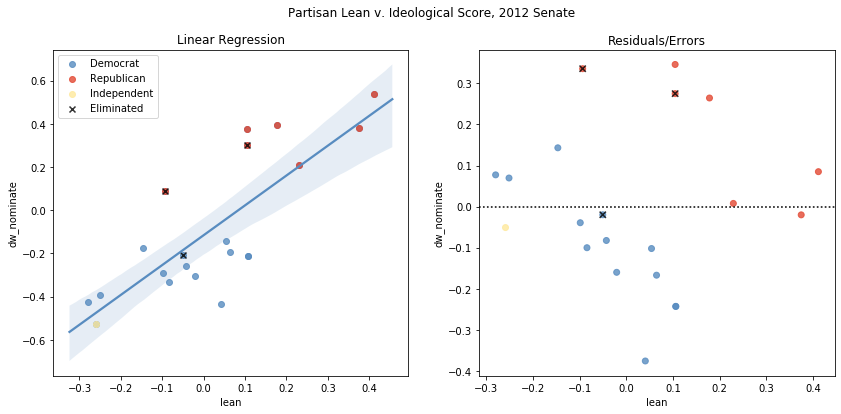

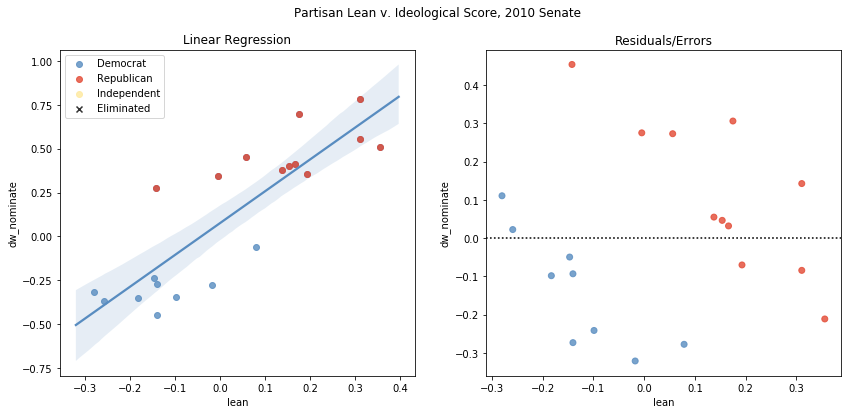

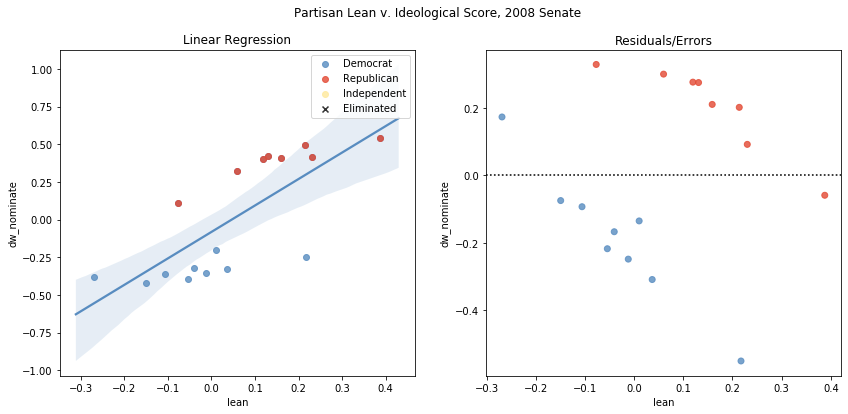

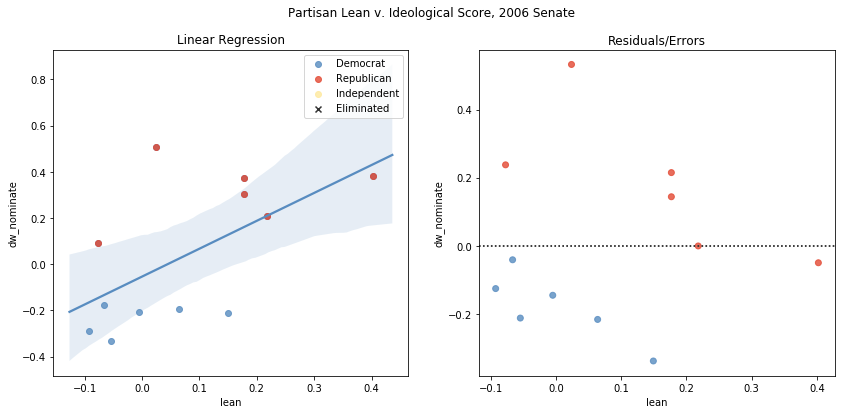

In [24]:
#Historical Senate Plots
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2016], year = 2018)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2012], year = 2016)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2012], year = 2014)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2008], year = 2012)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2008], year = 2010)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2004], year = 2008)
_ = lean_dw(senatedf, statelean_hist.loc[statelean_hist.year == 2004], year = 2006)


It appears the data does not have have dw_nominate values for senators eliminated before 2010. Perhaps we can fix this be rolling our own dw_nominate

## Machine Learning

In [25]:
# try unsupervised real quick, and if it doesn't work,
#https://github.com/Nhorning/clustering/blob/master/Mini_Project_Clustering.ipynb
    # you can just feed it through these functions.
    # remember, one way you can reduce dimentionality is to cut everything down to the interesting bit by the curve.

# move on to trying to predict chance of loss for a given set of votes.

#look at the 

IN EDA ideological scores have been calculated using "dw_nominate", a multi-dimensional scaling method, developed in the 80's, and already included in the dataset. Congressional voting records are interpreted along two dimensions, the first being liberal vs. conservative, and the second usually corresponding to social values.  Let's see if we can "roll our own" dw_nominate scores.

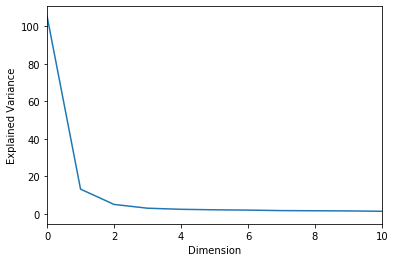

In [26]:
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA 

#load votes for a session
_, votes = load_cache(2018, 'Senate')

#factorize 
votes = my_factorize(votes)

#convert into numpy array
x_cols = votes.transpose().values

#reduce dimensions with PCA
pca = PCA()
pca.fit(x_cols)

#plot explained variance of first 10 PCA features
plt.plot(pca.explained_variance_)
plt.xlim(0,10)
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.show()

Explained variance can be used to determine the optimal number of dimensions to used to evaluate a model. 

According to the plot, the most of the variation in the model is explained by component '0' with component '1' providing much less, but probably enough to be useful, and component '2' providing even less than that. This means it is likely possible to interpret results in 2 dimensions quite easily, with 3 dimensions looking unnecessary (but at least possible to visualize). 

This is consistent with the approach used by "dw_nominate."  

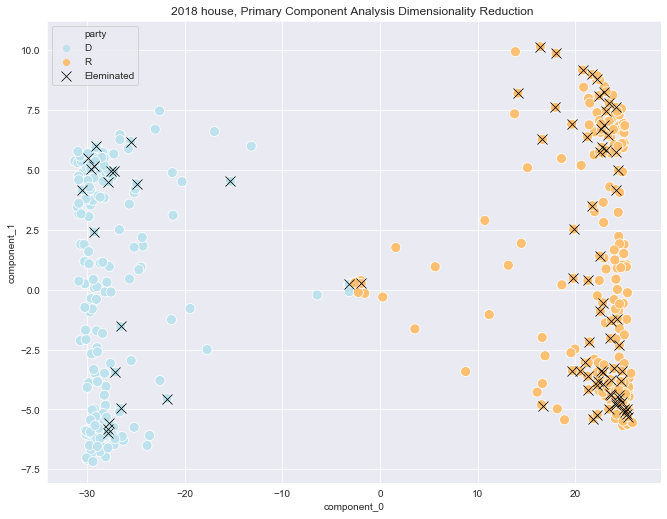

In [27]:
from sklearn.cluster import KMeans

def plot_reduced(chamber, year, n_clusters=1, clusterer=KMeans, party=None,):
    '''for a given year and chamber load votes from cache, reduce the dimensions, plot it in two, \
    return a reduced DataFrame for further analysis'''
    #modify this to point out that id consistenlty identifies the parties

    #load a congress 
    assert year%2 == 0, 'only election years please'
    _, votes = load_cache(year, chamber)
    _, votes_r = load_cache(year-1, chamber) #get previous session votes and concat
    
    lst = [votes_r,votes]
    
    for df in lst:
        df.columns = df.columns.droplevel('dw_nominate')
        
    votes = pd.concat(lst)

    #assert len(votes.columns) < 550, 'error combining sessions: too many columns'
    
    if party:
        fltr = [x[0] == party for x in votes.columns]
        votes = votes.loc[:,fltr]
    
    #factorize and sort the data
    votes = my_factorize(votes)

    #store member columns as a numpy matrix
    x_cols = votes.transpose().values

    #instantiate PCA model
    pca = PCA()

    #fit model to x_cols
    pca.fit(x_cols)

    #transform data based on model
    pca_features = pca.transform(x_cols)

    #set number of clusters for easy adjusment
    #n_clusters=2

    if clusterer:#divide dataset into clusters based on number
        clusterer = clusterer(n_clusters=n_clusters, random_state=38)
        cluster_labels = clusterer.fit_predict(x_cols)

    #create reduced dataframe
    reduced_df = pd.DataFrame(
    {'member_id':votes.columns.get_level_values('member_id'),
     'name':votes.columns.get_level_values('name'),
     'cluster_id':cluster_labels,
     'component_0':pca_features[:,0],
     'component_1':pca_features[:,1]})
    

    #merge dataframe with member info - using nifty API functions
    memberdf = load_members(chamber)
    reduced_df = pd.merge(reduced_df, memberdf, on='member_id') 
    
    #make sure R is on the right and D on the left of component_0
    filt = reduced_df.component_0 == reduced_df.component_0.max() 
    if reduced_df.loc[filt,'party'].iloc[0] == 'D':
        reduced_df['component_0'] = 0 - reduced_df.loc[:,'component_0']

    #find who was eliminated the following year
    ded = [(x.year == year+1 and x.month == 1) for x in reduced_df.end_date]

    #plot data
    sns.set_style('darkgrid')
    f, ax = plt.subplots(1,1, figsize=(11,8.5))
    
    if n_clusters > 1:
        n_colors = n_clusters
        hue = 'cluster_id'
    else:
        n_colors = len(reduced_df.party.unique())
        hue = 'party'
        
    color = sns.color_palette('RdYlBu_r', n_colors=n_colors)
    #sns.scatterplot('x', 'y', data=reduced_df, hue='cluster_id', palette=color) # for automatic party detection
    sns.scatterplot('component_0', 'component_1', data=reduced_df, hue=hue , palette=color, s=100) 
    sns.scatterplot('component_0', 'component_1', data=reduced_df[ded], marker='x', color='black', label='Eleminated', s=100)
    
    ax.legend()
    ax.set_title('{} {}, Primary Component Analysis Dimensionality Reduction '.format(str(year), chamber,))
   
    plt.show()
    #return dataframe
    return reduced_df

#test run
house_reduced = plot_reduced('house', 2018)#, party='D') 


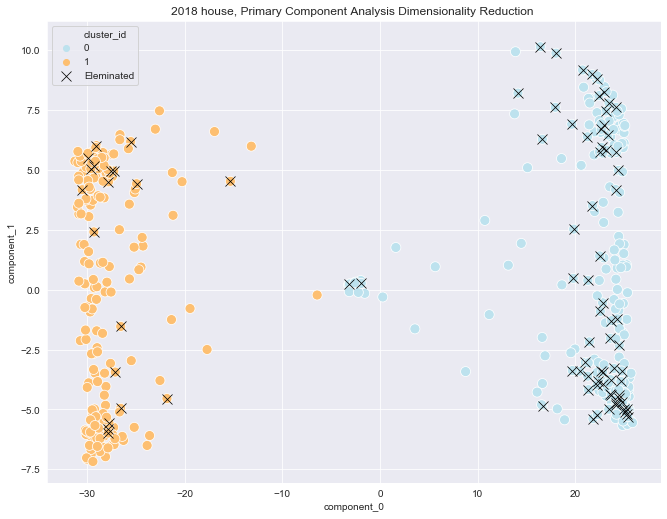

In [28]:
house_reduced = plot_reduced('house', 2018, n_clusters = 2)
plt.show()

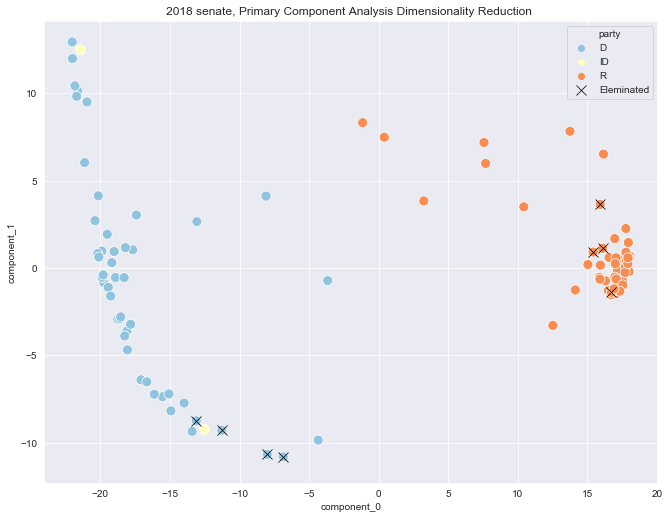

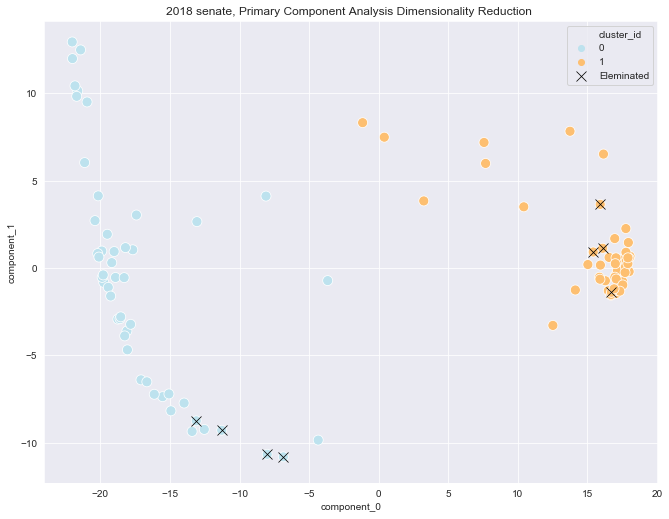

In [29]:
senate_reduced = plot_reduced('senate', 2018)
senate_reduced = plot_reduced('senate', 2018, n_clusters=2)#, party='D')
plt.show()

Unsupervised clustering can easily distinguish the two parties, based on their voting behavior without needing to label the differences ahead of time, based on the on just one congress. It is is interesting that the senators eliminated seem to be grouped fairly close together ideologically in 2018


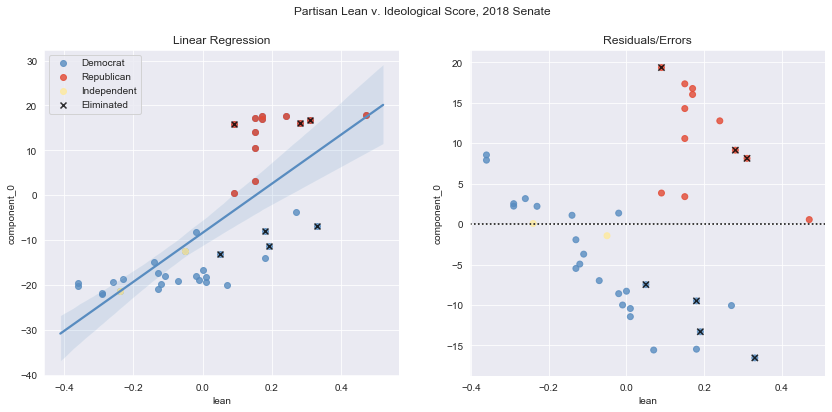

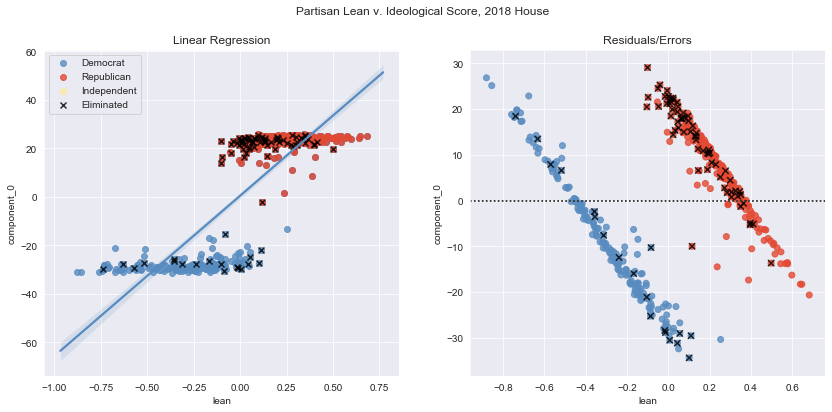

In [30]:
#flip axis around
#senate_reduced['component_0'] = 0 - senate_reduced.loc[:,'component_0']

#plot the regression
senate_data = lean_dw(senate_reduced, statelean, y='component_0')

#flip axis around
#house_reduced['component_0'] = 0 - house_reduced.loc[:,'component_0']

house_data = lean_dw(house_reduced, distlean, y='component_0')

It appears that primary "component 0" may also be a predictor of a members chances of being eliminated, when combined with the district lean.

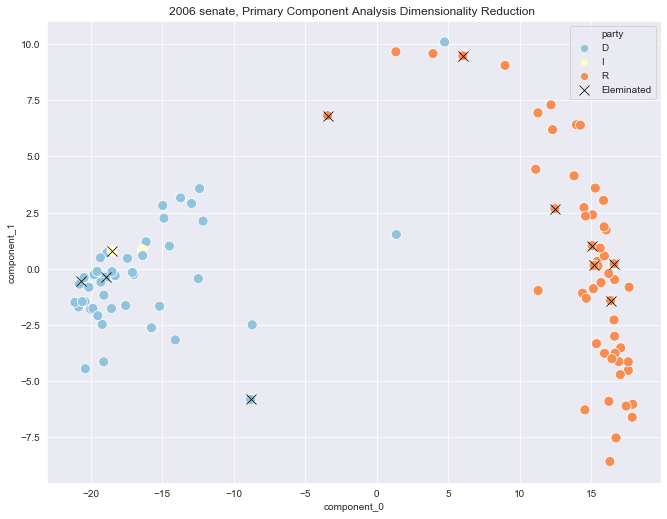

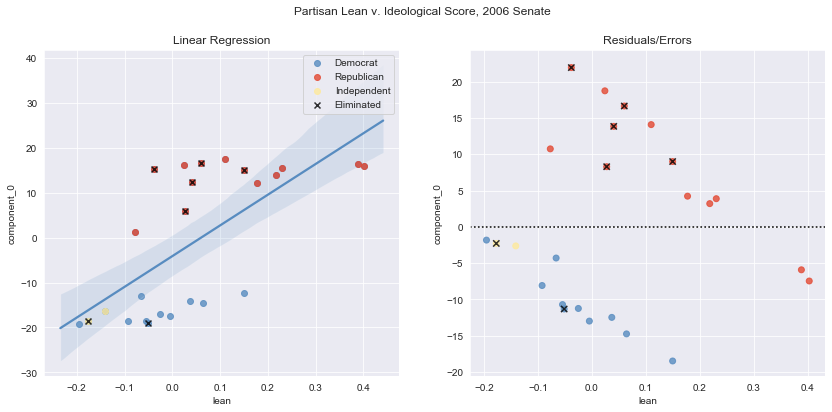

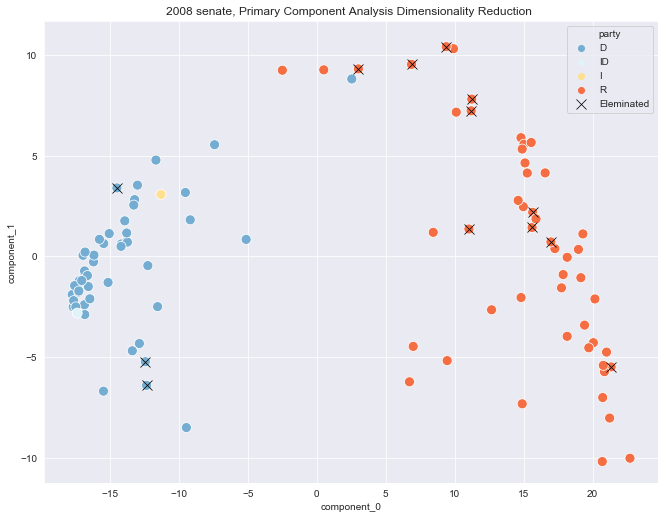

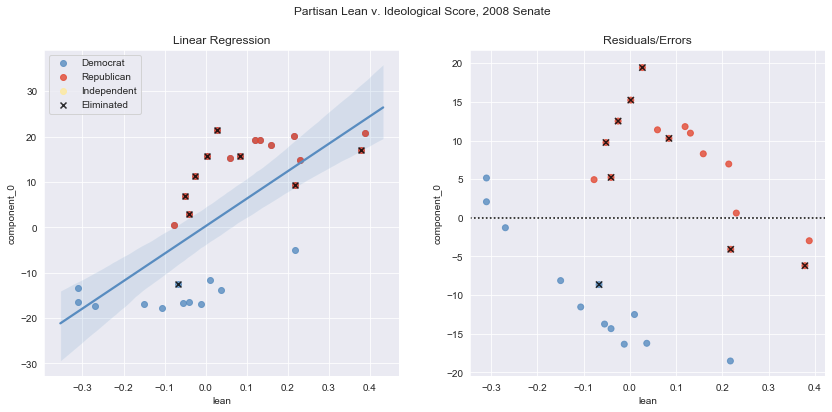

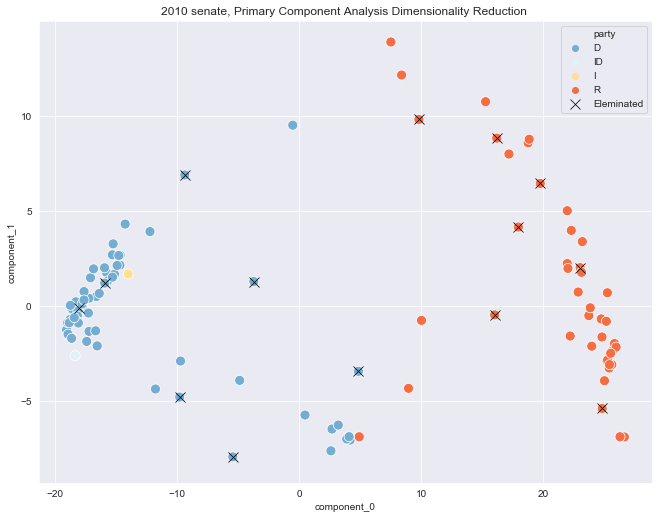

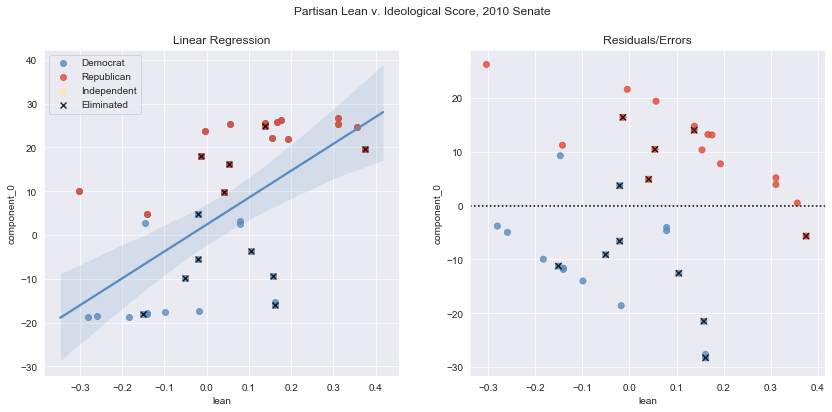

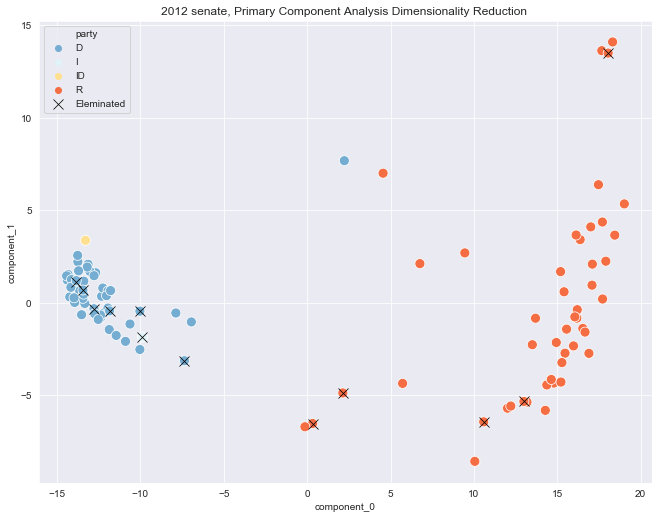

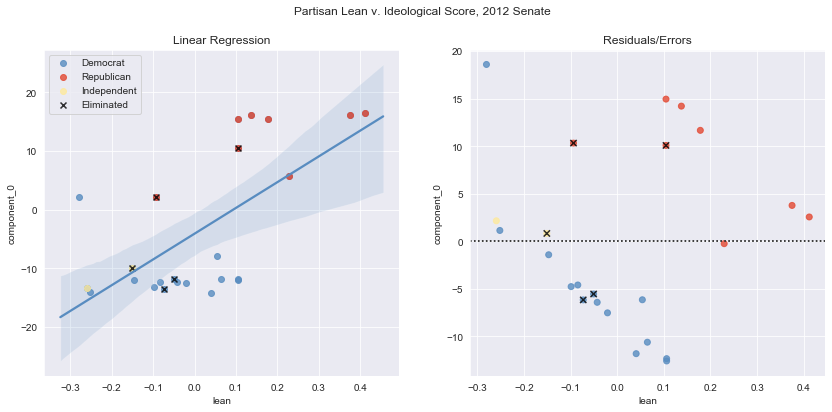

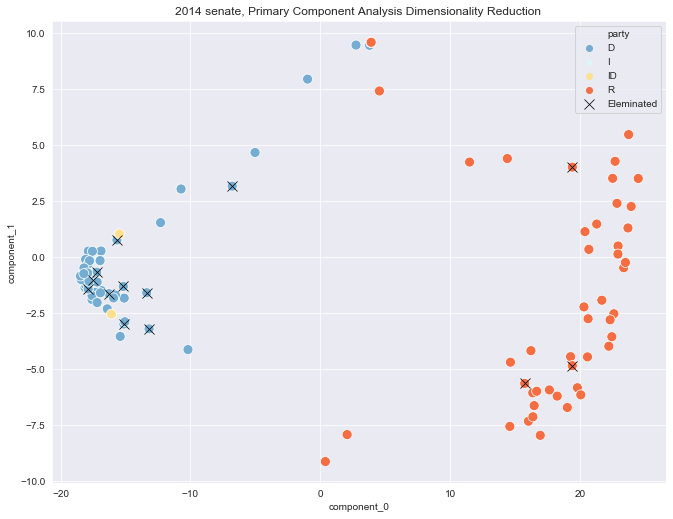

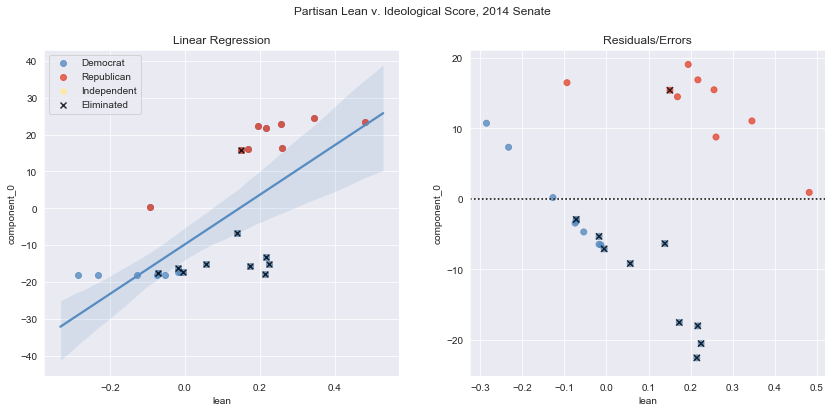

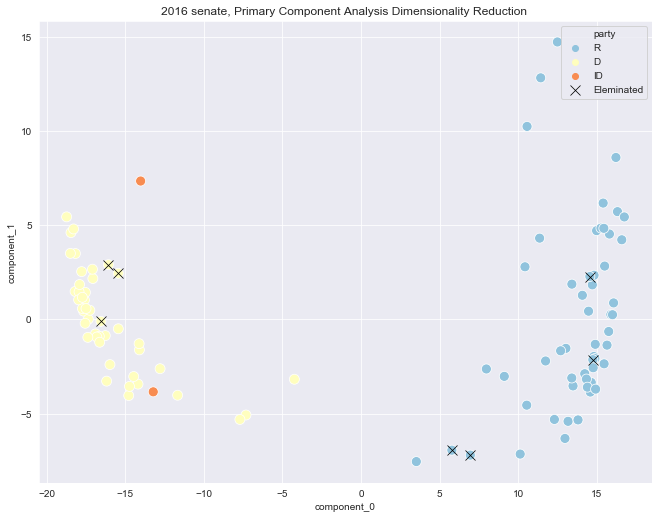

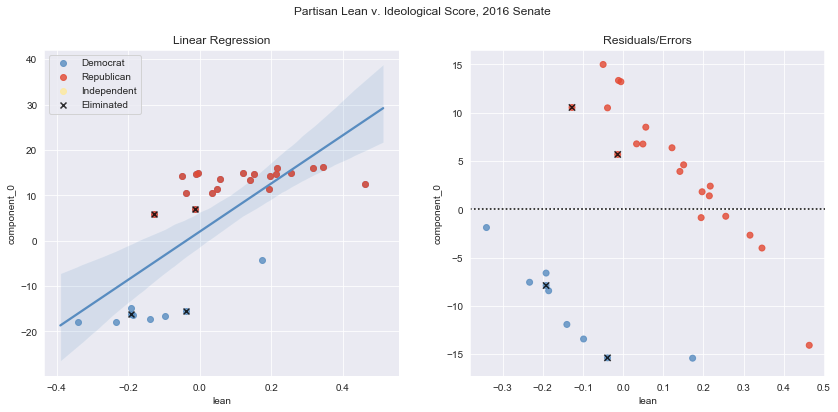

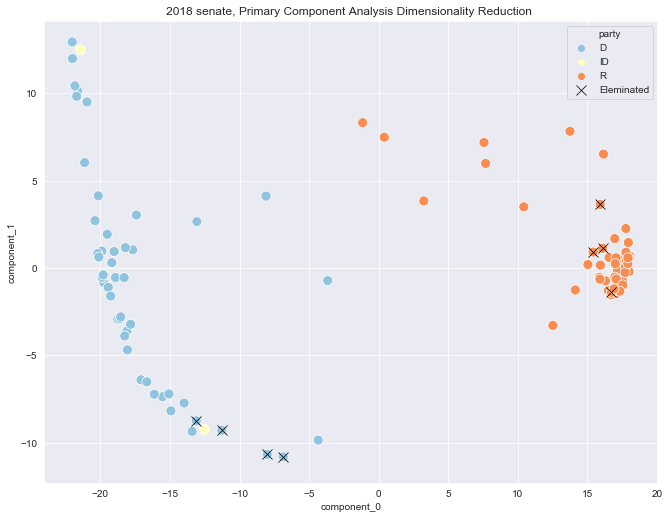

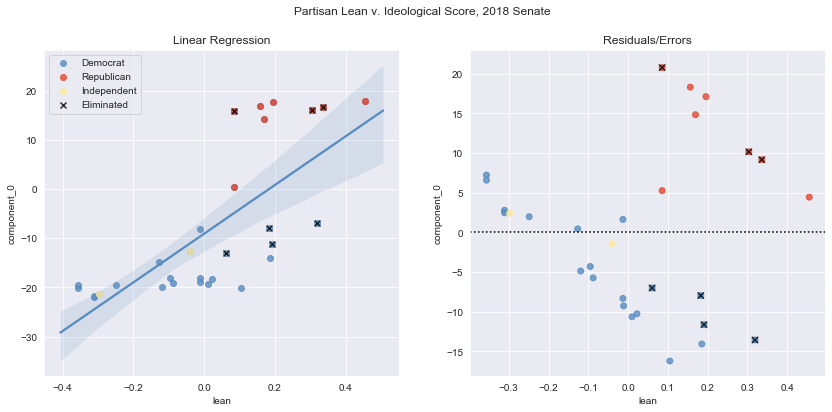

In [31]:
##fuction to plot sentate years.
def plot_senate_hist(year):
    
    #determine year to grab lean from
    for x in range(2004,2020,4):
        if year-4 <= x < year:
            lean_year = x

    senate_reduced = plot_reduced('senate', year)
    #flip axis around, so that R is on Right and L is on left.
    filt = senate_reduced.component_0 == senate_reduced.component_0.max()
    if senate_reduced.loc[filt,'party'].iloc[0] == 'D':
        senate_reduced['component_0'] = 0 - senate_reduced.loc[:,'component_0']
        
    #plot regression
    data = lean_dw(senate_reduced, statelean_hist.loc[statelean_hist.year == lean_year], y='component_0', year = year)
    return data

senate_hist_reduced = pd.DataFrame()
for year in range(2006, 2019,2):
    data = plot_senate_hist(year)
    senate_hist_reduced = pd.concat([senate_hist_reduced,data])
senate_hist_reduced.reset_index(inplace=True)

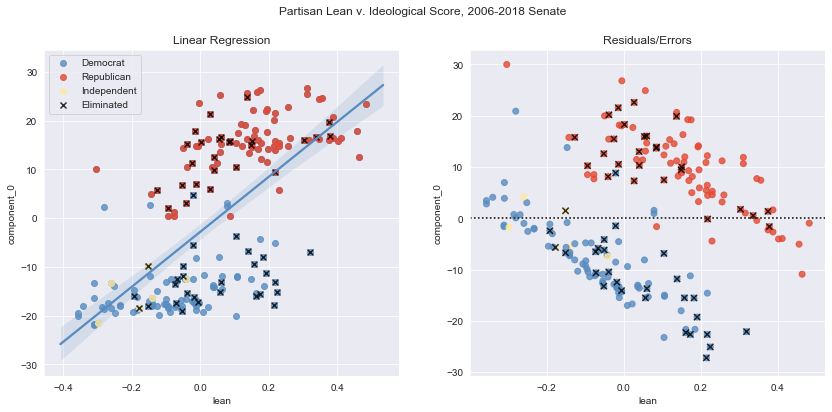

In [32]:
senate_hist_reduced.head()
_ = plot_lean_dw(senate_hist_reduced, y='component_0')

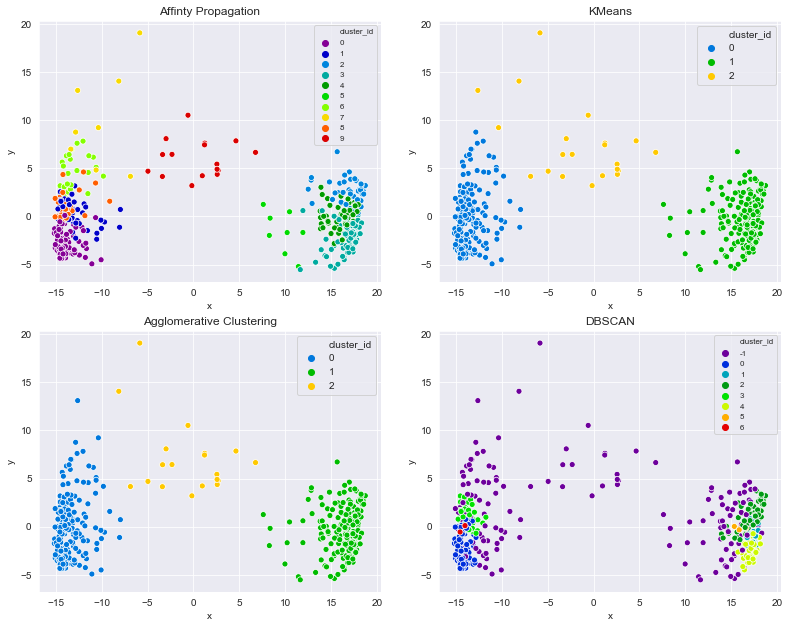

In [33]:
#Reduce dimensions
#use several models to assign different groups
def fit_label(model, x_cols, votes):
    #instansiate PCA with 3 components
    pca = PCA(n_components=3)
    
    pca.fit(x_cols)
    
    pca_features = pca.transform(x_cols)
    
    model.fit(pca_features) #train reduced model 
    
    labels = model.labels_ #extract labels
    
    #create dataframe out of the labels and dimension reduced features
    reduced_df = pd.DataFrame(
        {'Member Name':votes.columns.get_level_values('name'), 
         'cluster_id':labels,
         'x':pca_features[:,0],
         'y':pca_features[:,1]})
    
    #return the resulting df
    return reduced_df

#plot the results together
def plot_df(title, df, ax):
    n_clusters=df.cluster_id.nunique()
    color = sns.color_palette('nipy_spectral', n_colors=n_clusters)
    sns.scatterplot('x', 'y', data=df, hue='cluster_id', palette=color, ax=ax)
    if n_clusters > 5:
        ax.legend(fontsize='large', prop={'size':8}) #.set_visible(False)
    ax.set_title(title, fontsize='large')

def multi_cluster(votes, n_clusters=3):  
    '''take a dataframe of votes, reduce dimensionality with PCA, plot clusters with several models'''
    #factorize and sort the data
    votes = my_factorize(votes)

    #store member columns as a numpy matrix
    x_cols = votes.transpose().values
    
    #setup plot    
    f, axes = plt.subplots(2,2, figsize=(11,8.5))
    plt.tight_layout(h_pad=3, w_pad=3)

    #load a clustering method and try it out
    #Affinity Propogation
    from sklearn.cluster import AffinityPropagation
    aff_df = fit_label(AffinityPropagation(), x_cols, votes)
    plot_df('Affinty Propagation', aff_df, axes[0, 0])

    #Spectral clustering
    from sklearn.cluster import KMeans
    spec_df = fit_label(KMeans(n_clusters=n_clusters, random_state=38), x_cols, votes)
    plot_df('KMeans', spec_df, axes[0, 1])

    #Agglomerative clustering
    from sklearn.cluster import AgglomerativeClustering
    agg_df = fit_label(AgglomerativeClustering(n_clusters=n_clusters), x_cols, votes)
    plot_df('Agglomerative Clustering', agg_df, axes[1,0])

    #DBSCAN
    from sklearn.cluster import DBSCAN
    db_df = fit_label(DBSCAN(eps=1), x_cols, votes)
    plot_df('DBSCAN', db_df, axes[1,1])

    plt.show()


_, votes = load_cache(2018, 'house')
multi_cluster(votes)

In [34]:
#load all the votes for both chambers going back 20 years and concat them together
def concat_range(yearrange, chamber):
    ''' takes chamber and range of years, loads the votes for all those years, and returns them concated together
    without dw_nominate scores (those are different for every year)'''
    dflst = []
    
    #for every year in the range, load the csv for that year from cache and append it to a list
    for year in range(yearrange[0],yearrange[1]):
        _, votes = load_cache(year, chamber)
        dflst.append(votes)
    
    #drop dw_nominate level from all dfs in the list to avoid duplicate congress members
    for df in dflst:
        df.columns = df.columns.droplevel('dw_nominate')
    
    #return the list of df's concated together
    return pd.concat(dflst)

#concat house and senate together - unit test
all_house_votes = concat_range((1998,2020), 'house')
all_senate_votes = concat_range((1998,2020), 'senate')

#simple_unit_test
for df in [all_house_votes, all_senate_votes]:
    assert df.index[-1][0] == 116, '116th congress not loaded'

all_house_votes.head()

Cache out of date importing from API
importing house 2019 1 2 3 4 5 6 7 skip 8 9 skip 10 skip 11 skip 12 
saving 2019 house as Data/Cache/2019_housevote_meta.csv
Cache out of date importing from API
importing senate 2019 1 2 3 4 5 6 7 8 9 skip 10 skip 11 skip 12 
saving 2019 senate as Data/Cache/2019_senatevote_meta.csv


party                                         D                   \
state                                        AL                    
district                                      2                5   
member_id                               B001264          C000868   
name                               Bobby Bright Robert E. Cramer   
congress chamber session roll_call                                 
105      House   2       1                  NaN       Not Voting   
                         2                  NaN               No   
                         3                  NaN               No   
                         4                  NaN              Yes   
                         5                  NaN              Yes   

party                                                           \
state                                                            
district                                                     7   
member_id                                  G000557     D000602   
name                               Parker Griffith Artur Davis   
congress chamber session roll_call                               
105      House   2       1                     NaN         NaN   
                         2                     NaN         NaN   
                         3                     NaN         NaN   
                         4                     NaN         NaN   
                         5                     NaN         NaN   

party                                                                          \
state                                                                      AR   
district                                                                    1   
member_id                                   H000621      S001185      B000420   
name                               Earl F. Hilliard Terri Sewell Marion Berry   
congress chamber session roll_call                                              
105      House   2       1                  Present          NaN      Present   
                         2                       No          NaN           No   
                         3                       No          NaN           No   
                         4                      Yes          NaN          Yes   
                         5                      Yes          NaN          Yes   

party                                                    \
state                                                     
district                                    2         4   
member_id                             S000672   R000573   
name                               Vic Snyder Mike Ross   
congress chamber session roll_call                        
105      House   2       1            Present       NaN   
                         2                 No       NaN   
                         3                 No       NaN   
                         4                Yes       NaN   
                         5                Yes       NaN   

party                                                      ...           R  \
state                                                  AS  ...          WI   
district                                               79  ...           8   
member_id                                         F000010  ...     R000587   
name                               Eni F. H. Faleomavaega  ... Reid Ribble   
congress chamber session roll_call                         ...               
105      House   2       1                            NaN  ...         NaN   
                         2                            NaN  ...         NaN   
                         3                            NaN  ...         NaN   
                         4                            NaN  ...         NaN   
                         5                            NaN  ...         NaN   

party                                                                     \
state                                          

In [35]:
def slice_congress(df, congress):
    
    #slice the congress out with loc and multiindexing
    congressdf = df.loc[(congress,),:].dropna(how='all', axis=1)
    
    #unit test to make sure we don't have too many members (allowing for 62 special elections)
    assert congressdf.shape[1] < 500
    
    return congressdf

#simple unit test
house_116 = slice_congress(all_house_votes, 116)

house_116.head()



party                                D                                 \
state                               AL             AZ                   
district                             7              1               2   
member_id                      S001185        O000171         K000368   
name                      Terri Sewell Tom O'Halleran Ann Kirkpatrick   
chamber session roll_call                                               
House   1       1              Present        Present         Present   
                2               Pelosi         Pelosi          Pelosi   
                3                  Yes            Yes             Yes   
                4                  Yes            Yes             Yes   
                5           Not Voting             No              No   

party                                                                  \
state                                                                   
district                                 3             7            9   
member_id                          G000551       G000574      S001211   
name                      Raúl M. Grijalva Ruben Gallego Greg Stanton   
chamber session roll_call                                               
House   1       1                  Present       Present      Present   
                2                   Pelosi        Pelosi       Pelosi   
                3                      Yes           Yes          Yes   
                4                      Yes           Yes          Yes   
                5                       No            No           No   

party                                                               \
state                              CA                                
district                           10              11           12   
member_id                     H001090         D000623      P000197   
name                      Josh Harder Mark DeSaulnier Nancy Pelosi   
chamber session roll_call                                            
House   1       1             Present         Present      Present   
                2              Pelosi          Pelosi       Pelosi   
                3                 Yes             Yes      Speaker   
                4                 Yes             Yes      Speaker   
                5                  No              No      Speaker   

party                                  ...                      R              \
state                                  ...                     WA          WI   
district                           13  ...                      5           1   
member_id                     L000551  ...                M001159     S001213   
name                      Barbara Lee  ... Cathy McMorris Rodgers Bryan Steil   
chamber session roll_call              ...                                      
House   1       1             Present  ...                Present     Present   
                2              Pelosi  ...               McCarthy    McCarthy   
                3                 Yes  ...                     No          No   
                4                 Yes  ...                     No          No   
                5                  No  ...                    Yes         Yes   

party                                                                       \
state                                                                        
district                                       5              6          7   
member_id                                S000244        G000576    D000614   
name                      F. James Sensenbrenner Glenn Grothman Sean Duffy   
chamber session roll_call                                                    
House   1       1                        Present        Present    Present   
                2                       McCarthy       McCarthy   McCarthy   
                3                             No             No         No   
                4          

In [36]:
senate_116 = slice_congress(all_senate_votes, 116)

senate_116.head()

party                              D                                  \
state                             AL             AZ               CA   
member_id                    J000300        S001191          F000062   
name                      Doug Jones Kyrsten Sinema Dianne Feinstein   
chamber session roll_call                                              
Senate  1       1                Yes            Yes               No   
                2                Yes            Yes               No   
                3                Yes            Yes               No   
                4                 No             No               No   
                5                Yes            Yes              Yes   

party                                                                      \
state                                               CO                 CT   
member_id                       H001075        B001267            B001277   
name                      Kamala Harris Michael Bennet Richard Blumenthal   
chamber session roll_call                                                   
Senate  1       1                    No             No                 No   
                2                    No             No                 No   
                3                    No             No                 No   
                4                    No             No                 No   
                5                   Yes            Yes                Yes   

party                                                             \
state                                                         DE   
member_id                               M001169          C000174   
name                      Christopher S. Murphy Thomas R. Carper   
chamber session roll_call                                          
Senate  1       1                            No               No   
                2                            No               No   
                3                            No               No   
                4                            No               No   
                5                           Yes              Yes   

party                                                           ...  \
state                                                       HI  ...   
member_id                              C001088         H001042  ...   
name                      Christopher A. Coons Mazie K. Hirono  ...   
chamber session roll_call                                       ...   
Senate  1       1                           No              No  ...   
                2                           No              No  ...   
                3                           No              No  ...   
                4                           No              No  ...   
                5                          Yes             Yes  ...   

party                                   R                               \
state                                  TN                           TX   
member_id                         A000360          B001243     C001056   
name                      Lamar Alexander Marsha Blackburn John Cornyn   
chamber session roll_call                                                
Senate  1       1                     Yes              Yes         Yes   
                2                     Yes              Yes  Not Voting   
                3                     Yes              Yes         Yes   
                4                     Yes              Yes         Yes   
                5                      No               No          No   

party                                                                   \
state                                       UT                      WI   
member_id                     C001098  L000577     R000615     J000293   
name                         Ted Cruz Mike Lee Mitt Romney Ron Johnson   
chamber session roll_call                                                
Senat

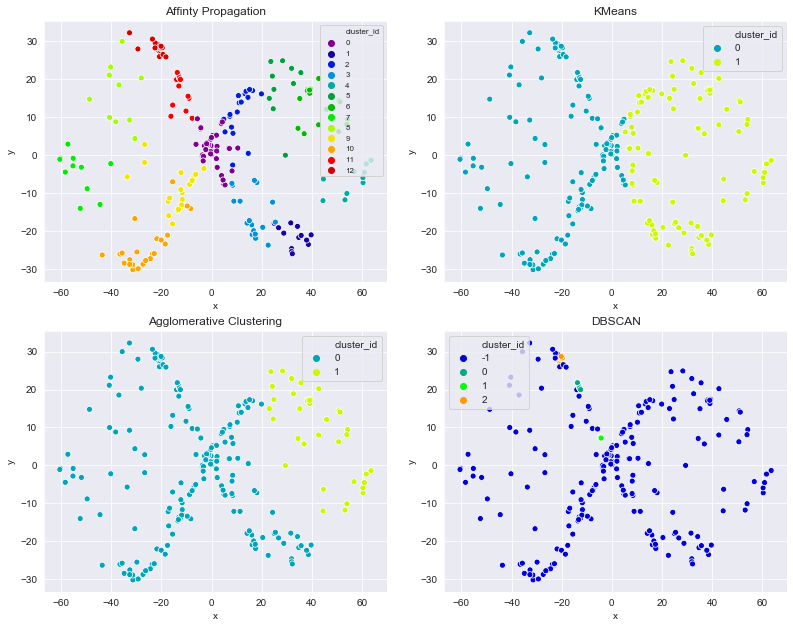

In [37]:
multi_cluster(all_senate_votes, n_clusters=2)

In [38]:
from sklearn.decomposition import PCA

def reduce_df(df, n_components=2):
    '''take a given dataframe of votes, dimension reduce voting behavior to n primary components,
    return df with n_components for each member'''
    
    #instantiate a primary component analysis model
    pca = PCA(n_components=n_components)
    
    #turn all yes/no into 1 / -1 with my custom factorization function
    votes=my_factorize(df)
    
    #convert into numpy array (turn it on side first)
    x_cols = votes.transpose().values
    
    #fit the model to the array
    pca.fit(x_cols)
    
    #use the model to transform array into n primary components
    pca_features = pca.transform(x_cols)
    
    #make a new df with congress members as index, and dimension reduced voting as values
    reduced_df = pd.DataFrame(pca_features, index=df.columns)
    
    return reduced_df
    
    
house_115 = slice_congress(all_house_votes, 115)
reduced_115 = reduce_df(house_115)
reduced_115.head()

0         1
party state district member_id name                                 
D     AL    7        S001185   Terri Sewell      27.681778  4.756626
      AZ    1        O000171   Tom O'Halleran    22.588266  7.459176
            3        G000551   Raúl M. Grijalva  30.646518  1.888561
            7        G000574   Ruben Gallego     29.251013  0.078701
            9        S001191   Kyrsten Sinema    15.327107  4.519182

In [87]:
from sklearn import preprocessing

def multi_merge(self, df, on, how='left'):
    '''merge using a multi-index and stay multi-indexed'''
    return pd.merge(self.reset_index(), df, on=on, how='left').set_index(self.index.names)

#create lean dfs for 2018 congress
house_lean = pd.merge(housedf, distlean, on = ['state','district'])   
senate_lean = pd.merge(senatedf, statelean, on = 'state')

def prep_df(df, end_date='2019-01-03', lean=house_lean):
    ''' create a new data frame of prepared and reduced house data for machine learning'''
    
    #reduce the dimentionality of the data
    reduced_df = reduce_df(df)
    
    #merge the data with partisan lean and end date
    merged_df = multi_merge(reduced_df, lean.loc[:,['member_id','end_date','lean']], on='member_id')
    
    #define eliminated members
    merged_df.loc[:,'eliminated'] = merged_df.loc[:,'end_date'] == end_date

    #drop end date out of frame
    merged_df.drop('end_date', axis=1, inplace=True)

    #drop out nans
    data = merged_df.dropna(how='any')
    
    #scale dimensions to fit with lean
    min_max_scaler = preprocessing.MinMaxScaler((-1,1))
    dims = data.loc[:,[0,1]].values
    dims_scaled = min_max_scaler.fit_transform(dims)
    data.loc[:,[0,1]] = dims_scaled
    
    return data



house_115 = slice_congress(all_house_votes, 115)


data = prep_df(house_115)

senate_115 = slice_congress(all_senate_votes, 115)
senate_data = prep_df(senate_115)
data.eliminated.sum()

/home/nhorning/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/nhorning/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


86

In [88]:
house_115.head()

party                                D                                  \
state                               AL             AZ                    
district                             7              1                3   
member_id                      S001185        O000171          G000551   
name                      Terri Sewell Tom O'Halleran Raúl M. Grijalva   
chamber session roll_call                                                
House   1       1              Present        Present          Present   
                2               Pelosi         Pelosi           Pelosi   
                3                   No             No               No   
                4                   No             No               No   
                5                  Yes            Yes              Yes   

party                                                                   \
state                                                               CA   
district                              7              9              11   
member_id                       G000574        S001191         D000623   
name                      Ruben Gallego Kyrsten Sinema Mark DeSaulnier   
chamber session roll_call                                                
House   1       1               Present        Present         Present   
                2                Pelosi     Lewis (GA)          Pelosi   
                3                    No             No              No   
                4                    No             No              No   
                5                   Yes            Yes             Yes   

party                                                             \
state                                                              
district                            12          13            14   
member_id                      P000197     L000551       S001175   
name                      Nancy Pelosi Barbara Lee Jackie Speier   
chamber session roll_call                                          
House   1       1              Present     Present       Present   
                2               Pelosi      Pelosi        Pelosi   
                3                   No          No            No   
                4                   No          No            No   
                5                  Yes         Yes           Yes   

party                                    ...            R              \
state                                    ...           WI               
district                             15  ...            1               
member_id                       S001193  ...      R000570     S001213   
name                      Eric Swalwell  ... Paul D. Ryan Bryan Steil   
chamber session roll_call                ...                            
House   1       1               Present  ...      Present         NaN   
                2                Pelosi  ...   Not Voting         NaN   
                3                    No  ...      Speaker         NaN   
                4                    No  ...      Speaker         NaN   
                5                   Yes  ...      Speaker         NaN   

party                                                                       \
state                                                                        
district                                       5              6          7   
member_id                                S000244        G000576    D000614   
name                      F. James Sensenbrenner Glenn Grothman Sean Duffy   
chamber session roll_call                                                    
House   1       1                        Present        Present    Present   
                2                      Ryan (WI)      Ryan (WI)  Ryan (WI)   
                3                            Yes            Yes        Yes   
                4                            Yes            Yes        Yes   
                5                    

In [105]:
#try classifying who was eliminated
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

classifiers = {
        "L. Regression":LogisticRegression(),
        "N. Neighbors":KNeighborsClassifier(3),
        #"Linear SVM":SVC(kernel="linear", C=0.025),
        "RBF SVM":SVC(gamma=2, C=1),
        "Gaussian P.":GaussianProcessClassifier(1.0 * RBF(1.0)),
        "Decision Tree":DecisionTreeClassifier(max_depth=5),
        "Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        "Neural Net":MLPClassifier(alpha=1, hidden_layer_sizes=(100,50,2), max_iter=1000),
        "AdaBoost":AdaBoostClassifier(),
        "Naive Bayes":GaussianNB(),
        "QDA":QuadraticDiscriminantAnalysis(),
        }
             

def print_cv(cls, X, y, cv=4):
    ''' print out the results of the sklearn.crossvalidate, return them as a dict'''
    
    # set the scoring function
    scoring = {'accuracy': 'accuracy',#metrics.accuracy_score()
               'precision': 'precision',#metrics.precision_score(),
               'recall': 'recall'}#metrics.recall_score()}
    
    #use the crossvalidator
    cvs = cross_validate(cls, X, y=y, scoring=scoring, cv=cv)
    
    #Print the scores
    print('Cross Val Scores')
    for score in scoring.keys():
        key = 'test_'+score
        print('{}: {}, avr:{:.2f}'.format(score, cvs[key], cvs[key].mean()))
    return cvs            
    
def try_cls(data, predict, classifiers=classifiers, dm=(0,1)):
    '''take dimension reduced data with a value to predict, try a series of classifiers on it'''
   
    # Split data into X y
    X, y = data.drop(predict, axis=1).values, data.loc[:,predict].values

    # Split X y into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=38)

    # instantiate a confusion matrix object
    cm = confusion_matrix

    # initialize a dictionary for crossval scores
    cvdict = {}
    
    #loop through the clasifiers and plot traing + test sets
    for name in classifiers.keys(): 
        cls = classifiers[name]
        
        #fit the classifier on training data
        cls.fit(X_train, y_train)
    
        #score the classifier based on test data
        score = cls.score(X_test, y_test)
    
        #get the predictions from the testing features
        y_pred = cls.predict(X_test)
    
        #calculate the confusion matrix
        c = cm(y_test, y_pred, labels=[False,True])
        
        #turn the confusion matrix into a DataFrame
        cmdf = pd.DataFrame(c)#, index=pd.MultiIndex.from_tuples([('Actual','True'),('Actual','False')]), columns=pd.MultiIndex.from_tuples([('Predicted','True'),('Predicted','False')]))
        
        #pull out the confusion matrix metrics
        tn, fp, fn, tp = c.ravel()
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        
        #Print out the first run metrics
        print('\n\n{}, first run:  True Negative={}, False Positive={}, False Negative={}, True Positive={}'.format(name, tn, fp, fn, tp))
        print(cmdf)
        print('Raw Accuracy Score={:.2f},Precision={:.2f}, Recall={:.2f}\n'.format(score, precision, recall))
       
        
        #form testing and training data back into dataframes for plotting
        datacols = data.drop(predict, axis=1).columns
        traindata = pd.DataFrame(X_train, columns = datacols)
        traindata['y_train'] = y_train                         
    
        testdata = pd.DataFrame(X_test, columns = datacols)
        testdata['y_test'] = y_test
        testdata['y_pred'] = y_pred
    
        #create arrays of cm metrics so we can plot them.
        TN = ~y_test & ~y_pred
        FP = ~y_test & y_pred
        FN = y_test & ~y_pred
        TP = y_test & y_pred
    
        #set up the plots
        f, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))

        #Set which dimensions will be plotted
        xaxis=dm[0]
        yaxis=dm[1]
        
        #plot the training data
        plotdata=traindata
        hue='y_train'
        sns.scatterplot(x=xaxis, y=yaxis, data=plotdata, hue=hue, ax=ax0)
    
        #plot the testing data
        plotdata=testdata
        hue='y_pred'
        sns.scatterplot(x=xaxis, y=yaxis, data=plotdata, hue=hue, ax=ax1)
    
        #cross out the false possitives
        plotdata=testdata[FP]
        label='False Positive'
        marker='x'
        color='red'
        sns.scatterplot(x=xaxis, y=yaxis, data=plotdata, color=color, label=label, marker=marker, ax=ax1,)
    
        #cross out the false negatives
        plotdata=testdata[FN]
        color='black'
        label='False Negative'
        sns.scatterplot(x=xaxis, y=yaxis, data=plotdata, color=color, label=label, marker=marker, ax=ax1)
    
        #plot a contour map of the decision function
        x_min, x_max = traindata.loc[:, xaxis].min() - .5, traindata.loc[:, xaxis].max() + .5
        y_min, y_max = traindata.loc[:, yaxis].min() - .5, traindata.loc[:, yaxis].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, .2),
                             np.arange(y_min, y_max, .2))

        #check whether it's a decision fuction or a probability matrix and grab based on that. 
        if hasattr(cls, "decision_function"):
            Z = cls.decision_function(np.c_[xx.ravel(),xx.ravel(), yy.ravel()])
        else:
            Z = cls.predict_proba(np.c_[xx.ravel(),xx.ravel(), yy.ravel()])[:, 1]

        #Plot the contours on each axis
        Z = Z.reshape(xx.shape)
        ax0.contourf(xx, yy, Z, cmap=ListedColormap(sns.color_palette('RdBu')), alpha=.3)
        ax1.contourf(xx, yy, Z, cmap=ListedColormap(sns.color_palette('RdBu')), alpha=.3)
   
        #set up titles
        f.suptitle(name)
        ax0.set_title('training set')
        ax1.set_title('testing set')
        plt.show() 
    
        #print the crossvalidation scores
        cvs = print_cv(cls, X, y, cv=3)
        
        #add the crossvalidation scores to the dictionary
        cvdict[name] = cvs
        
    #return the crossvalidation dictionary
    return cvdict

#try_cls(data, 'eliminated')

In [117]:
#tweak dimensions
from scipy import stats

def set_resids(data):
    #run regression to get redisduals
    slope, intercept, r_value, p_value, std_err = stats.linregress(data.loc[:,'lean'], data.loc[:,0])

    
    #replace "component_0" with residual dimension
    data.loc[:,0] = data.loc[:,0] - ((data.loc[:,'lean']) * slope + intercept) 
    #data = data.drop('lean', axis=1)
    #data[1] = abs(data[0])
    
    return data

def transpose_party(data):
    
    idx = data.index.get_level_values('party') == 'R'
    data.loc[idx,[0,'lean']] = - data.loc[idx,[0,'lean']]
    data.loc[:,0] = - data.loc[:,0]
    
                                          
    return data

#get data for 114th congress and prep it (partisain lean caluculations for the 14th congress are the same.)
house_114 = slice_congress(all_house_votes, 114)
data_14 = prep_df(house_114, end_date='2017-01-03')

#prep data for 115th congress. 
data_15 = prep_df(house_115)

#concat two congresses together - might not be great, because the houses are different they interfear
#data = pd.concat([data_14, data_15])

#senate_data = prep_df(senate_115)
# restrict to party
    #data = data.loc[('R',),:]
    #data[0] = abs(data.loc[:,0])
    
#try_cls(data, 'eliminated')    
#data = set_resids(data_14)




#load dw_nominate scores in and add them to data.
#_, votes_15 = load_cache(2018, 'house')

#dw_15 = votes_15.columns.to_frame().set_index('member_id').loc[:,'dw_nominate']
#print(dw_15.head())

#data1 = data_15.join(dw_15)
#data1[0] = data1.dw_nominate
#data1 = data1.drop('dw_nominate', axis=1).dropna()
#print(data1.head())

#cvdict2 = try_cls(data1, 'eliminated', dm=('lean',0))

#data2 = set_resids(data1)
#cvdict3 = try_cls(data2, 'eliminated', dm=('lean',0))




/home/nhorning/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/home/nhorning/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2854: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


                        0         1      lean    ded
member_id party                                     
L000304   I     -0.769095 -0.086195 -0.141128  False
C000174   D     -0.627728  0.074562 -0.066382  False
N000032   D     -0.691173 -0.073881  0.063933  False
S000770   D     -0.858003 -0.291932 -0.054538  False
D000596   D     -0.874549 -0.182833 -0.051513   True


L. Regression, first run:  True Negative=43, False Positive=0, False Negative=17, True Positive=0
    0  1
0  43  0
1  17  0
Raw Accuracy Score=0.72,Precision=nan, Recall=0.00



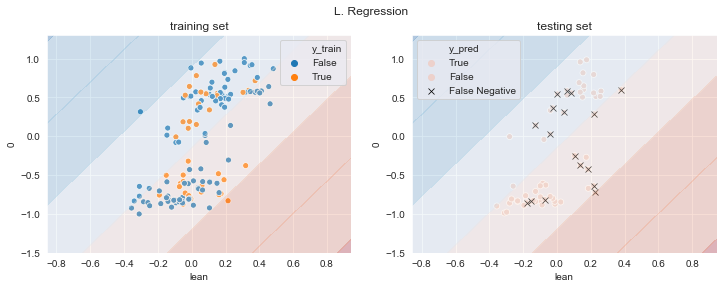

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432:

Cross Val Scores
accuracy: [0.72727273 0.72727273 0.6969697 ], avr:0.72
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


N. Neighbors, first run:  True Negative=32, False Positive=11, False Negative=9, True Positive=8
    0   1
0  32  11
1   9   8
Raw Accuracy Score=0.67,Precision=0.42, Recall=0.47



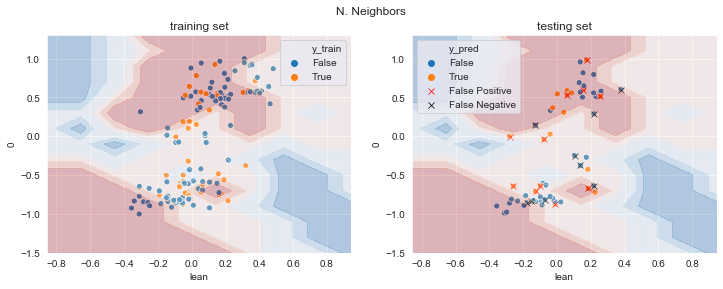

Cross Val Scores
accuracy: [0.68181818 0.77272727 0.62121212], avr:0.69
precision: [0.36363636 0.66666667 0.26666667], avr:0.43
recall: [0.22222222 0.33333333 0.22222222], avr:0.26


RBF SVM, first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



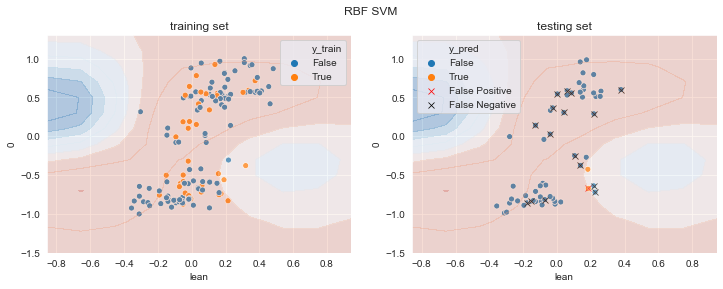

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.68181818 0.72727273 0.65151515], avr:0.69
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


Gaussian P., first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



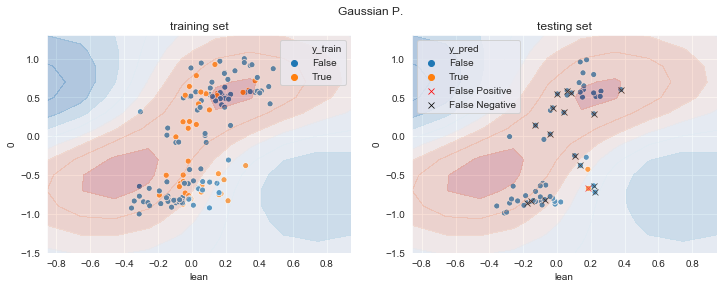

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.66666667 0.72727273 0.65151515], avr:0.68
precision: [0.         0.         0.35294118], avr:0.12
recall: [0.         0.         0.33333333], avr:0.11


Decision Tree, first run:  True Negative=38, False Positive=5, False Negative=10, True Positive=7
    0  1
0  38  5
1  10  7
Raw Accuracy Score=0.75,Precision=0.58, Recall=0.41



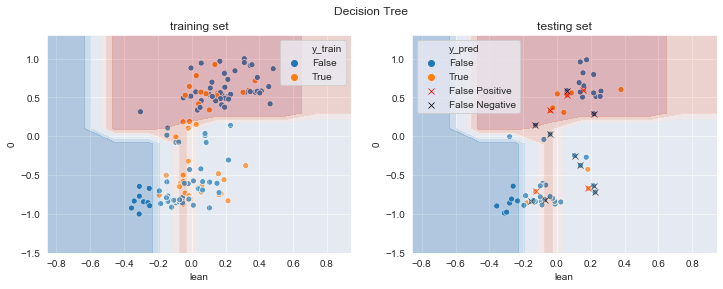

Cross Val Scores
accuracy: [0.63636364 0.51515152 0.57575758], avr:0.58
precision: [0.2    0.15   0.1875], avr:0.18
recall: [0.11111111 0.16666667 0.16666667], avr:0.15


Random Forest, first run:  True Negative=41, False Positive=2, False Negative=12, True Positive=5
    0  1
0  41  2
1  12  5
Raw Accuracy Score=0.77,Precision=0.71, Recall=0.29



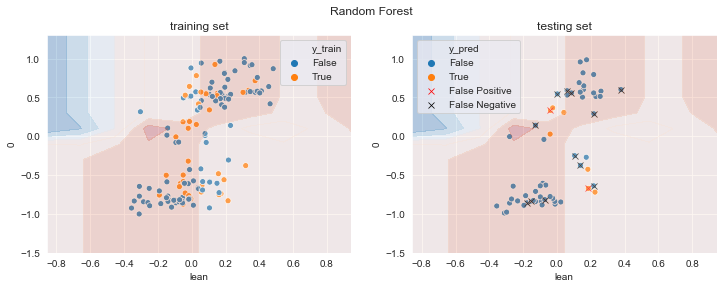

Cross Val Scores
accuracy: [0.63636364 0.75757576 0.59090909], avr:0.66
precision: [0.125 0.75  0.   ], avr:0.29
recall: [0.05555556 0.16666667 0.        ], avr:0.07


Neural Net, first run:  True Negative=43, False Positive=0, False Negative=16, True Positive=1
    0  1
0  43  0
1  16  1
Raw Accuracy Score=0.73,Precision=1.00, Recall=0.06



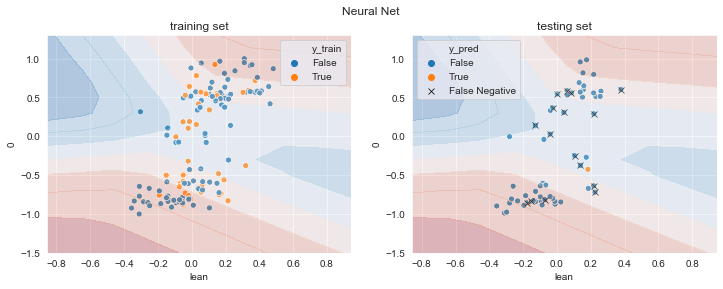

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Cross Val Scores
accuracy: [0.68181818 0.72727273 0.27272727], avr:0.56
precision: [0.         0.         0.27272727], avr:0.09
recall: [0. 0. 1.], avr:0.33


AdaBoost, first run:  True Negative=37, False Positive=6, False Negative=12, True Positive=5
    0  1
0  37  6
1  12  5
Raw Accuracy Score=0.70,Precision=0.45, Recall=0.29



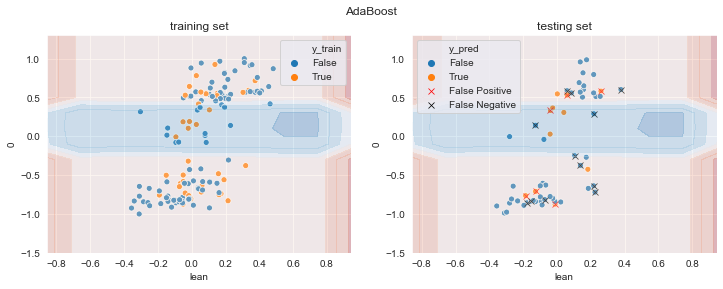

Cross Val Scores
accuracy: [0.53030303 0.5        0.5       ], avr:0.51
precision: [0.19047619 0.14285714 0.17391304], avr:0.17
recall: [0.22222222 0.16666667 0.22222222], avr:0.20


Naive Bayes, first run:  True Negative=43, False Positive=0, False Negative=15, True Positive=2
    0  1
0  43  0
1  15  2
Raw Accuracy Score=0.75,Precision=1.00, Recall=0.12



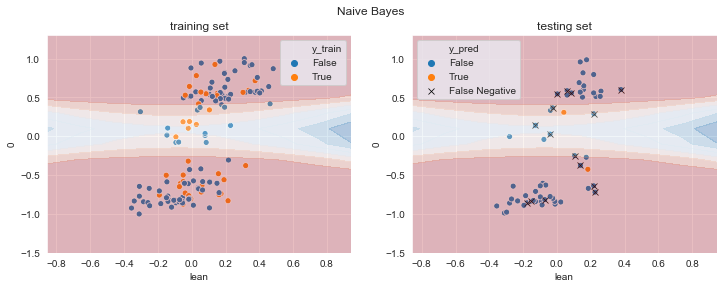

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.71212121 0.72727273 0.65151515], avr:0.70
precision: [0.         0.         0.14285714], avr:0.05
recall: [0.         0.         0.05555556], avr:0.02


QDA, first run:  True Negative=40, False Positive=3, False Negative=11, True Positive=6
    0  1
0  40  3
1  11  6
Raw Accuracy Score=0.77,Precision=0.67, Recall=0.35



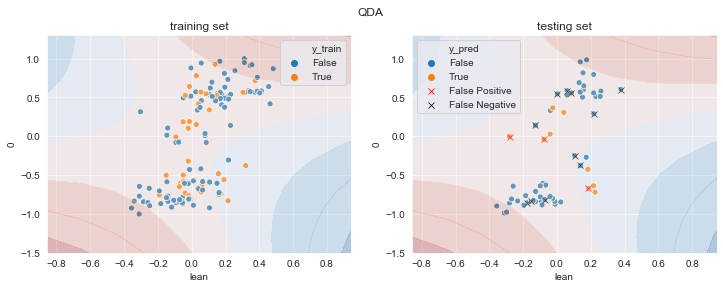

Cross Val Scores
accuracy: [0.71212121 0.75757576 0.71212121], avr:0.73
precision: [0.         0.625      0.45454545], avr:0.36
recall: [0.         0.27777778 0.27777778], avr:0.19


L. Regression, first run:  True Negative=43, False Positive=0, False Negative=17, True Positive=0
    0  1
0  43  0
1  17  0
Raw Accuracy Score=0.72,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


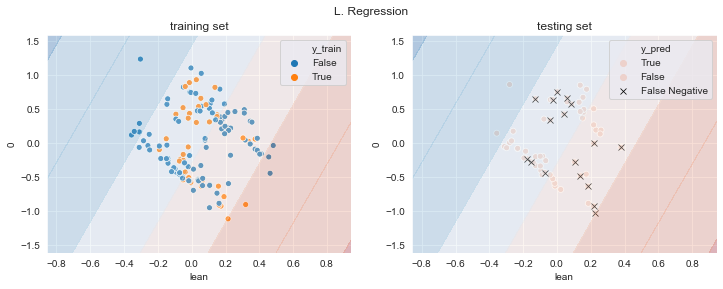

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432:

Cross Val Scores
accuracy: [0.72727273 0.72727273 0.6969697 ], avr:0.72
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


N. Neighbors, first run:  True Negative=34, False Positive=9, False Negative=9, True Positive=8
    0  1
0  34  9
1   9  8
Raw Accuracy Score=0.70,Precision=0.47, Recall=0.47



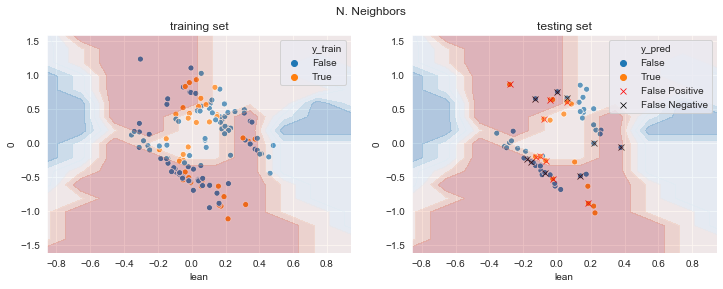

Cross Val Scores
accuracy: [0.62121212 0.6969697  0.62121212], avr:0.65
precision: [0.29411765 0.41666667 0.29411765], avr:0.33
recall: [0.27777778 0.27777778 0.27777778], avr:0.28


RBF SVM, first run:  True Negative=41, False Positive=2, False Negative=16, True Positive=1
    0  1
0  41  2
1  16  1
Raw Accuracy Score=0.70,Precision=0.33, Recall=0.06



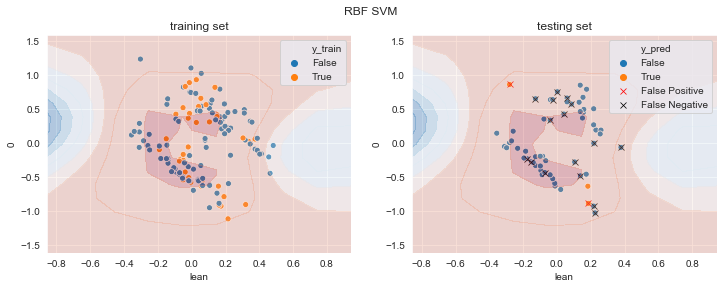

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.71212121 0.72727273 0.71212121], avr:0.72
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


Gaussian P., first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



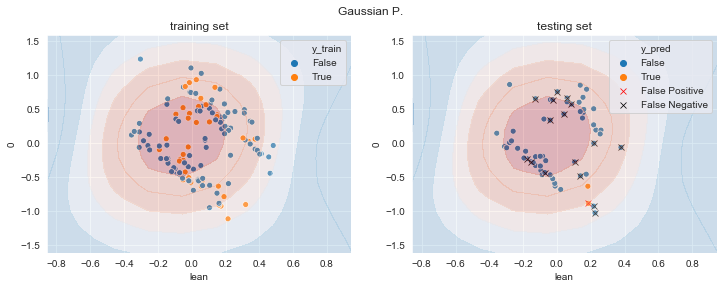

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.72727273 0.6969697  0.6969697 ], avr:0.71
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


Decision Tree, first run:  True Negative=38, False Positive=5, False Negative=13, True Positive=4
    0  1
0  38  5
1  13  4
Raw Accuracy Score=0.70,Precision=0.44, Recall=0.24



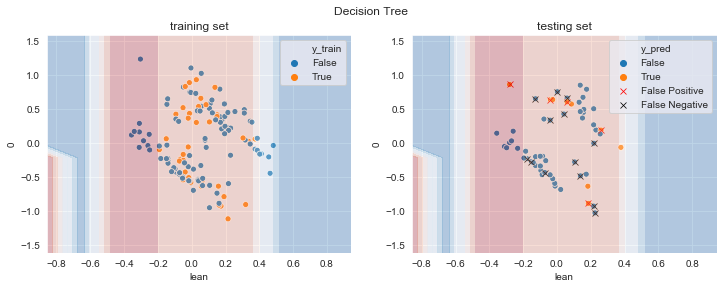

Cross Val Scores
accuracy: [0.66666667 0.65151515 0.60606061], avr:0.64
precision: [0.4        0.33333333 0.3       ], avr:0.34
recall: [0.44444444 0.27777778 0.33333333], avr:0.35


Random Forest, first run:  True Negative=41, False Positive=2, False Negative=13, True Positive=4
    0  1
0  41  2
1  13  4
Raw Accuracy Score=0.75,Precision=0.67, Recall=0.24



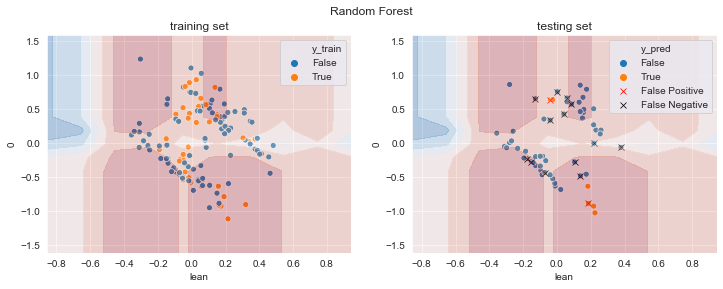

Cross Val Scores
accuracy: [0.66666667 0.8030303  0.66666667], avr:0.71
precision: [0.3        0.85714286 0.3       ], avr:0.49
recall: [0.16666667 0.33333333 0.16666667], avr:0.22


Neural Net, first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



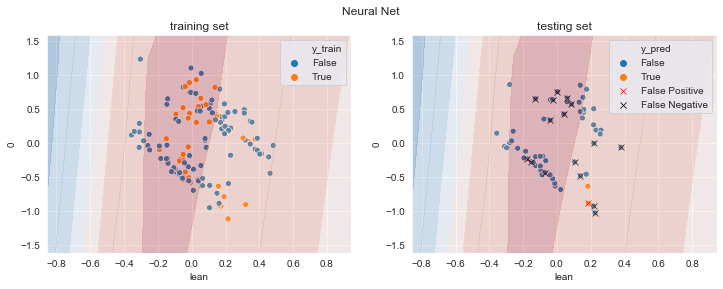

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.72727273 0.6969697  0.65151515], avr:0.69
precision: [0.         0.33333333 0.        ], avr:0.11
recall: [0.         0.11111111 0.        ], avr:0.04


AdaBoost, first run:  True Negative=38, False Positive=5, False Negative=12, True Positive=5
    0  1
0  38  5
1  12  5
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.29



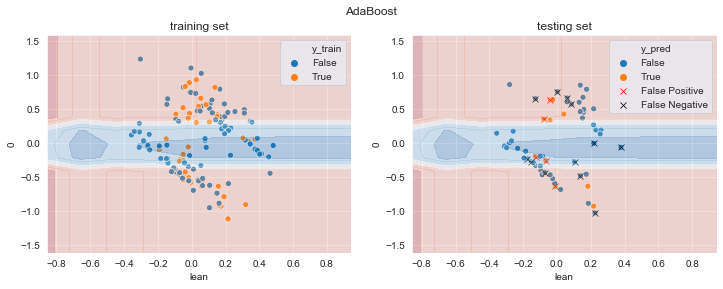

Cross Val Scores
accuracy: [0.71212121 0.68181818 0.59090909], avr:0.66
precision: [0.46153846 0.41176471 0.26315789], avr:0.38
recall: [0.33333333 0.38888889 0.27777778], avr:0.33


Naive Bayes, first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



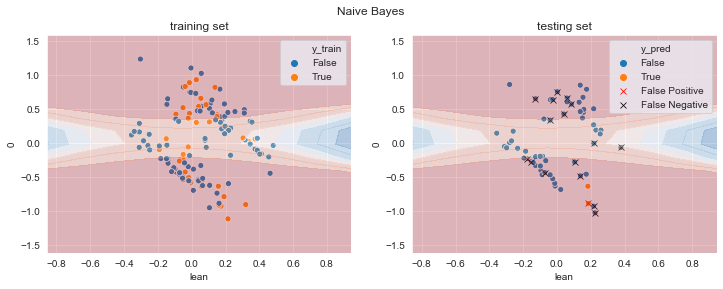

Cross Val Scores
accuracy: [0.71212121 0.6969697  0.65151515], avr:0.69
precision: [0.         0.33333333 0.        ], avr:0.11
recall: [0.         0.11111111 0.        ], avr:0.04


QDA, first run:  True Negative=40, False Positive=3, False Negative=11, True Positive=6
    0  1
0  40  3
1  11  6
Raw Accuracy Score=0.77,Precision=0.67, Recall=0.35



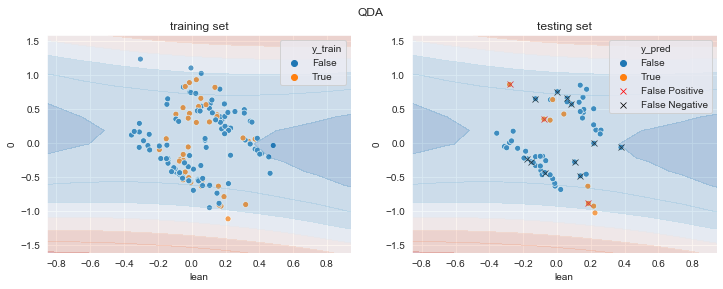

Cross Val Scores
accuracy: [0.71212121 0.75757576 0.71212121], avr:0.73
precision: [0.         0.625      0.45454545], avr:0.36
recall: [0.         0.27777778 0.27777778], avr:0.19


L. Regression, first run:  True Negative=43, False Positive=0, False Negative=17, True Positive=0
    0  1
0  43  0
1  17  0
Raw Accuracy Score=0.72,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


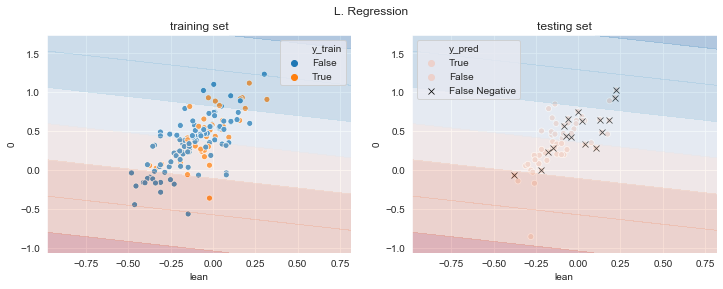

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarni

Cross Val Scores
accuracy: [0.72727273 0.72727273 0.72727273], avr:0.73
precision: [0.  0.5 0. ], avr:0.17
recall: [0.         0.05555556 0.        ], avr:0.02


N. Neighbors, first run:  True Negative=34, False Positive=9, False Negative=10, True Positive=7
    0  1
0  34  9
1  10  7
Raw Accuracy Score=0.68,Precision=0.44, Recall=0.41



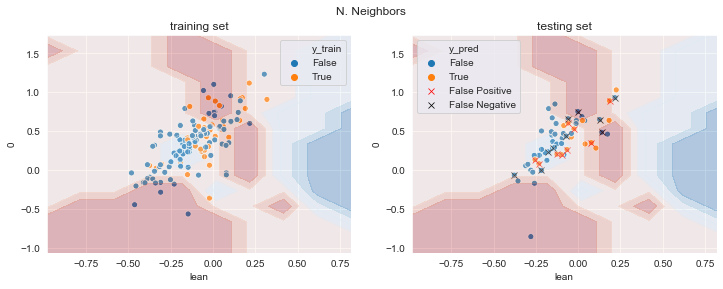

Cross Val Scores
accuracy: [0.6969697  0.66666667 0.60606061], avr:0.66
precision: [0.4375     0.35714286 0.21428571], avr:0.34
recall: [0.38888889 0.27777778 0.16666667], avr:0.28


RBF SVM, first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



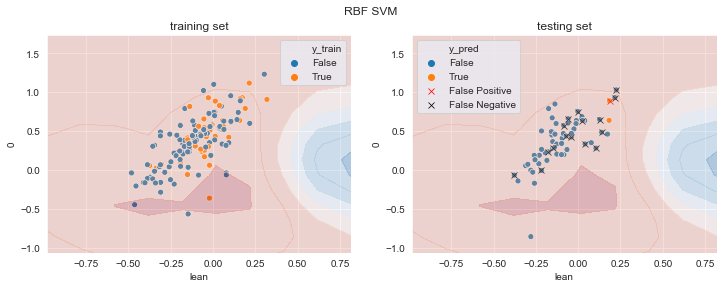

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.77272727 0.72727273 0.68181818], avr:0.73
precision: [1. 0. 0.], avr:0.33
recall: [0.16666667 0.         0.        ], avr:0.06


Gaussian P., first run:  True Negative=42, False Positive=1, False Negative=16, True Positive=1
    0  1
0  42  1
1  16  1
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.06



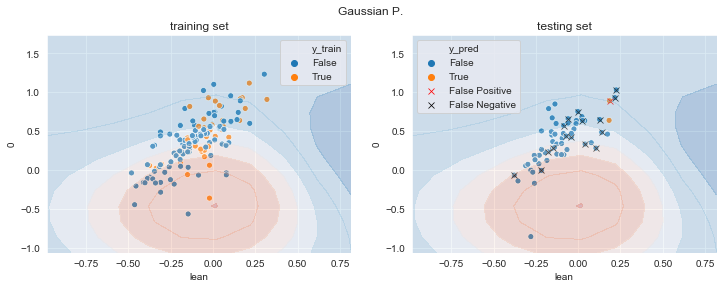

Cross Val Scores
accuracy: [0.66666667 0.71212121 0.68181818], avr:0.69
precision: [0.33333333 0.33333333 0.        ], avr:0.22
recall: [0.22222222 0.05555556 0.        ], avr:0.09


Decision Tree, first run:  True Negative=33, False Positive=10, False Negative=12, True Positive=5
    0   1
0  33  10
1  12   5
Raw Accuracy Score=0.63,Precision=0.33, Recall=0.29



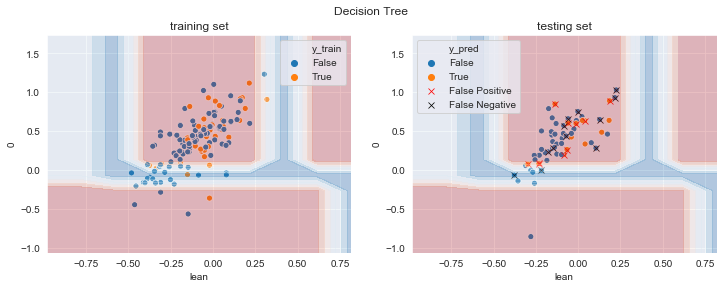

Cross Val Scores
accuracy: [0.68181818 0.6969697  0.62121212], avr:0.67
precision: [0.42105263 0.4        0.29411765], avr:0.37
recall: [0.44444444 0.22222222 0.27777778], avr:0.31


Random Forest, first run:  True Negative=38, False Positive=5, False Negative=13, True Positive=4
    0  1
0  38  5
1  13  4
Raw Accuracy Score=0.70,Precision=0.44, Recall=0.24



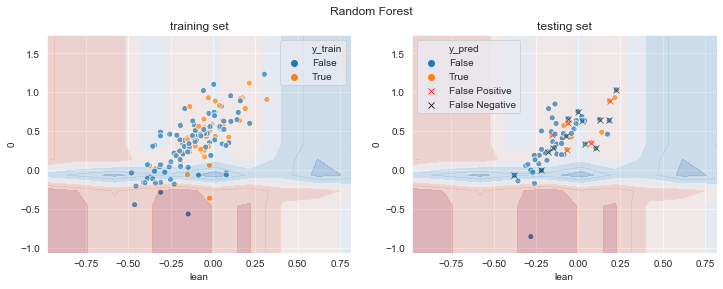

Cross Val Scores
accuracy: [0.68181818 0.66666667 0.60606061], avr:0.65
precision: [0.38461538 0.3        0.25      ], avr:0.31
recall: [0.27777778 0.16666667 0.22222222], avr:0.22


/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars




Neural Net, first run:  True Negative=43, False Positive=0, False Negative=17, True Positive=0
    0  1
0  43  0
1  17  0
Raw Accuracy Score=0.72,Precision=nan, Recall=0.00



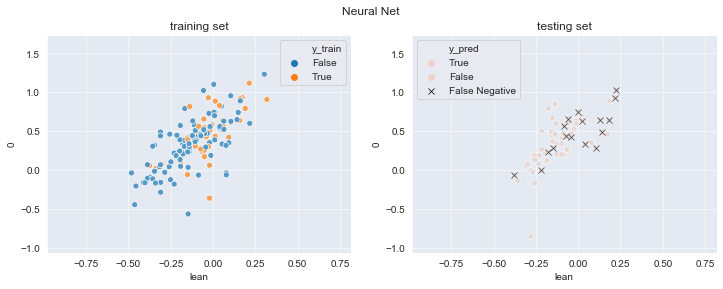

Cross Val Scores
accuracy: [0.68181818 0.75757576 0.66666667], avr:0.70
precision: [0.38461538 0.625      0.        ], avr:0.34
recall: [0.27777778 0.27777778 0.        ], avr:0.19


AdaBoost, first run:  True Negative=38, False Positive=5, False Negative=12, True Positive=5
    0  1
0  38  5
1  12  5
Raw Accuracy Score=0.72,Precision=0.50, Recall=0.29



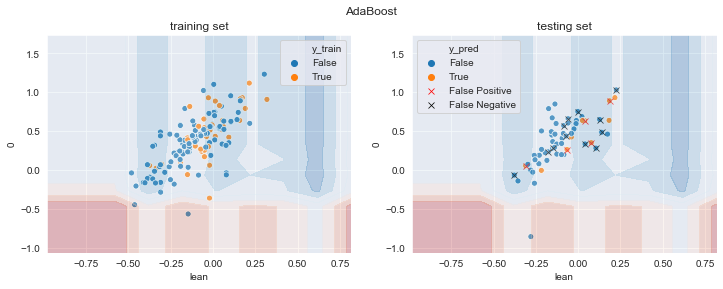

Cross Val Scores
accuracy: [0.68181818 0.6969697  0.59090909], avr:0.66
precision: [0.4        0.41666667 0.2       ], avr:0.34
recall: [0.33333333 0.27777778 0.16666667], avr:0.26


Naive Bayes, first run:  True Negative=41, False Positive=2, False Negative=12, True Positive=5
    0  1
0  41  2
1  12  5
Raw Accuracy Score=0.77,Precision=0.71, Recall=0.29



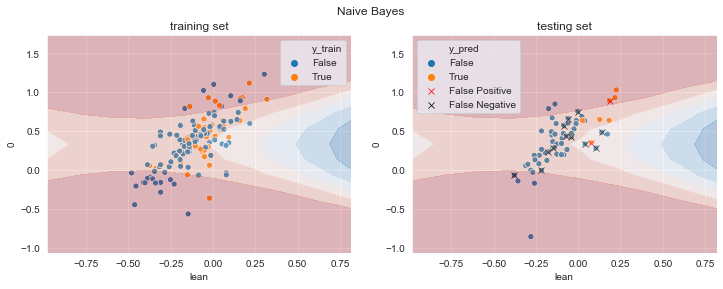

Cross Val Scores
accuracy: [0.71212121 0.68181818 0.68181818], avr:0.69
precision: [0.4        0.36363636 0.36363636], avr:0.38
recall: [0.11111111 0.22222222 0.22222222], avr:0.19


QDA, first run:  True Negative=42, False Positive=1, False Negative=14, True Positive=3
    0  1
0  42  1
1  14  3
Raw Accuracy Score=0.75,Precision=0.75, Recall=0.18



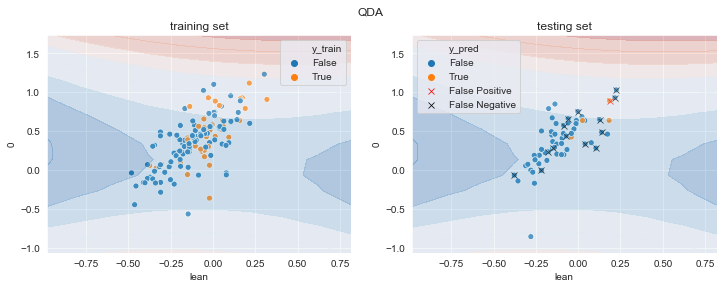

Cross Val Scores
accuracy: [0.68181818 0.75757576 0.66666667], avr:0.70
precision: [0.33333333 0.66666667 0.33333333], avr:0.44
recall: [0.16666667 0.22222222 0.22222222], avr:0.20


In [118]:
data = senate_hist_reduced.loc[:,['member_id','party','component_0','component_1','lean','ded']]
#data = merged_df.dropna(how='any')

data.set_index(['member_id','party'], inplace=True)

data.dropna(axis=1, how='any', inplace=True)

data.columns = [0,1,'lean','ded']
#scale dimensions to fit with lean
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
dims = data.loc[:,[0,1]].values
dims_scaled = min_max_scaler.fit_transform(dims)
data.loc[:,[0,1]] = dims_scaled
data.loc[:,'ded'] = data.ded != 0

print(data.head())
#senate_data['ded'] = 0
cvdict_1 = try_cls(data, 'ded', dm=('lean',0))
data01 = set_resids(data)

cvdict_2 = try_cls(data01, 'ded', dm=('lean',0))

data02 = transpose_party(data01)
cvdict_3 = try_cls(data02, 'ded', dm=('lean',0))



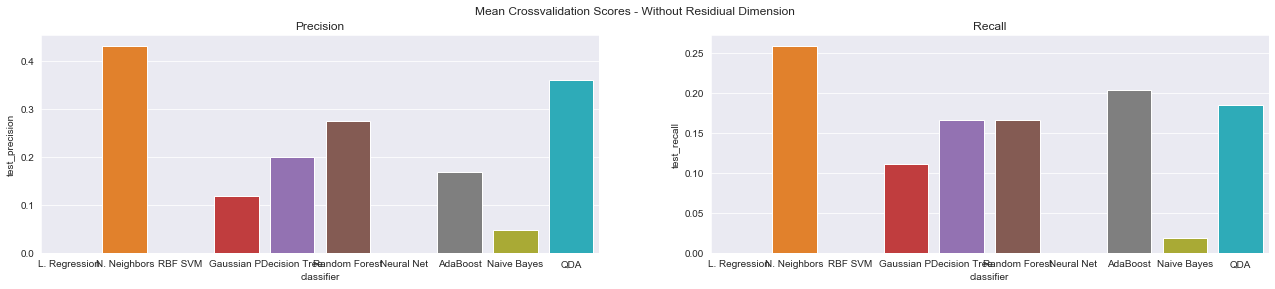

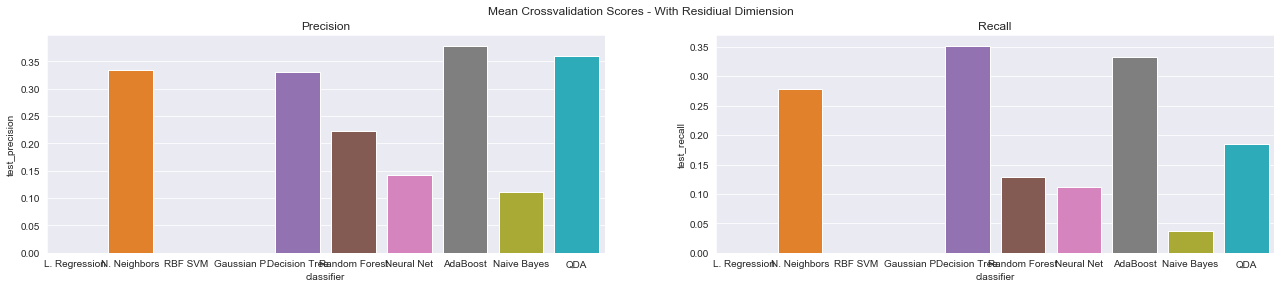

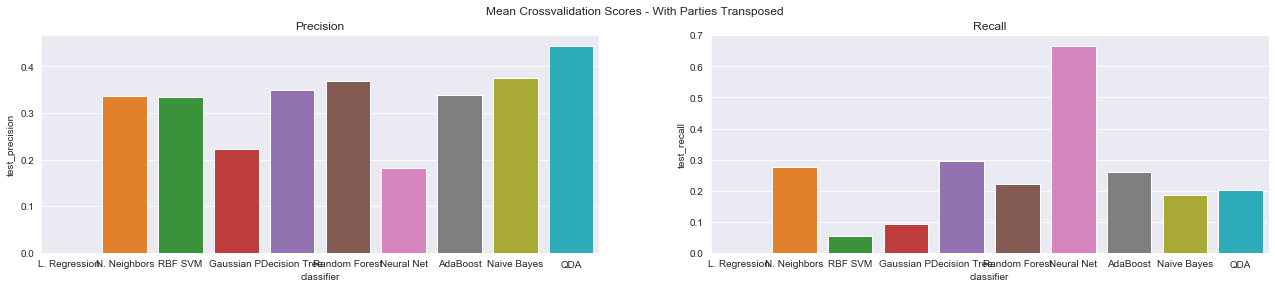

In [116]:
def plot_scores(meandf, title):
    test_scores0 = meandf.loc[['test_accuracy','test_precision','test_recall'],:].transpose()
    #test_scores0.drop(['Linear SVM'], inplace=True)
    reset0 = test_scores0.reset_index()
    reset0.columns = ['classifier','test_accuracy','test_precision','test_recall']
    
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (22, 4))

    sns.barplot(x='classifier', y='test_precision', data=reset0, ax=ax1)
    sns.barplot(x='classifier', y='test_recall', data=reset0, ax=ax2)

    ax1.set_title('Precision')
    ax2.set_title('Recall')
    f.suptitle(title)
    plt.show()

cvdf_0 = pd.DataFrame(cvdict_1)
cvdf_1 = pd.DataFrame(cvdict_2)
cvdf_2 = pd.DataFrame(cvdict_3)

meandf_0 = cvdf_0.applymap(lambda x: np.mean(x))
meandf_1 = cvdf_1.applymap(lambda x: np.mean(x))
meandf_2 = cvdf_2.applymap(lambda x: np.mean(x))

plot_scores(meandf_0, 'Mean Crossvalidation Scores - Without Residiual Dimension')
plot_scores(meandf_1, 'Mean Crossvalidation Scores - With Residiual Dimiension')
plot_scores(meandf_2, 'Mean Crossvalidation Scores - With Parties Transposed')

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




L. Regression, first run:  True Negative=108, False Positive=1, False Negative=27, True Positive=0
     0  1
0  108  1
1   27  0
Raw Accuracy Score=0.79,Precision=0.00, Recall=0.00



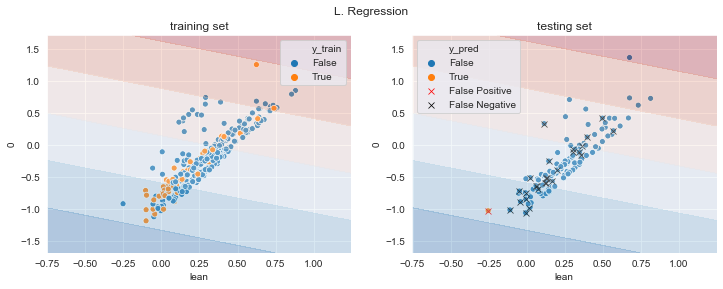

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarni

Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0.5 0.  0. ], avr:0.17
recall: [0.03448276 0.         0.        ], avr:0.01


N. Neighbors, first run:  True Negative=97, False Positive=12, False Negative=17, True Positive=10
    0   1
0  97  12
1  17  10
Raw Accuracy Score=0.79,Precision=0.45, Recall=0.37



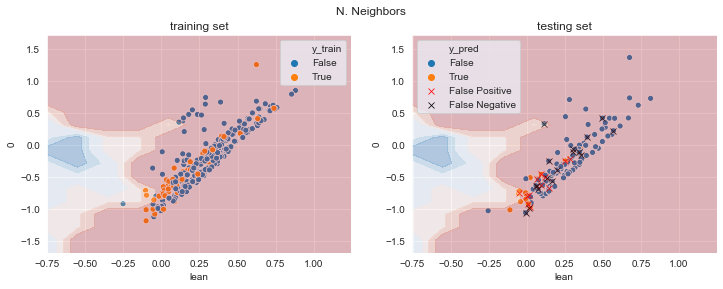

Cross Val Scores
accuracy: [0.82781457 0.76821192 0.73825503], avr:0.78
precision: [0.61538462 0.35       0.21052632], avr:0.39
recall: [0.27586207 0.24137931 0.14285714], avr:0.22


Linear SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


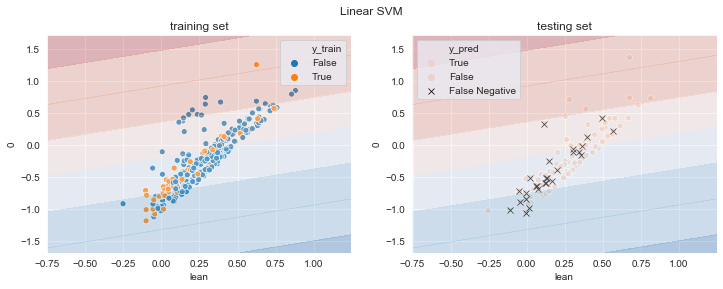

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


RBF SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



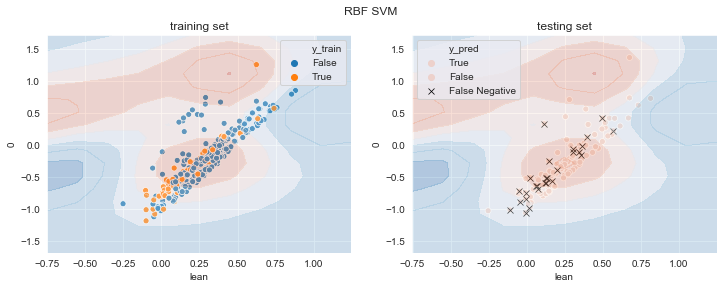

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


Gaussian P., first run:  True Negative=108, False Positive=1, False Negative=26, True Positive=1
     0  1
0  108  1
1   26  1
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.04



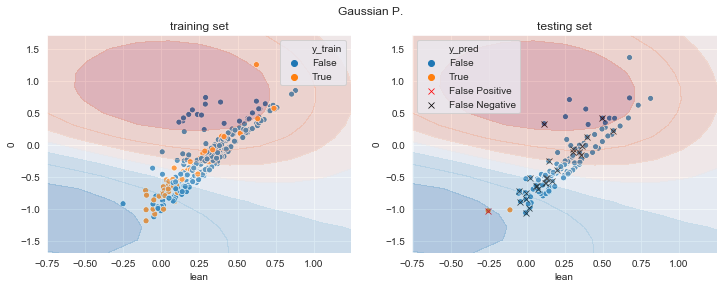

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.81456954 0.80794702 0.74496644], avr:0.79
precision: [0.66666667 0.         0.1875    ], avr:0.28
recall: [0.06896552 0.         0.10714286], avr:0.06


Decision Tree, first run:  True Negative=98, False Positive=11, False Negative=17, True Positive=10
    0   1
0  98  11
1  17  10
Raw Accuracy Score=0.79,Precision=0.48, Recall=0.37



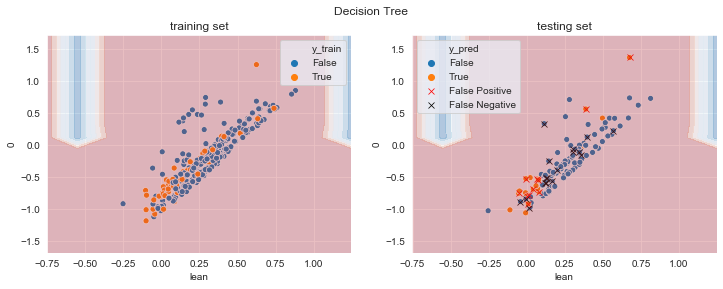

Cross Val Scores
accuracy: [0.83443709 0.78807947 0.7852349 ], avr:0.80
precision: [0.7        0.36363636 0.375     ], avr:0.48
recall: [0.24137931 0.13793103 0.21428571], avr:0.20


Random Forest, first run:  True Negative=100, False Positive=9, False Negative=19, True Positive=8
     0  1
0  100  9
1   19  8
Raw Accuracy Score=0.79,Precision=0.47, Recall=0.30



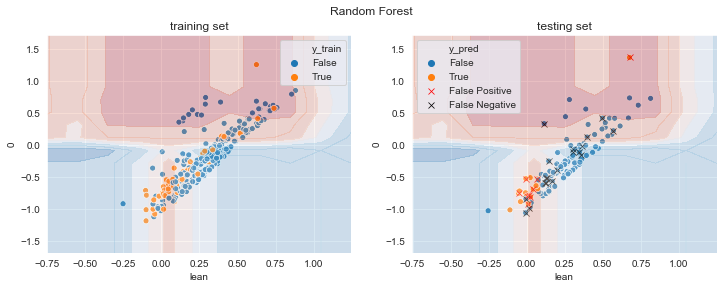

Cross Val Scores
accuracy: [0.83443709 0.79470199 0.80536913], avr:0.81
precision: [0.83333333 0.33333333 0.46153846], avr:0.54
recall: [0.17241379 0.06896552 0.21428571], avr:0.15


Neural Net, first run:  True Negative=108, False Positive=1, False Negative=26, True Positive=1
     0  1
0  108  1
1   26  1
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.04



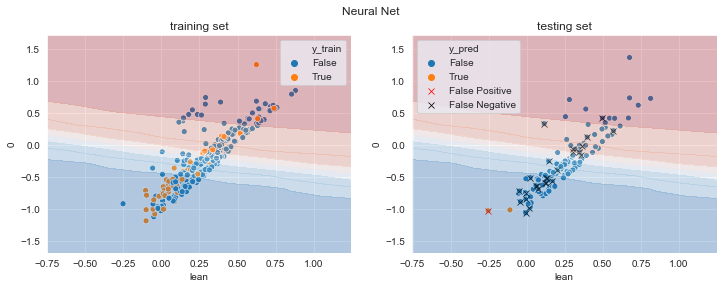

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


AdaBoost, first run:  True Negative=99, False Positive=10, False Negative=19, True Positive=8
    0   1
0  99  10
1  19   8
Raw Accuracy Score=0.79,Precision=0.44, Recall=0.30



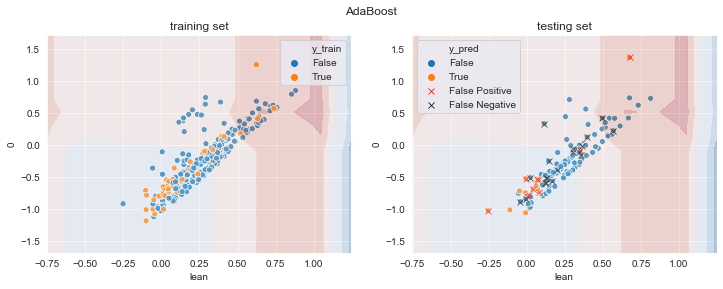

Cross Val Scores
accuracy: [0.81456954 0.78145695 0.7114094 ], avr:0.77
precision: [0.66666667 0.25       0.10526316], avr:0.34
recall: [0.06896552 0.06896552 0.07142857], avr:0.07


Naive Bayes, first run:  True Negative=101, False Positive=8, False Negative=20, True Positive=7
     0  1
0  101  8
1   20  7
Raw Accuracy Score=0.79,Precision=0.47, Recall=0.26



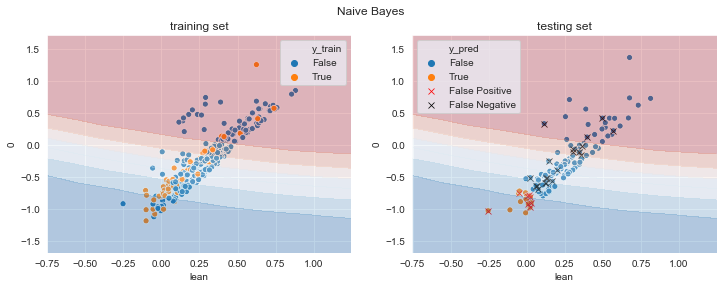

Cross Val Scores
accuracy: [0.82781457 0.78145695 0.81208054], avr:0.81
precision: [0.61538462 0.         0.5       ], avr:0.37
recall: [0.27586207 0.         0.07142857], avr:0.12


QDA, first run:  True Negative=109, False Positive=0, False Negative=24, True Positive=3
     0  1
0  109  0
1   24  3
Raw Accuracy Score=0.82,Precision=1.00, Recall=0.11



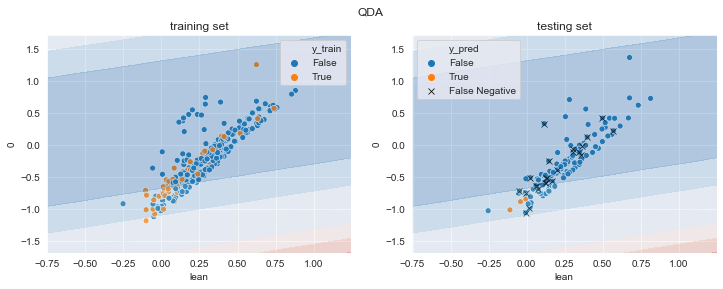

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Val Scores
accuracy: [0.8410596  0.80794702 0.80536913], avr:0.82
precision: [0.85714286 0.         0.33333333], avr:0.40
recall: [0.20689655 0.         0.03571429], avr:0.08


L. Regression, first run:  True Negative=108, False Positive=1, False Negative=27, True Positive=0
     0  1
0  108  1
1   27  0
Raw Accuracy Score=0.79,Precision=0.00, Recall=0.00



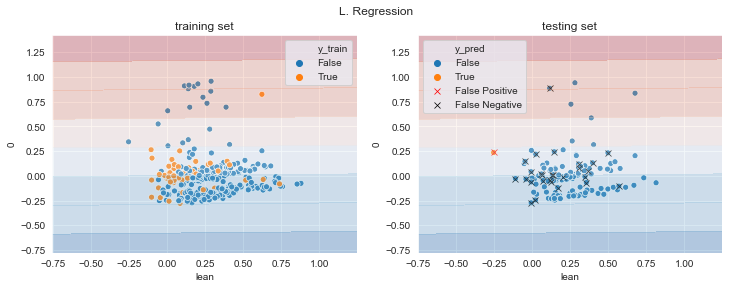

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432:

Cross Val Scores
accuracy: [0.80794702 0.80794702 0.80536913], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


N. Neighbors, first run:  True Negative=99, False Positive=10, False Negative=18, True Positive=9
    0   1
0  99  10
1  18   9
Raw Accuracy Score=0.79,Precision=0.47, Recall=0.33



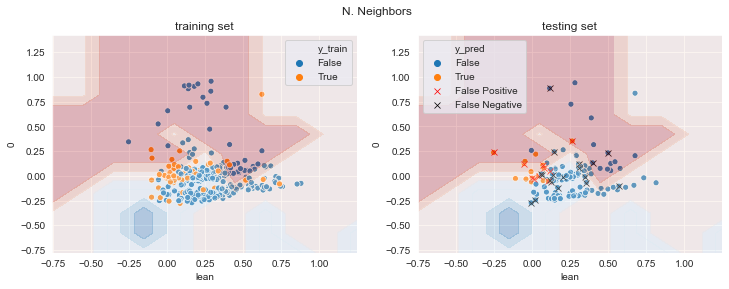

Cross Val Scores
accuracy: [0.8410596  0.82119205 0.73154362], avr:0.80
precision: [0.77777778 0.57142857 0.22727273], avr:0.53
recall: [0.24137931 0.27586207 0.17857143], avr:0.23


Linear SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


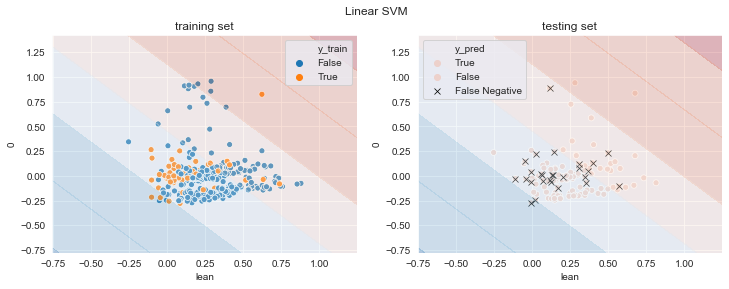

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


RBF SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



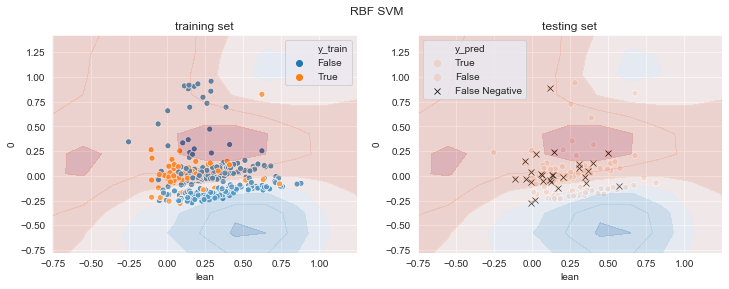

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.79865772], avr:0.80
precision: [0.   0.   0.25], avr:0.08
recall: [0.         0.         0.03571429], avr:0.01


Gaussian P., first run:  True Negative=101, False Positive=8, False Negative=22, True Positive=5
     0  1
0  101  8
1   22  5
Raw Accuracy Score=0.78,Precision=0.38, Recall=0.19



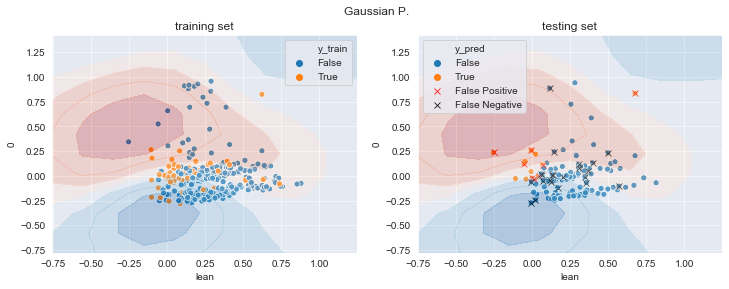

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.81456954 0.80794702 0.73154362], avr:0.78
precision: [0.57142857 0.         0.125     ], avr:0.23
recall: [0.13793103 0.         0.07142857], avr:0.07


Decision Tree, first run:  True Negative=97, False Positive=12, False Negative=15, True Positive=12
    0   1
0  97  12
1  15  12
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.44



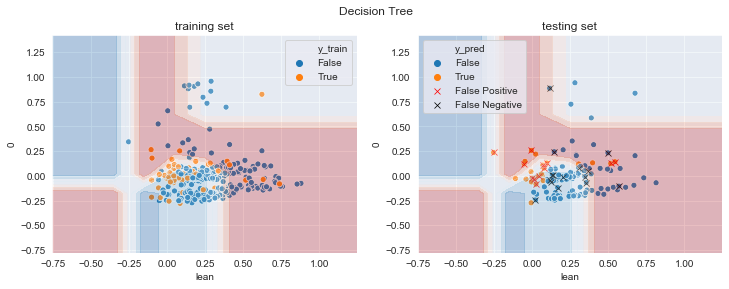

Cross Val Scores
accuracy: [0.84768212 0.81456954 0.79865772], avr:0.82
precision: [0.71428571 0.53333333 0.4375    ], avr:0.56
recall: [0.34482759 0.27586207 0.25      ], avr:0.29


Random Forest, first run:  True Negative=100, False Positive=9, False Negative=18, True Positive=9
     0  1
0  100  9
1   18  9
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.33



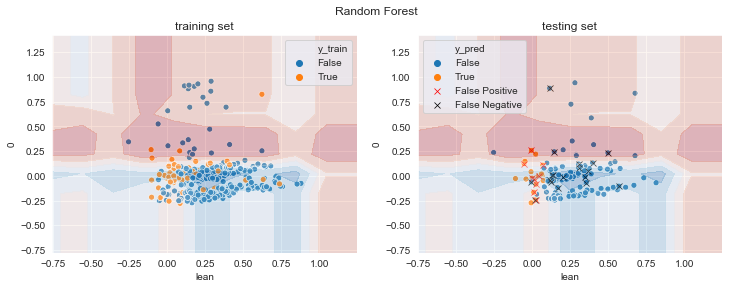

Cross Val Scores
accuracy: [0.82781457 0.82119205 0.7852349 ], avr:0.81
precision: [0.66666667 0.57142857 0.33333333], avr:0.52
recall: [0.20689655 0.27586207 0.14285714], avr:0.21


Neural Net, first run:  True Negative=106, False Positive=3, False Negative=21, True Positive=6
     0  1
0  106  3
1   21  6
Raw Accuracy Score=0.82,Precision=0.67, Recall=0.22



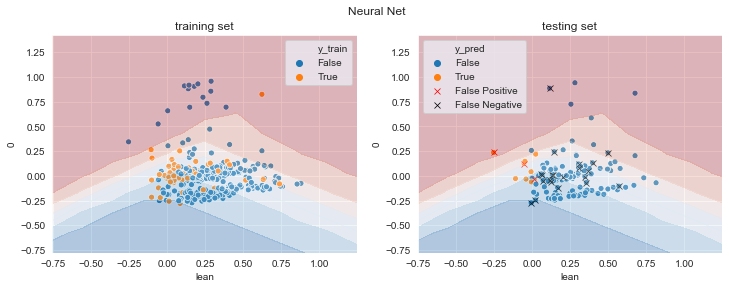

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.79470199 0.80794702 0.79194631], avr:0.80
precision: [0.  0.  0.2], avr:0.07
recall: [0.         0.         0.03571429], avr:0.01


AdaBoost, first run:  True Negative=97, False Positive=12, False Negative=17, True Positive=10
    0   1
0  97  12
1  17  10
Raw Accuracy Score=0.79,Precision=0.45, Recall=0.37



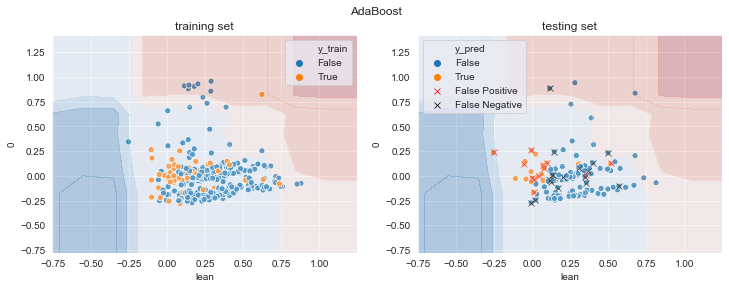

Cross Val Scores
accuracy: [0.83443709 0.81456954 0.7114094 ], avr:0.79
precision: [0.7        0.54545455 0.10526316], avr:0.45
recall: [0.24137931 0.20689655 0.07142857], avr:0.17


Naive Bayes, first run:  True Negative=108, False Positive=1, False Negative=26, True Positive=1
     0  1
0  108  1
1   26  1
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.04



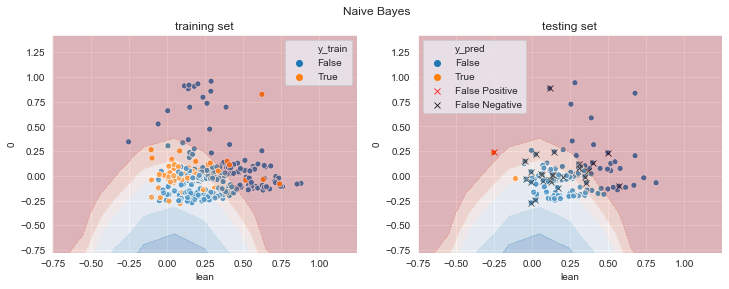

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.80536913], avr:0.81
precision: [0.         0.         0.33333333], avr:0.11
recall: [0.         0.         0.03571429], avr:0.01


QDA, first run:  True Negative=109, False Positive=0, False Negative=24, True Positive=3
     0  1
0  109  0
1   24  3
Raw Accuracy Score=0.82,Precision=1.00, Recall=0.11



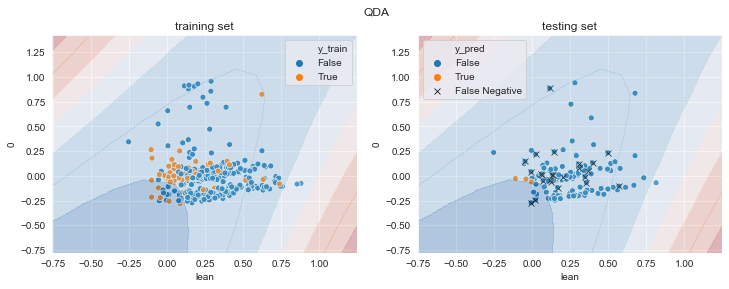

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


Cross Val Scores
accuracy: [0.8410596  0.80794702 0.80536913], avr:0.82
precision: [0.85714286 0.         0.33333333], avr:0.40
recall: [0.20689655 0.         0.03571429], avr:0.08


L. Regression, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



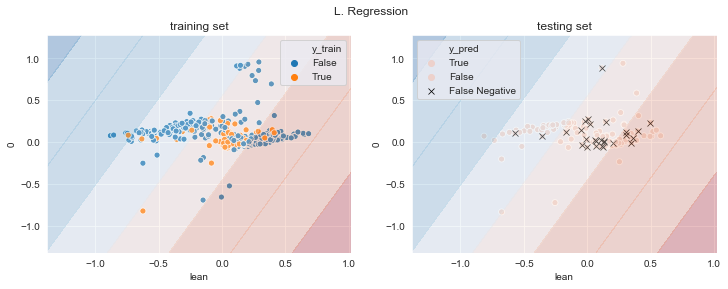

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432:

Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


N. Neighbors, first run:  True Negative=101, False Positive=8, False Negative=20, True Positive=7
     0  1
0  101  8
1   20  7
Raw Accuracy Score=0.79,Precision=0.47, Recall=0.26



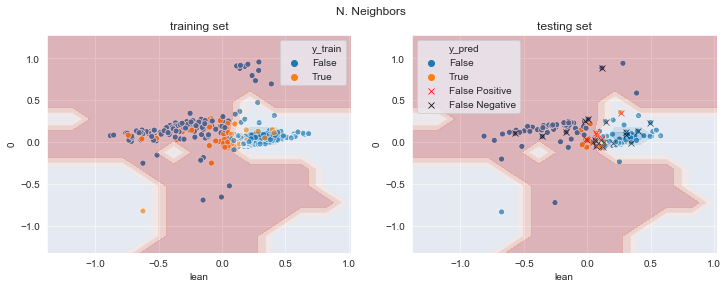

Cross Val Scores
accuracy: [0.81456954 0.78807947 0.74496644], avr:0.78
precision: [0.55555556 0.38461538 0.27272727], avr:0.40
recall: [0.17241379 0.17241379 0.21428571], avr:0.19


Linear SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


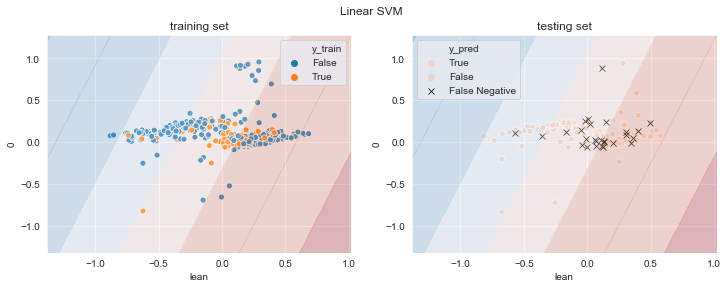

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


RBF SVM, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



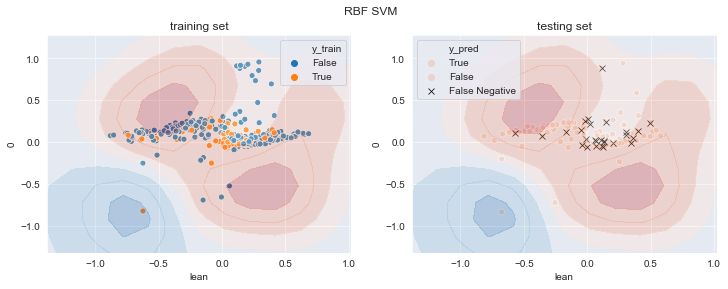

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.80536913], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


Gaussian P., first run:  True Negative=106, False Positive=3, False Negative=22, True Positive=5
     0  1
0  106  3
1   22  5
Raw Accuracy Score=0.82,Precision=0.62, Recall=0.19



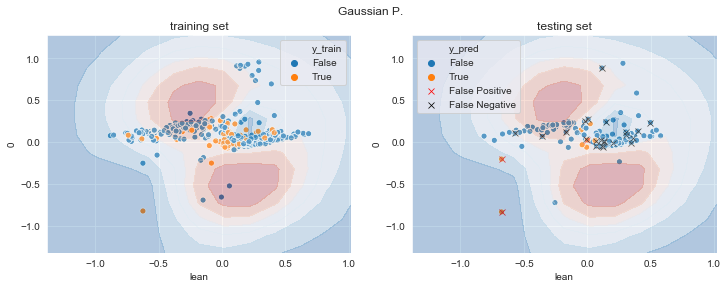

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.76510067], avr:0.79
precision: [0.         0.         0.23076923], avr:0.08
recall: [0.         0.         0.10714286], avr:0.04


Decision Tree, first run:  True Negative=103, False Positive=6, False Negative=21, True Positive=6
     0  1
0  103  6
1   21  6
Raw Accuracy Score=0.80,Precision=0.50, Recall=0.22



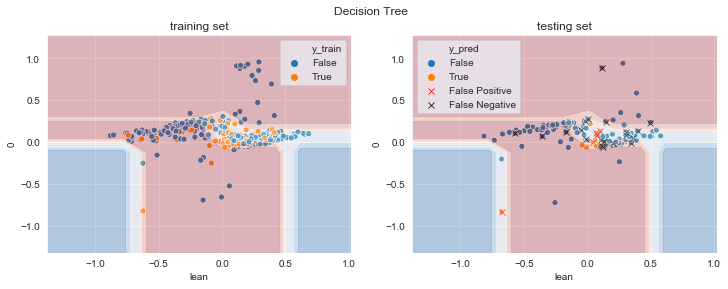

Cross Val Scores
accuracy: [0.82781457 0.80794702 0.73154362], avr:0.79
precision: [0.61538462 0.5        0.22727273], avr:0.45
recall: [0.27586207 0.24137931 0.17857143], avr:0.23


Random Forest, first run:  True Negative=101, False Positive=8, False Negative=23, True Positive=4
     0  1
0  101  8
1   23  4
Raw Accuracy Score=0.77,Precision=0.33, Recall=0.15



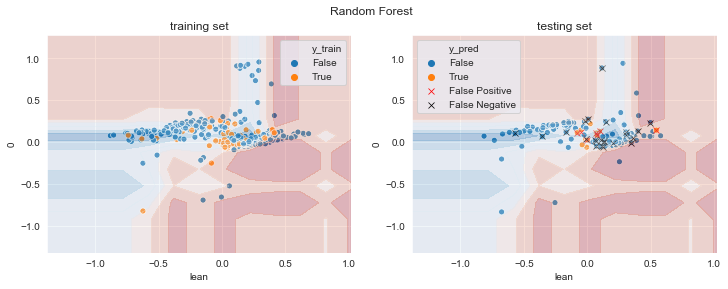

Cross Val Scores
accuracy: [0.83443709 0.78807947 0.75167785], avr:0.79
precision: [0.75       0.28571429 0.2       ], avr:0.41
recall: [0.20689655 0.06896552 0.10714286], avr:0.13


/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars




Neural Net, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



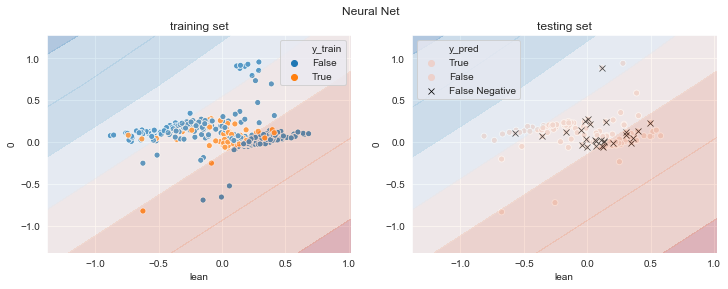

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Val Scores
accuracy: [0.80794702 0.80794702 0.81208054], avr:0.81
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


AdaBoost, first run:  True Negative=92, False Positive=17, False Negative=18, True Positive=9
    0   1
0  92  17
1  18   9
Raw Accuracy Score=0.74,Precision=0.35, Recall=0.33



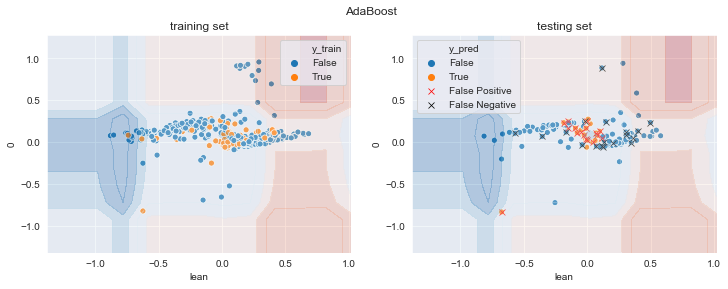

Cross Val Scores
accuracy: [0.79470199 0.79470199 0.69127517], avr:0.76
precision: [0.4375     0.4375     0.17857143], avr:0.35
recall: [0.24137931 0.24137931 0.17857143], avr:0.22


Naive Bayes, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


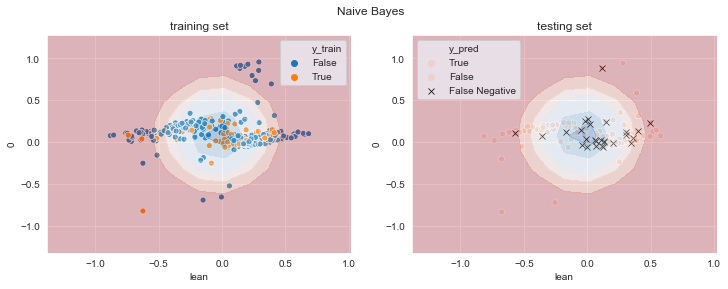

/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nhorning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in long_scalars


Cross Val Scores
accuracy: [0.80794702 0.78807947 0.81208054], avr:0.80
precision: [0. 0. 0.], avr:0.00
recall: [0. 0. 0.], avr:0.00


QDA, first run:  True Negative=109, False Positive=0, False Negative=27, True Positive=0
     0  1
0  109  0
1   27  0
Raw Accuracy Score=0.80,Precision=nan, Recall=0.00



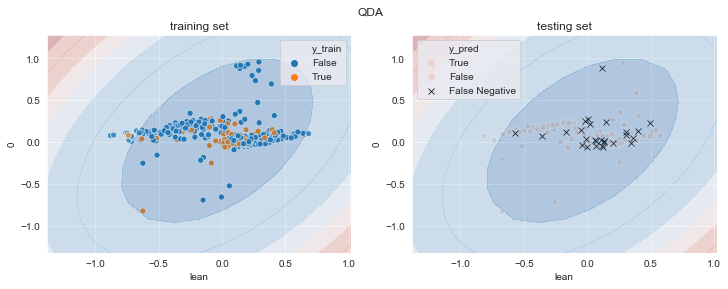

Cross Val Scores
accuracy: [0.80794702 0.78807947 0.81208054], avr:0.80
precision: [0.5 0.  0. ], avr:0.17
recall: [0.03448276 0.         0.        ], avr:0.01


/home/nhorning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
data_15.iloc[:,0] = 0 - data_15.iloc[:,0]


cvdict0= try_cls(data_15, 'eliminated', dm=('lean',0))

data = set_resids(data_15)
cvdict1 = try_cls(data, 'eliminated', dm=('lean',0))

data3 = transpose_party(data)
cvdict4 = try_cls(data3, 'eliminated', dm=('lean',0))


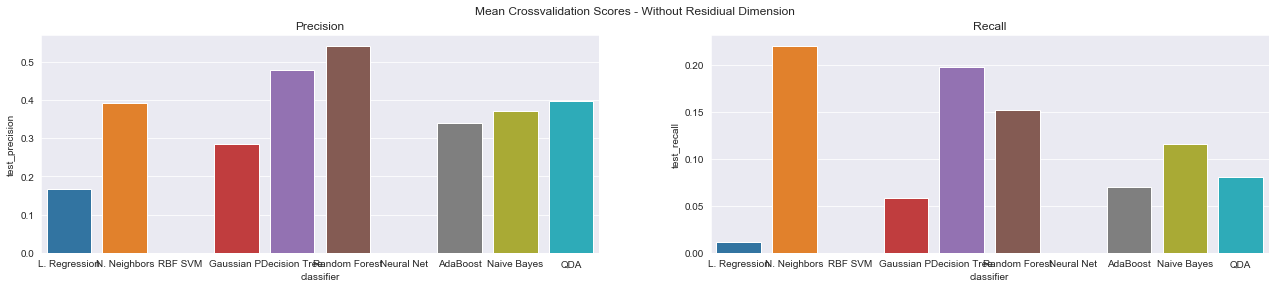

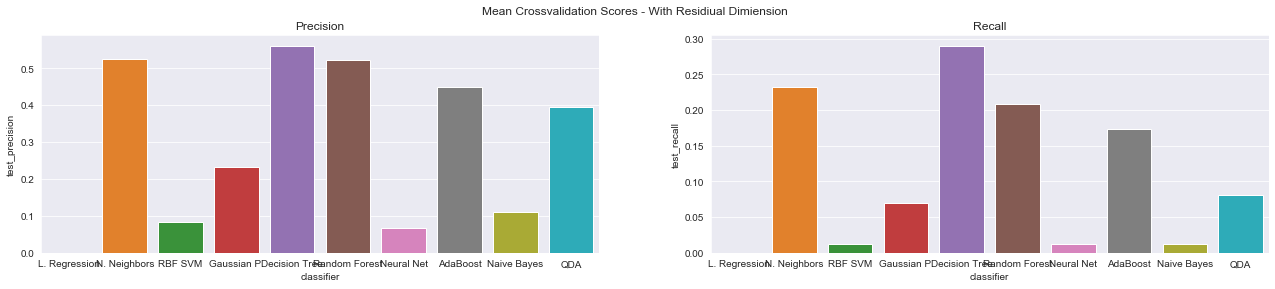

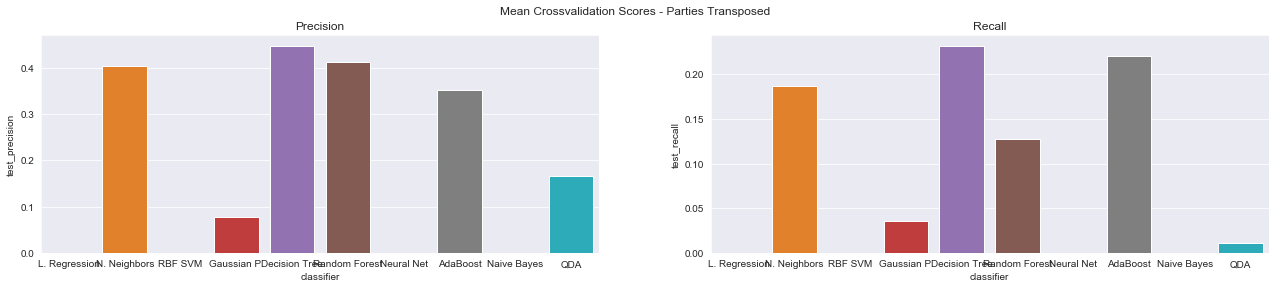

In [101]:
#plot the crossvalidation test scores.
cvdf0 = pd.DataFrame(cvdict0)
cvdf1 = pd.DataFrame(cvdict1)
cvdf4 = pd.DataFrame(cvdict4)

meandf0 = cvdf0.applymap(lambda x: np.mean(x))
meandf1 = cvdf1.applymap(lambda x: np.mean(x))
meandf4 = cvdf4.applymap(lambda x: np.mean(x))



plot_scores(meandf0, 'Mean Crossvalidation Scores - Without Residiual Dimension')
plot_scores(meandf1, 'Mean Crossvalidation Scores - With Residiual Dimiension')
plot_scores(meandf4, 'Mean Crossvalidation Scores - Parties Transposed')

In [98]:
#plot the crossvalidation test scores.
cvdf0 = pd.DataFrame(cvdict2)
cvdf1 = pd.DataFrame(cvdict3)


meandf0 = cvdf0.applymap(lambda x: np.mean(x))
meandf1 = cvdf1.applymap(lambda x: np.mean(x))

def plot_scores(meandf, title):
    test_scores0 = meandf.loc[['test_accuracy','test_precision','test_recall'],:].transpose()
    #test_scores0.drop(['Linear SVM','Neural Net','QDA'], inplace=True)
    reset0 = test_scores0.reset_index()
    reset0.columns = ['classifier','test_accuracy','test_precision','test_recall']
    
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (22, 4))

    sns.barplot(x='classifier', y='test_precision', data=reset0, ax=ax1)
    sns.barplot(x='classifier', y='test_recall', data=reset0, ax=ax2)

    ax1.set_title('Precision')
    ax2.set_title('Recall')
    f.suptitle(title)
    plt.show()

plot_scores(meandf0, 'Mean Crossvalidation Scores - Without Residiual Dimension')
plot_scores(meandf1, 'Mean Crossvalidation Scores - With Residiual Dimiension')

NameError: name 'cvdict2' is not defined

In [ ]:
test_scores1 = meandf1.loc[['test_accuracy','test_precision','test_recall'],:]
test_scores1

In [ ]:
senate_hist_reduced.head()

## Here be dragons

In [ ]:
#reduce all house votes
house_reduced_all = reduce_df(all_house_votes)
house_reduced_all.head()

In [ ]:
for congress in range(2000,2019,2):
    house_reduced = 
    #house_reduced['component_0'] = 0 - house_reduced.loc[:,'component_0']
    lean_dw(house_reduced, distlean, y='component_0', year=year)

In [ ]:
#find ideal number of clusters (Kmeans)

from sklearn.cluster import KMeans

#load a congress
_, votes = load_cache(2018, 'house')

#factorize and sort the data
votes = my_factorize(votes)

#lets look at JUST democrats


#store offer columns as a numpy matrix
x_cols = votes.transpose().values

#Create the range of k values to test
Ks = range(2,10)

#initalize a list of SS values
SS = []

#For every value of K
for K in Ks:
    #instantiate a Kmeans model
    model = KMeans(n_clusters=K, random_state=38)
    
    #Fit the model to the matrix of offers
    model.fit(x_cols)
    
    #luckily KMeans has an attribute (inertia) that extracts the sum of squared distances from the cluster centers.
    SS.append(model.inertia_)

#create a nice layout for our plots
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
f.tight_layout(h_pad=1)

#plot the inertia (SS)
ax1.plot(Ks, SS, '-o')
ax1.set_xlabel('Number of clusters, K')
ax1.set_ylabel('SS (Inertia)')
ax1.set_title('SS for each K')
ax1.set_xticks(Ks)

#Fit a create and fit a model using best K (3)
best_model = KMeans(n_clusters=4, random_state=38)
best_model.fit(x_cols)

#find the number of points with each cluster label
labels, counts = np.unique(best_model.labels_, return_counts=True)

#plot a bar chart of the number of points in each cluster
sns.barplot(labels, counts, ax=ax2)
ax2.set_xlabel('Cluster number (k)')
ax2.set_ylabel('Number of points')
ax2.set_title('Points in each cluster')
plt.show()

It looks like the ideal number of clusters is around 3. We'll make that the default.

In [ ]:
_, votes = load_cache(2018, 'senate')
multi_cluster(votes)

In [ ]:
#
for year in range(1998,2018):
    _, votes = load_cache(year, 'house')
    multi_cluster(votes)